# AB_simulate_combined_LCs

Simulate DRW light curves, spanning the individual  baselines. 

Sample at cadences corresponding to SDSS,  SDSS+CRTS,  SDSS+CRTS+PTF, SDSS+CRTS+PTF+PS1.  Given each sampling, with with Celerite Jeff1, Jeff2, finding the MAP solution. 




In [2]:
pwd

'/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code'

In [6]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
import celerite
import modules as mod
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [2]:
# consider all combined lc's 
outDir = '../data_products/SDSS-PTF-CRTS-PS1_/'
done_lcs = os.listdir(outDir)
#done_lcs.remove('.DS_Store')

### 1 : Test the code on just one combined light curve:

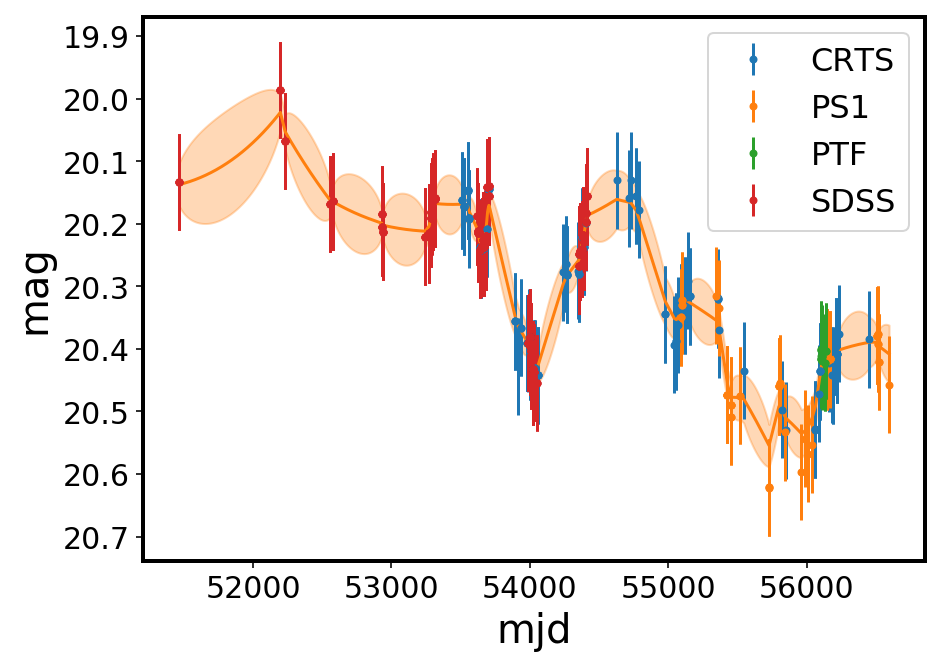

In [3]:
%matplotlib inline 

# We simulate with tau=575 days,  SF_inf = 0.2 mag, which are the 
#  median observed-frame values for the S82 quasar sample (MacLeod+2011, Sec.5.1)
SF_inf = 0.2  # mags 
sigma_in = SF_inf / np.sqrt(2)
tau_in = 575 # days 

# Read in each light curve, and simulate DRW
i=0
fname = outDir+done_lcs[i]
lc = Table.read(fname, format='ascii')
lc.sort('mjd')
# simulate DRW by spanning a space between minimum and  maximum,
# with 4 points per day 
tmax, tmin = lc['mjd'].max()  , lc['mjd'].min()
Npts = int((tmax-tmin))*4 # 4 points per day
t = np.sort(np.random.uniform(tmin, tmax, Npts)) 
y = mod.sim_DRW_lightcurve(t, SF_inf, tau_in , np.mean(lc['mag']))
median_err = np.median(lc['magerr'].data)
yerr = np.ones_like(t)*median_err
#plt.errorbar(t,y,yerr_med)
#sim_lc = Table([t,y,yerr], names=['mjd', 'mag', 'magerr'])
# store the simulated 'true' LC 
#name = '../data_products/Simulated_LC_DRW/'+done_lcs[i]
#sim_lc.write(name, format='ascii',overwrite='True')
#print('Saved as ', name)

# Illustrate where the components of the LC come 
# from , assuming all filters contribute ... 
tz = lc['mjd'].data
ez = lc['magerr'].data

%config InlineBackend.figure_format='retina'
fig,ax =plt.subplots(1,1,figsize=(7,5))
for survey in np.unique(lc['survey'].data):
    m = lc['survey'].data == survey
    yz = np.interp(tz[m],t,y)
    ax.errorbar(tz[m], yz ,
                 np.median(ez), fmt=".", capsize=0,
                 label=survey.upper())
ax.legend(fontsize=16)
ax.set_xlabel('mjd')
ax.set_ylabel('mag')
ax.invert_yaxis()
# Find the best fit ... 
# find the MAP estimate 
yz = np.interp(tz,t,y)
prior='Jeff1'
sig_lims = [0.01,1]
tau_lims = [1,10000]
sigmaMAP, tauMAP,gp = mod.find_celerite_MAP(tz,yz,np.median(ez), 
                          sigma_in, tau_in, prior=prior,set_bounds=True, 
                          sig_lims=sig_lims, tau_lims=tau_lims ,verbose=False)




# plot the prediction conditioned on the observed data 
x = np.linspace(min(tz), max(tz), 5000)
pred_mean, pred_var = gp.predict(yz, x, return_var=True)
pred_std = np.sqrt(pred_var)
color = "#ff7f0e"
ax.plot(x, pred_mean, color=color)
ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, 
                 color=color, alpha=0.3,
                 )
    
    
    
#plt.savefig('simulated_'+done_lcs[i]+'_components.png', bbox_inches='tight', dpi=100)

Illustrate how this works : 

In [5]:
import modules
import imp

In [8]:
# Sample at cadences of SDSS,  SDSS+CRTS, SDSS+CRTS+PTF,  SDSS+CRTS+PTF+PS1
m1 = lc['survey'].data == 'sdss'
m2 = lc['survey'].data == 'crts'
m3 = lc['survey'].data == 'ptf'
m4 = lc['survey'].data == 'ps1'

t1 = np.sort(lc['mjd'].data[m1])
t12 = np.sort(lc['mjd'].data[m1|m2])
t123 = np.sort(lc['mjd'].data[m1|m2|m3])
t1234 = np.sort(lc['mjd'].data[m1|m2|m3|m4])


# Sample at these times , and fit with Celerite ... 
sig_lims , tau_lims = [0.02,0.7], [1,5000]

for time in [t1,t12,t123,t1234] : 
    sigma_fit, tau_fit,gp = modules.find_celerite_MAP(time,np.interp(time,t,y),
          median_err, sigma_in, tau_in, prior='Jeff2', set_bounds = True , sig_lims = sig_lims  , 
          tau_lims = tau_lims, verbose = False )
    


In [108]:
lcname = done_lcs[i][:-4]

lcnames = []
taus = {1:[], 2:[], 3:[], 4:[]}
sigmas  =  {1:[], 2:[], 3:[], 4:[]}

lcnames.append(lcname)

for i,time in enumerate([t1,t12,t123,t1234]) : 
    sigma_fit, tau_fit,gp = celerite_fit.find_celerite_MAP(time,np.interp(time,t,y),
          median_err, prior='Jeff2', set_bounds = True , sig_lims = sig_lims  , 
          tau_lims = tau_lims)
    
    
    sigmas[i+1].append(sigma_fit)
    taus[i+1].append(tau_fit)

### 2 : Single loop - simulate DRW and save

Below we simulate a single DRW spanning the **true length of the combined light curves** (hence the same name), at **exactly the same MJD**  as the 'real' light curves.  We store these simulated 'true' light curves in ../data_products/Simulated_LC_DRW_true/ including t,y, since we are storing only the 'ideal' light curve (true), $y_{true}$. 

When fitting (in the next step), we 'sample' at exact times corresponding to SDSS cadences, SDSS+CRTS,  SDSS+CRTS+PS1. etc. 

We also Gaussian noise to each sampled point: 

$y_{obs,i} = y_{true,i} + \mathcal{N}(0,\sigma_{i})$ , 

where $i$ runs along the light curve length. Thus if we assume that all errors are constant,  then  $\sigma_{i} = \sigma $ (eg. $\sigma = 0.01 mag$). If we assume that all errors correspond to eg. the median of each light curve real erorrs (that are dependent on the magnitude of each quasar), then $\sigma$ = median(err)). 

Adding Gaussian noise is sampling $N$ points from a Gaussian with spread of $\sigma_{i}$ : $\mathcal{N}(0,\sigma_{i})$, or sampling $N$ points from a unit Gaussian multiplied by error : $\sigma_{i}  \mathcal{N}(0,1)$. The two are identical. 




In [65]:
# Put all that code into a loop over all light curves 
for i in range(len(done_lcs)):
    fname = outDir+done_lcs[i]
    lcname = done_lcs[i][:-4]
    lc = Table.read(fname, format='ascii')
    t = np.sort(np.unique(lc['mjd'])) 
    # the original unique time stamps 
    # this is needed because sometimes the near-simultaneous obs 
    # in different filters would reuslt in two or three 
    # time stamps that are identical
    # (NOTE:  here we take obs ACROSS filters, i.e. 
    # all ugriz timestamps for SDSS ! )
    #tmax, tmin = lc['mjd'].max()  , lc['mjd'].min()
    #Npts = int((tmax-tmin))*4 # 4 points per day
    #t = np.sort(np.random.uniform(tmin, tmax, Npts)) 
    #t = np.linspace(tmin, tmax, Npts)
    
    # simulate the true light curve 
    # with no added observational noise yet !@ 
    y = mod.sim_DRW_lightcurve(t, SF_inf, tau_in , np.mean(lc['mag']))
    print(i, ' original lc ', len(lc), 'pts,  simulated lc ', len(t), ' pts, ')
    
    sim_lc = Table([t,y], names=['mjd', 'mag'])
    
    # store the simulated 'true' LC 
    name = '../data_products/Simulated_LC_DRW_true/'+done_lcs[i]
    sim_lc.write(name, format='ascii',overwrite='True')
    print('Saved as ', name)

   

0  original lc  472 pts,  simulated lc  472  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1441903.txt
1  original lc  627 pts,  simulated lc  627  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/908716.txt
2  original lc  355 pts,  simulated lc  355  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/100520.txt
3  original lc  598 pts,  simulated lc  596  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3759755.txt
4  original lc  487 pts,  simulated lc  486  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/505877.txt
5  original lc  445 pts,  simulated lc  444  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/248292.txt
6  original lc  855 pts,  simulated lc  854  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1225760.txt
7  original lc  614 pts,  simulated lc  612  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/953706.txt
8  original lc  465 pts,  simulated lc  464  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3537034.t

79  original lc  654 pts,  simulated lc  647  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2542225.txt
80  original lc  465 pts,  simulated lc  465  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3167153.txt
81  original lc  655 pts,  simulated lc  653  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1735237.txt
82  original lc  555 pts,  simulated lc  555  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1610935.txt
83  original lc  706 pts,  simulated lc  706  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/508176.txt
84  original lc  709 pts,  simulated lc  709  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2597342.txt
85  original lc  599 pts,  simulated lc  599  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3065778.txt
86  original lc  400 pts,  simulated lc  390  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/505452.txt
87  original lc  422 pts,  simulated lc  422  pts, 
Saved as  ../data_products/Simulated_LC_DRW_tr

159  original lc  497 pts,  simulated lc  495  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3085263.txt
160  original lc  727 pts,  simulated lc  722  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3089459.txt
161  original lc  657 pts,  simulated lc  657  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2492819.txt
162  original lc  702 pts,  simulated lc  701  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3958668.txt
163  original lc  558 pts,  simulated lc  558  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/51135.txt
164  original lc  783 pts,  simulated lc  782  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2238315.txt
165  original lc  355 pts,  simulated lc  355  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1267341.txt
166  original lc  551 pts,  simulated lc  550  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1701541.txt
167  original lc  454 pts,  simulated lc  452  pts, 
Saved as  ../data_products/Simulated_

234  original lc  357 pts,  simulated lc  356  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1999857.txt
235  original lc  779 pts,  simulated lc  759  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/392158.txt
236  original lc  420 pts,  simulated lc  420  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/794906.txt
237  original lc  317 pts,  simulated lc  317  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1421827.txt
238  original lc  586 pts,  simulated lc  585  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1262562.txt
239  original lc  578 pts,  simulated lc  578  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/906100.txt
240  original lc  451 pts,  simulated lc  451  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3883051.txt
241  original lc  590 pts,  simulated lc  539  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/38814.txt
242  original lc  717 pts,  simulated lc  716  pts, 
Saved as  ../data_products/Simulated_LC_

380  original lc  1029 pts,  simulated lc  1029  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/437185.txt
381  original lc  704 pts,  simulated lc  704  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/936612.txt
382  original lc  723 pts,  simulated lc  718  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3778003.txt
383  original lc  607 pts,  simulated lc  604  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1242711.txt
384  original lc  734 pts,  simulated lc  734  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/860454.txt
385  original lc  722 pts,  simulated lc  722  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/392010.txt
386  original lc  407 pts,  simulated lc  407  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1454328.txt
387  original lc  591 pts,  simulated lc  591  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/101818.txt
388  original lc  680 pts,  simulated lc  675  pts, 
Saved as  ../data_products/Simulated_L

459  original lc  431 pts,  simulated lc  428  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1770595.txt
460  original lc  415 pts,  simulated lc  415  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3106021.txt
461  original lc  406 pts,  simulated lc  406  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3951075.txt
462  original lc  749 pts,  simulated lc  748  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3042111.txt
463  original lc  456 pts,  simulated lc  455  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/220111.txt
464  original lc  398 pts,  simulated lc  398  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/120817.txt
465  original lc  301 pts,  simulated lc  301  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/692232.txt
466  original lc  715 pts,  simulated lc  715  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3092132.txt
467  original lc  606 pts,  simulated lc  606  pts, 
Saved as  ../data_products/Simulated_L

542  original lc  552 pts,  simulated lc  541  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3799176.txt
543  original lc  644 pts,  simulated lc  641  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2032495.txt
544  original lc  517 pts,  simulated lc  515  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4143848.txt
545  original lc  537 pts,  simulated lc  537  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/948053.txt
546  original lc  476 pts,  simulated lc  476  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3962093.txt
547  original lc  432 pts,  simulated lc  431  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/88455.txt
548  original lc  442 pts,  simulated lc  442  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2006042.txt
549  original lc  583 pts,  simulated lc  579  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1901403.txt
550  original lc  875 pts,  simulated lc  873  pts, 
Saved as  ../data_products/Simulated_L

626  original lc  508 pts,  simulated lc  507  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/158833.txt
627  original lc  739 pts,  simulated lc  739  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1678724.txt
628  original lc  517 pts,  simulated lc  515  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4007575.txt
629  original lc  553 pts,  simulated lc  552  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/63621.txt
630  original lc  568 pts,  simulated lc  562  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1364850.txt
631  original lc  416 pts,  simulated lc  416  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/476087.txt
632  original lc  371 pts,  simulated lc  369  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1486324.txt
633  original lc  688 pts,  simulated lc  688  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/329914.txt
634  original lc  1000 pts,  simulated lc  994  pts, 
Saved as  ../data_products/Simulated_LC

704  original lc  338 pts,  simulated lc  337  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3165632.txt
705  original lc  771 pts,  simulated lc  770  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/361548.txt
706  original lc  749 pts,  simulated lc  745  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1510810.txt
707  original lc  729 pts,  simulated lc  729  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1060872.txt
708  original lc  806 pts,  simulated lc  806  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3983536.txt
709  original lc  696 pts,  simulated lc  693  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2102219.txt
710  original lc  654 pts,  simulated lc  653  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/141146.txt
711  original lc  705 pts,  simulated lc  702  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4103289.txt
712  original lc  691 pts,  simulated lc  691  pts, 
Saved as  ../data_products/Simulated_

785  original lc  646 pts,  simulated lc  642  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/205409.txt
786  original lc  624 pts,  simulated lc  624  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1576834.txt
787  original lc  457 pts,  simulated lc  455  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1209277.txt
788  original lc  818 pts,  simulated lc  817  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/210004.txt
789  original lc  540 pts,  simulated lc  540  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1303766.txt
790  original lc  467 pts,  simulated lc  467  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4101703.txt
791  original lc  643 pts,  simulated lc  643  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1156085.txt
792  original lc  727 pts,  simulated lc  727  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/133895.txt
793  original lc  364 pts,  simulated lc  364  pts, 
Saved as  ../data_products/Simulated_L

858  original lc  667 pts,  simulated lc  667  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1011484.txt
859  original lc  687 pts,  simulated lc  686  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/174258.txt
860  original lc  556 pts,  simulated lc  555  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/624146.txt
861  original lc  642 pts,  simulated lc  638  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/631205.txt
862  original lc  646 pts,  simulated lc  644  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3045684.txt
863  original lc  685 pts,  simulated lc  684  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1176345.txt
864  original lc  714 pts,  simulated lc  712  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/779269.txt
865  original lc  707 pts,  simulated lc  707  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/849957.txt
866  original lc  760 pts,  simulated lc  755  pts, 
Saved as  ../data_products/Simulated_LC_

938  original lc  656 pts,  simulated lc  654  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1566982.txt
939  original lc  500 pts,  simulated lc  500  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/885742.txt
940  original lc  739 pts,  simulated lc  736  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1072282.txt
941  original lc  865 pts,  simulated lc  865  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1579652.txt
942  original lc  373 pts,  simulated lc  373  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1758630.txt
943  original lc  456 pts,  simulated lc  456  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3692754.txt
944  original lc  695 pts,  simulated lc  692  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3055736.txt
945  original lc  454 pts,  simulated lc  454  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/286499.txt
946  original lc  802 pts,  simulated lc  800  pts, 
Saved as  ../data_products/Simulated_

1012  original lc  837 pts,  simulated lc  836  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2360811.txt
1013  original lc  605 pts,  simulated lc  604  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3057492.txt
1014  original lc  765 pts,  simulated lc  765  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1851782.txt
1015  original lc  478 pts,  simulated lc  477  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1108089.txt
1016  original lc  923 pts,  simulated lc  923  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2512776.txt
1017  original lc  623 pts,  simulated lc  620  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/54088.txt
1018  original lc  624 pts,  simulated lc  624  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4151044.txt
1019  original lc  678 pts,  simulated lc  678  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1673674.txt
1020  original lc  678 pts,  simulated lc  676  pts, 
Saved as  ../data_products/S

1091  original lc  693 pts,  simulated lc  692  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1373125.txt
1092  original lc  590 pts,  simulated lc  590  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1568038.txt
1093  original lc  633 pts,  simulated lc  631  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1659513.txt
1094  original lc  400 pts,  simulated lc  400  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3647154.txt
1095  original lc  445 pts,  simulated lc  444  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4112395.txt
1096  original lc  661 pts,  simulated lc  661  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1640042.txt
1097  original lc  689 pts,  simulated lc  688  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/417694.txt
1098  original lc  646 pts,  simulated lc  646  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1284591.txt
1099  original lc  493 pts,  simulated lc  493  pts, 
Saved as  ../data_products/

1164  original lc  823 pts,  simulated lc  823  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2188045.txt
1165  original lc  546 pts,  simulated lc  546  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4129263.txt
1166  original lc  733 pts,  simulated lc  732  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/921817.txt
1167  original lc  569 pts,  simulated lc  569  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2521746.txt
1168  original lc  383 pts,  simulated lc  383  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1416647.txt
1169  original lc  452 pts,  simulated lc  452  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/245000.txt
1170  original lc  519 pts,  simulated lc  519  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/241500.txt
1171  original lc  809 pts,  simulated lc  806  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/313252.txt
1172  original lc  674 pts,  simulated lc  672  pts, 
Saved as  ../data_products/Sim

1238  original lc  680 pts,  simulated lc  680  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1278476.txt
1239  original lc  869 pts,  simulated lc  866  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/959548.txt
1240  original lc  508 pts,  simulated lc  507  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1412379.txt
1241  original lc  742 pts,  simulated lc  739  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/362495.txt
1242  original lc  627 pts,  simulated lc  626  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2523386.txt
1243  original lc  411 pts,  simulated lc  408  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/216300.txt
1244  original lc  677 pts,  simulated lc  675  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/389434.txt
1245  original lc  542 pts,  simulated lc  541  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/309552.txt
1246  original lc  682 pts,  simulated lc  680  pts, 
Saved as  ../data_products/Simu

1310  original lc  419 pts,  simulated lc  415  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/482276.txt
1311  original lc  464 pts,  simulated lc  464  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/543358.txt
1312  original lc  452 pts,  simulated lc  452  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4071793.txt
1313  original lc  654 pts,  simulated lc  654  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1307711.txt
1314  original lc  561 pts,  simulated lc  558  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1549143.txt
1315  original lc  487 pts,  simulated lc  487  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/514572.txt
1316  original lc  790 pts,  simulated lc  788  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1756971.txt
1317  original lc  682 pts,  simulated lc  679  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/874169.txt
1318  original lc  495 pts,  simulated lc  493  pts, 
Saved as  ../data_products/Sim

1383  original lc  456 pts,  simulated lc  456  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/337523.txt
1384  original lc  539 pts,  simulated lc  539  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1228453.txt
1385  original lc  1160 pts,  simulated lc  1156  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/892981.txt
1386  original lc  428 pts,  simulated lc  428  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3046239.txt
1387  original lc  380 pts,  simulated lc  380  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3771157.txt
1388  original lc  416 pts,  simulated lc  416  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2617689.txt
1389  original lc  546 pts,  simulated lc  545  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/632653.txt
1390  original lc  672 pts,  simulated lc  668  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/858905.txt
1391  original lc  644 pts,  simulated lc  644  pts, 
Saved as  ../data_products/S

1463  original lc  617 pts,  simulated lc  616  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3869664.txt
1464  original lc  655 pts,  simulated lc  654  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1589206.txt
1465  original lc  449 pts,  simulated lc  448  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/247562.txt
1466  original lc  612 pts,  simulated lc  609  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4047354.txt
1467  original lc  565 pts,  simulated lc  564  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2097953.txt
1468  original lc  649 pts,  simulated lc  648  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/411219.txt
1469  original lc  395 pts,  simulated lc  395  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4874692.txt
1470  original lc  646 pts,  simulated lc  642  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/250750.txt
1471  original lc  778 pts,  simulated lc  778  pts, 
Saved as  ../data_products/Si

1535  original lc  510 pts,  simulated lc  510  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4073807.txt
1536  original lc  627 pts,  simulated lc  625  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1038570.txt
1537  original lc  631 pts,  simulated lc  631  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1598525.txt
1538  original lc  519 pts,  simulated lc  518  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/283483.txt
1539  original lc  756 pts,  simulated lc  755  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/194621.txt
1540  original lc  509 pts,  simulated lc  508  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/660289.txt
1541  original lc  413 pts,  simulated lc  413  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/666820.txt
1542  original lc  681 pts,  simulated lc  680  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/885634.txt
1543  original lc  783 pts,  simulated lc  780  pts, 
Saved as  ../data_products/Simu

1614  original lc  640 pts,  simulated lc  640  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1607027.txt
1615  original lc  584 pts,  simulated lc  584  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/149625.txt
1616  original lc  758 pts,  simulated lc  758  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/448900.txt
1617  original lc  747 pts,  simulated lc  747  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/534377.txt
1618  original lc  390 pts,  simulated lc  390  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/751557.txt
1619  original lc  509 pts,  simulated lc  495  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3138839.txt
1620  original lc  611 pts,  simulated lc  607  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/606369.txt
1621  original lc  332 pts,  simulated lc  332  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1808731.txt
1622  original lc  698 pts,  simulated lc  696  pts, 
Saved as  ../data_products/Simu

1687  original lc  670 pts,  simulated lc  670  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1643467.txt
1688  original lc  714 pts,  simulated lc  714  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1074090.txt
1689  original lc  542 pts,  simulated lc  541  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/801221.txt
1690  original lc  735 pts,  simulated lc  733  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2957567.txt
1691  original lc  612 pts,  simulated lc  612  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1406183.txt
1692  original lc  578 pts,  simulated lc  576  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/241969.txt
1693  original lc  610 pts,  simulated lc  610  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2560024.txt
1694  original lc  729 pts,  simulated lc  728  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/657324.txt
1695  original lc  555 pts,  simulated lc  555  pts, 
Saved as  ../data_products/Si

1770  original lc  603 pts,  simulated lc  599  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3619919.txt
1771  original lc  761 pts,  simulated lc  759  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/538834.txt
1772  original lc  658 pts,  simulated lc  656  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1714488.txt
1773  original lc  456 pts,  simulated lc  456  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4042539.txt
1774  original lc  669 pts,  simulated lc  668  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2004812.txt
1775  original lc  632 pts,  simulated lc  632  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1347569.txt
1776  original lc  452 pts,  simulated lc  450  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/163351.txt
1777  original lc  718 pts,  simulated lc  718  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1185848.txt
1778  original lc  581 pts,  simulated lc  577  pts, 
Saved as  ../data_products/S

1852  original lc  730 pts,  simulated lc  728  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2753912.txt
1853  original lc  656 pts,  simulated lc  656  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1001793.txt
1854  original lc  587 pts,  simulated lc  585  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1105293.txt
1855  original lc  471 pts,  simulated lc  469  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/569688.txt
1856  original lc  464 pts,  simulated lc  464  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/260385.txt
1857  original lc  605 pts,  simulated lc  605  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1441632.txt
1858  original lc  669 pts,  simulated lc  666  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/621648.txt
1859  original lc  552 pts,  simulated lc  552  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1305559.txt
1860  original lc  498 pts,  simulated lc  497  pts, 
Saved as  ../data_products/Si

Saved as  ../data_products/Simulated_LC_DRW_true/118721.txt
1926  original lc  555 pts,  simulated lc  551  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1643248.txt
1927  original lc  457 pts,  simulated lc  457  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4136520.txt
1928  original lc  628 pts,  simulated lc  626  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2473677.txt
1929  original lc  473 pts,  simulated lc  473  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2614640.txt
1930  original lc  348 pts,  simulated lc  347  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/646374.txt
1931  original lc  673 pts,  simulated lc  673  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1658898.txt
1932  original lc  399 pts,  simulated lc  399  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1298693.txt
1933  original lc  509 pts,  simulated lc  505  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1140240.txt
1934  original lc  50

Saved as  ../data_products/Simulated_LC_DRW_true/476838.txt
1999  original lc  507 pts,  simulated lc  507  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4054992.txt
2000  original lc  996 pts,  simulated lc  996  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1694699.txt
2001  original lc  932 pts,  simulated lc  932  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2580462.txt
2002  original lc  636 pts,  simulated lc  633  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/281027.txt
2003  original lc  477 pts,  simulated lc  476  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3924460.txt
2004  original lc  638 pts,  simulated lc  638  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/502161.txt
2005  original lc  496 pts,  simulated lc  495  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2612806.txt
2006  original lc  463 pts,  simulated lc  463  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1928345.txt
2007  original lc  675

2072  original lc  774 pts,  simulated lc  773  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1250374.txt
2073  original lc  656 pts,  simulated lc  653  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/940518.txt
2074  original lc  580 pts,  simulated lc  580  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/987735.txt
2075  original lc  621 pts,  simulated lc  621  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3977589.txt
2076  original lc  603 pts,  simulated lc  601  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1696259.txt
2077  original lc  676 pts,  simulated lc  676  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1988442.txt
2078  original lc  793 pts,  simulated lc  792  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1811707.txt
2079  original lc  646 pts,  simulated lc  642  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/683604.txt
2080  original lc  692 pts,  simulated lc  692  pts, 
Saved as  ../data_products/Si

2151  original lc  747 pts,  simulated lc  746  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1899407.txt
2152  original lc  699 pts,  simulated lc  698  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3994028.txt
2153  original lc  679 pts,  simulated lc  679  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2101000.txt
2154  original lc  374 pts,  simulated lc  374  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4080109.txt
2155  original lc  828 pts,  simulated lc  828  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2517318.txt
2156  original lc  495 pts,  simulated lc  495  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/51380.txt
2157  original lc  715 pts,  simulated lc  715  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2755187.txt
2158  original lc  453 pts,  simulated lc  450  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2559705.txt
2159  original lc  287 pts,  simulated lc  287  pts, 
Saved as  ../data_products/S

2225  original lc  387 pts,  simulated lc  387  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/459984.txt
2226  original lc  668 pts,  simulated lc  668  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1858925.txt
2227  original lc  858 pts,  simulated lc  858  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3985483.txt
2228  original lc  589 pts,  simulated lc  588  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1526872.txt
2229  original lc  482 pts,  simulated lc  481  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/844384.txt
2230  original lc  664 pts,  simulated lc  662  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/206017.txt
2231  original lc  572 pts,  simulated lc  571  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/702904.txt
2232  original lc  672 pts,  simulated lc  670  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1623742.txt
2233  original lc  625 pts,  simulated lc  624  pts, 
Saved as  ../data_products/Sim

2299  original lc  625 pts,  simulated lc  624  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1199293.txt
2300  original lc  433 pts,  simulated lc  432  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2303889.txt
2301  original lc  448 pts,  simulated lc  443  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4085716.txt
2302  original lc  598 pts,  simulated lc  598  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1802815.txt
2303  original lc  449 pts,  simulated lc  447  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3921679.txt
2304  original lc  566 pts,  simulated lc  566  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/539296.txt
2305  original lc  529 pts,  simulated lc  529  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/78713.txt
2306  original lc  635 pts,  simulated lc  634  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2514610.txt
2307  original lc  427 pts,  simulated lc  427  pts, 
Saved as  ../data_products/Si

2382  original lc  679 pts,  simulated lc  679  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1229339.txt
2383  original lc  800 pts,  simulated lc  799  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2666389.txt
2384  original lc  673 pts,  simulated lc  649  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1318696.txt
2385  original lc  470 pts,  simulated lc  470  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/26531.txt
2386  original lc  474 pts,  simulated lc  474  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1254675.txt
2387  original lc  782 pts,  simulated lc  781  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/866723.txt
2388  original lc  703 pts,  simulated lc  703  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1127145.txt
2389  original lc  469 pts,  simulated lc  468  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3068759.txt
2390  original lc  678 pts,  simulated lc  678  pts, 
Saved as  ../data_products/Si

2466  original lc  400 pts,  simulated lc  400  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1117928.txt
2467  original lc  759 pts,  simulated lc  753  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/261842.txt
2468  original lc  632 pts,  simulated lc  632  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2620125.txt
2469  original lc  647 pts,  simulated lc  646  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/626732.txt
2470  original lc  607 pts,  simulated lc  606  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/158909.txt
2471  original lc  609 pts,  simulated lc  609  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1284120.txt
2472  original lc  314 pts,  simulated lc  312  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3924315.txt
2473  original lc  564 pts,  simulated lc  564  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1301664.txt
2474  original lc  556 pts,  simulated lc  556  pts, 
Saved as  ../data_products/Si

2540  original lc  761 pts,  simulated lc  740  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1849353.txt
2541  original lc  431 pts,  simulated lc  427  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/883378.txt
2542  original lc  428 pts,  simulated lc  427  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2113.txt
2543  original lc  408 pts,  simulated lc  407  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1956267.txt
2544  original lc  548 pts,  simulated lc  548  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/399294.txt
2545  original lc  334 pts,  simulated lc  334  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1936593.txt
2546  original lc  638 pts,  simulated lc  637  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2112737.txt
2547  original lc  637 pts,  simulated lc  613  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/985053.txt
2548  original lc  656 pts,  simulated lc  656  pts, 
Saved as  ../data_products/Simul

2613  original lc  815 pts,  simulated lc  813  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2707388.txt
2614  original lc  675 pts,  simulated lc  674  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3963102.txt
2615  original lc  716 pts,  simulated lc  716  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3058932.txt
2616  original lc  830 pts,  simulated lc  830  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/310117.txt
2617  original lc  685 pts,  simulated lc  679  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2519654.txt
2618  original lc  429 pts,  simulated lc  428  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1492445.txt
2619  original lc  602 pts,  simulated lc  602  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1599504.txt
2620  original lc  763 pts,  simulated lc  763  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/492401.txt
2621  original lc  728 pts,  simulated lc  727  pts, 
Saved as  ../data_products/S

2696  original lc  688 pts,  simulated lc  688  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1576517.txt
2697  original lc  610 pts,  simulated lc  607  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3873847.txt
2698  original lc  471 pts,  simulated lc  471  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3567505.txt
2699  original lc  598 pts,  simulated lc  598  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3871936.txt
2700  original lc  652 pts,  simulated lc  652  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/186457.txt
2701  original lc  539 pts,  simulated lc  539  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3986400.txt
2702  original lc  363 pts,  simulated lc  363  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2048438.txt
2703  original lc  741 pts,  simulated lc  740  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/434748.txt
2704  original lc  621 pts,  simulated lc  621  pts, 
Saved as  ../data_products/S

2779  original lc  506 pts,  simulated lc  506  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2768606.txt
2780  original lc  629 pts,  simulated lc  629  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1582723.txt
2781  original lc  465 pts,  simulated lc  465  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2036253.txt
2782  original lc  704 pts,  simulated lc  704  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1177993.txt
2783  original lc  517 pts,  simulated lc  515  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/547349.txt
2784  original lc  550 pts,  simulated lc  550  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3856796.txt
2785  original lc  642 pts,  simulated lc  642  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1965531.txt
2786  original lc  460 pts,  simulated lc  460  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1702825.txt
2787  original lc  597 pts,  simulated lc  597  pts, 
Saved as  ../data_products/

Saved as  ../data_products/Simulated_LC_DRW_true/57324.txt
2853  original lc  646 pts,  simulated lc  646  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1637693.txt
2854  original lc  560 pts,  simulated lc  556  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3127908.txt
2855  original lc  737 pts,  simulated lc  737  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1310971.txt
2856  original lc  952 pts,  simulated lc  952  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1235273.txt
2857  original lc  636 pts,  simulated lc  634  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1006615.txt
2858  original lc  506 pts,  simulated lc  504  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/63081.txt
2859  original lc  593 pts,  simulated lc  591  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/926499.txt
2860  original lc  838 pts,  simulated lc  835  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1016406.txt
2861  original lc  626 p

2925  original lc  428 pts,  simulated lc  427  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3699926.txt
2926  original lc  659 pts,  simulated lc  659  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/445762.txt
2927  original lc  444 pts,  simulated lc  444  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2494639.txt
2928  original lc  642 pts,  simulated lc  642  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1216657.txt
2929  original lc  807 pts,  simulated lc  805  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3911193.txt
2930  original lc  452 pts,  simulated lc  452  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1670043.txt
2931  original lc  732 pts,  simulated lc  732  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2639675.txt
2932  original lc  508 pts,  simulated lc  506  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1727669.txt
2933  original lc  684 pts,  simulated lc  684  pts, 
Saved as  ../data_products/

2999  original lc  401 pts,  simulated lc  401  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4130357.txt
3000  original lc  420 pts,  simulated lc  420  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1782160.txt
3001  original lc  415 pts,  simulated lc  415  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/108734.txt
3002  original lc  980 pts,  simulated lc  979  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2011765.txt
3003  original lc  781 pts,  simulated lc  780  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/417391.txt
3004  original lc  697 pts,  simulated lc  693  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/637953.txt
3005  original lc  600 pts,  simulated lc  600  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1446824.txt
3006  original lc  439 pts,  simulated lc  436  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/206979.txt
3007  original lc  637 pts,  simulated lc  637  pts, 
Saved as  ../data_products/Sim

Saved as  ../data_products/Simulated_LC_DRW_true/472252.txt
3072  original lc  708 pts,  simulated lc  708  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4135560.txt
3073  original lc  422 pts,  simulated lc  422  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3796023.txt
3074  original lc  534 pts,  simulated lc  534  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/761296.txt
3075  original lc  572 pts,  simulated lc  570  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2605204.txt
3076  original lc  782 pts,  simulated lc  778  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/564342.txt
3077  original lc  658 pts,  simulated lc  657  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2622863.txt
3078  original lc  484 pts,  simulated lc  484  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/658403.txt
3079  original lc  626 pts,  simulated lc  624  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2489292.txt
3080  original lc  361 

3146  original lc  647 pts,  simulated lc  646  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/864318.txt
3147  original lc  623 pts,  simulated lc  623  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1066321.txt
3148  original lc  467 pts,  simulated lc  466  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1274789.txt
3149  original lc  735 pts,  simulated lc  733  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/508887.txt
3150  original lc  620 pts,  simulated lc  619  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1176898.txt
3151  original lc  472 pts,  simulated lc  472  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4067187.txt
3152  original lc  806 pts,  simulated lc  806  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2761351.txt
3153  original lc  498 pts,  simulated lc  497  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1315377.txt
3154  original lc  594 pts,  simulated lc  594  pts, 
Saved as  ../data_products/S

3229  original lc  694 pts,  simulated lc  694  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1848446.txt
3230  original lc  810 pts,  simulated lc  807  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/585953.txt
3231  original lc  522 pts,  simulated lc  519  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/473009.txt
3232  original lc  500 pts,  simulated lc  500  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1532005.txt
3233  original lc  434 pts,  simulated lc  433  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2012300.txt
3234  original lc  671 pts,  simulated lc  670  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1688535.txt
3235  original lc  636 pts,  simulated lc  634  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/466404.txt
3236  original lc  456 pts,  simulated lc  456  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1608447.txt
3237  original lc  720 pts,  simulated lc  720  pts, 
Saved as  ../data_products/Si

3302  original lc  620 pts,  simulated lc  618  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2042084.txt
3303  original lc  570 pts,  simulated lc  570  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/91794.txt
3304  original lc  583 pts,  simulated lc  583  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/357125.txt
3305  original lc  678 pts,  simulated lc  673  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1676364.txt
3306  original lc  596 pts,  simulated lc  596  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2555733.txt
3307  original lc  155 pts,  simulated lc  155  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2121523.txt
3308  original lc  676 pts,  simulated lc  674  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2033655.txt
3309  original lc  758 pts,  simulated lc  757  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3763662.txt
3310  original lc  365 pts,  simulated lc  365  pts, 
Saved as  ../data_products/Si

Saved as  ../data_products/Simulated_LC_DRW_true/2063102.txt
3375  original lc  656 pts,  simulated lc  656  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1985971.txt
3376  original lc  611 pts,  simulated lc  611  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1366592.txt
3377  original lc  701 pts,  simulated lc  701  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2020749.txt
3378  original lc  592 pts,  simulated lc  591  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3902901.txt
3379  original lc  850 pts,  simulated lc  850  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1009853.txt
3380  original lc  640 pts,  simulated lc  639  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/407824.txt
3381  original lc  517 pts,  simulated lc  515  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1855205.txt
3382  original lc  965 pts,  simulated lc  964  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4021530.txt
3383  original lc  6

3458  original lc  482 pts,  simulated lc  482  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/702715.txt
3459  original lc  619 pts,  simulated lc  617  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1644710.txt
3460  original lc  417 pts,  simulated lc  417  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/260373.txt
3461  original lc  512 pts,  simulated lc  512  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3925818.txt
3462  original lc  424 pts,  simulated lc  424  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/409834.txt
3463  original lc  401 pts,  simulated lc  399  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/384787.txt
3464  original lc  360 pts,  simulated lc  359  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3119021.txt
3465  original lc  488 pts,  simulated lc  486  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2111754.txt
3466  original lc  529 pts,  simulated lc  528  pts, 
Saved as  ../data_products/Sim

3531  original lc  714 pts,  simulated lc  714  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1059724.txt
3532  original lc  629 pts,  simulated lc  628  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1261571.txt
3533  original lc  636 pts,  simulated lc  634  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/189743.txt
3534  original lc  754 pts,  simulated lc  747  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1426461.txt
3535  original lc  652 pts,  simulated lc  651  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1131498.txt
3536  original lc  369 pts,  simulated lc  367  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4739441.txt
3537  original lc  738 pts,  simulated lc  735  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/768080.txt
3538  original lc  332 pts,  simulated lc  332  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3706602.txt
3539  original lc  387 pts,  simulated lc  387  pts, 
Saved as  ../data_products/S

3604  original lc  664 pts,  simulated lc  664  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2551756.txt
3605  original lc  707 pts,  simulated lc  707  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1167543.txt
3606  original lc  746 pts,  simulated lc  745  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/548075.txt
3607  original lc  725 pts,  simulated lc  724  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4091437.txt
3608  original lc  586 pts,  simulated lc  586  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2542064.txt
3609  original lc  524 pts,  simulated lc  523  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/164998.txt
3610  original lc  752 pts,  simulated lc  752  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/279971.txt
3611  original lc  463 pts,  simulated lc  462  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4009478.txt
3612  original lc  658 pts,  simulated lc  657  pts, 
Saved as  ../data_products/Si

3676  original lc  435 pts,  simulated lc  435  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3293215.txt
3677  original lc  700 pts,  simulated lc  700  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1248268.txt
3678  original lc  499 pts,  simulated lc  498  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/526962.txt
3679  original lc  550 pts,  simulated lc  546  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/654394.txt
3680  original lc  608 pts,  simulated lc  608  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4000476.txt
3681  original lc  711 pts,  simulated lc  710  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1527392.txt
3682  original lc  536 pts,  simulated lc  536  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3061985.txt
3683  original lc  359 pts,  simulated lc  358  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1047685.txt
3684  original lc  582 pts,  simulated lc  578  pts, 
Saved as  ../data_products/S

3758  original lc  655 pts,  simulated lc  654  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2064849.txt
3759  original lc  474 pts,  simulated lc  472  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1704108.txt
3760  original lc  678 pts,  simulated lc  673  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/515953.txt
3761  original lc  757 pts,  simulated lc  757  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/357085.txt
3762  original lc  657 pts,  simulated lc  657  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1988265.txt
3763  original lc  670 pts,  simulated lc  666  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3882125.txt
3764  original lc  633 pts,  simulated lc  631  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2049717.txt
3765  original lc  560 pts,  simulated lc  560  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1743525.txt
3766  original lc  704 pts,  simulated lc  704  pts, 
Saved as  ../data_products/S

3839  original lc  875 pts,  simulated lc  869  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/923471.txt
3840  original lc  503 pts,  simulated lc  503  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/865356.txt
3841  original lc  652 pts,  simulated lc  652  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2011971.txt
3842  original lc  454 pts,  simulated lc  454  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1987397.txt
3843  original lc  472 pts,  simulated lc  472  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1771030.txt
3844  original lc  664 pts,  simulated lc  659  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/585159.txt
3845  original lc  714 pts,  simulated lc  714  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1166071.txt
3846  original lc  672 pts,  simulated lc  671  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1085498.txt
3847  original lc  586 pts,  simulated lc  586  pts, 
Saved as  ../data_products/Si

3923  original lc  585 pts,  simulated lc  585  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1513354.txt
3924  original lc  708 pts,  simulated lc  707  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4092511.txt
3925  original lc  878 pts,  simulated lc  878  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3152786.txt
3926  original lc  662 pts,  simulated lc  662  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1314106.txt
3927  original lc  357 pts,  simulated lc  357  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2839470.txt
3928  original lc  276 pts,  simulated lc  275  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4140325.txt
3929  original lc  627 pts,  simulated lc  627  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3161364.txt
3930  original lc  648 pts,  simulated lc  647  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/31440.txt
3931  original lc  522 pts,  simulated lc  522  pts, 
Saved as  ../data_products/S

3996  original lc  853 pts,  simulated lc  853  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1257836.txt
3997  original lc  431 pts,  simulated lc  431  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/170285.txt
3998  original lc  583 pts,  simulated lc  583  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/190417.txt
3999  original lc  694 pts,  simulated lc  694  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1962911.txt
4000  original lc  528 pts,  simulated lc  527  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2601455.txt
4001  original lc  725 pts,  simulated lc  724  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1483800.txt
4002  original lc  411 pts,  simulated lc  410  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/51217.txt
4003  original lc  658 pts,  simulated lc  658  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1588799.txt
4004  original lc  499 pts,  simulated lc  498  pts, 
Saved as  ../data_products/Sim

4078  original lc  643 pts,  simulated lc  643  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4057259.txt
4079  original lc  578 pts,  simulated lc  575  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/674727.txt
4080  original lc  711 pts,  simulated lc  711  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/503271.txt
4081  original lc  406 pts,  simulated lc  406  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3841590.txt
4082  original lc  697 pts,  simulated lc  697  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/301629.txt
4083  original lc  637 pts,  simulated lc  636  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3132314.txt
4084  original lc  579 pts,  simulated lc  578  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3934669.txt
4085  original lc  761 pts,  simulated lc  754  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/432912.txt
4086  original lc  611 pts,  simulated lc  611  pts, 
Saved as  ../data_products/Sim

4162  original lc  453 pts,  simulated lc  451  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1686898.txt
4163  original lc  394 pts,  simulated lc  393  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1250783.txt
4164  original lc  699 pts,  simulated lc  696  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1973788.txt
4165  original lc  673 pts,  simulated lc  673  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1700357.txt
4166  original lc  769 pts,  simulated lc  766  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/823689.txt
4167  original lc  615 pts,  simulated lc  614  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3119224.txt
4168  original lc  372 pts,  simulated lc  372  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3213969.txt
4169  original lc  801 pts,  simulated lc  801  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2363625.txt
4170  original lc  514 pts,  simulated lc  513  pts, 
Saved as  ../data_products/

4245  original lc  363 pts,  simulated lc  363  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2351443.txt
4246  original lc  713 pts,  simulated lc  713  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3148297.txt
4247  original lc  355 pts,  simulated lc  353  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/210679.txt
4248  original lc  381 pts,  simulated lc  381  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1203641.txt
4249  original lc  605 pts,  simulated lc  605  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2120216.txt
4250  original lc  613 pts,  simulated lc  613  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1444751.txt
4251  original lc  498 pts,  simulated lc  498  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4013234.txt
4252  original lc  413 pts,  simulated lc  413  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4018361.txt
4253  original lc  408 pts,  simulated lc  408  pts, 
Saved as  ../data_products/

4323  original lc  769 pts,  simulated lc  768  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1781112.txt
4324  original lc  572 pts,  simulated lc  568  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/998022.txt
4325  original lc  391 pts,  simulated lc  391  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3032922.txt
4326  original lc  736 pts,  simulated lc  736  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2901667.txt
4327  original lc  491 pts,  simulated lc  489  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/926914.txt
4328  original lc  677 pts,  simulated lc  675  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2050256.txt
4329  original lc  664 pts,  simulated lc  664  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/562275.txt
4330  original lc  680 pts,  simulated lc  680  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1196147.txt
4331  original lc  380 pts,  simulated lc  380  pts, 
Saved as  ../data_products/Si

4397  original lc  653 pts,  simulated lc  650  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/590342.txt
4398  original lc  845 pts,  simulated lc  845  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4098373.txt
4399  original lc  666 pts,  simulated lc  666  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1236942.txt
4400  original lc  369 pts,  simulated lc  368  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/582752.txt
4401  original lc  689 pts,  simulated lc  689  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1310991.txt
4402  original lc  500 pts,  simulated lc  500  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1492511.txt
4403  original lc  374 pts,  simulated lc  373  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1804850.txt
4404  original lc  460 pts,  simulated lc  460  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/233.txt
4405  original lc  708 pts,  simulated lc  707  pts, 
Saved as  ../data_products/Simul

4478  original lc  471 pts,  simulated lc  438  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/226040.txt
4479  original lc  750 pts,  simulated lc  747  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3755470.txt
4480  original lc  557 pts,  simulated lc  552  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/216183.txt
4481  original lc  413 pts,  simulated lc  413  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4146196.txt
4482  original lc  466 pts,  simulated lc  466  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3078975.txt
4483  original lc  461 pts,  simulated lc  460  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3892278.txt
4484  original lc  463 pts,  simulated lc  460  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1256285.txt
4485  original lc  326 pts,  simulated lc  326  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1362646.txt
4486  original lc  645 pts,  simulated lc  643  pts, 
Saved as  ../data_products/S

4560  original lc  632 pts,  simulated lc  630  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/233288.txt
4561  original lc  526 pts,  simulated lc  526  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3284419.txt
4562  original lc  715 pts,  simulated lc  714  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2054973.txt
4563  original lc  513 pts,  simulated lc  513  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1676567.txt
4564  original lc  761 pts,  simulated lc  761  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4094167.txt
4565  original lc  357 pts,  simulated lc  355  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1842595.txt
4566  original lc  383 pts,  simulated lc  383  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2603480.txt
4567  original lc  600 pts,  simulated lc  594  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/170335.txt
4568  original lc  487 pts,  simulated lc  486  pts, 
Saved as  ../data_products/S

4632  original lc  713 pts,  simulated lc  710  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4086748.txt
4633  original lc  726 pts,  simulated lc  726  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/445408.txt
4634  original lc  372 pts,  simulated lc  372  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3355241.txt
4635  original lc  417 pts,  simulated lc  416  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2037755.txt
4636  original lc  632 pts,  simulated lc  632  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2598355.txt
4637  original lc  690 pts,  simulated lc  687  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2097285.txt
4638  original lc  569 pts,  simulated lc  568  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/187596.txt
4639  original lc  605 pts,  simulated lc  603  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1455677.txt
4640  original lc  730 pts,  simulated lc  730  pts, 
Saved as  ../data_products/S

4704  original lc  412 pts,  simulated lc  410  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3902722.txt
4705  original lc  489 pts,  simulated lc  489  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2052324.txt
4706  original lc  531 pts,  simulated lc  531  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4009910.txt
4707  original lc  809 pts,  simulated lc  809  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2240954.txt
4708  original lc  559 pts,  simulated lc  559  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1736817.txt
4709  original lc  675 pts,  simulated lc  675  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1718532.txt
4710  original lc  710 pts,  simulated lc  710  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1566040.txt
4711  original lc  713 pts,  simulated lc  712  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/156456.txt
4712  original lc  669 pts,  simulated lc  669  pts, 
Saved as  ../data_products/

4787  original lc  550 pts,  simulated lc  549  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/765614.txt
4788  original lc  719 pts,  simulated lc  719  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3778078.txt
4789  original lc  620 pts,  simulated lc  617  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1821351.txt
4790  original lc  485 pts,  simulated lc  485  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4042118.txt
4791  original lc  918 pts,  simulated lc  913  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/599365.txt
4792  original lc  722 pts,  simulated lc  722  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2497648.txt
4793  original lc  376 pts,  simulated lc  375  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1668406.txt
4794  original lc  482 pts,  simulated lc  482  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1988699.txt
4795  original lc  607 pts,  simulated lc  605  pts, 
Saved as  ../data_products/S

4870  original lc  713 pts,  simulated lc  710  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2097355.txt
4871  original lc  617 pts,  simulated lc  617  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/510240.txt
4872  original lc  482 pts,  simulated lc  481  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/696089.txt
4873  original lc  403 pts,  simulated lc  403  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4027095.txt
4874  original lc  566 pts,  simulated lc  559  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/459132.txt
4875  original lc  668 pts,  simulated lc  667  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/963633.txt
4876  original lc  685 pts,  simulated lc  681  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1723662.txt
4877  original lc  669 pts,  simulated lc  669  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2126011.txt
4878  original lc  800 pts,  simulated lc  800  pts, 
Saved as  ../data_products/Sim

4950  original lc  403 pts,  simulated lc  403  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3484988.txt
4951  original lc  725 pts,  simulated lc  722  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2081090.txt
4952  original lc  602 pts,  simulated lc  601  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/978987.txt
4953  original lc  579 pts,  simulated lc  579  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/555250.txt
4954  original lc  465 pts,  simulated lc  465  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3777927.txt
4955  original lc  748 pts,  simulated lc  747  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/296875.txt
4956  original lc  783 pts,  simulated lc  783  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1327546.txt
4957  original lc  580 pts,  simulated lc  579  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/963586.txt
4958  original lc  577 pts,  simulated lc  577  pts, 
Saved as  ../data_products/Sim

5032  original lc  590 pts,  simulated lc  588  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3922126.txt
5033  original lc  389 pts,  simulated lc  389  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/372932.txt
5034  original lc  621 pts,  simulated lc  619  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/624029.txt
5035  original lc  590 pts,  simulated lc  526  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3869331.txt
5036  original lc  564 pts,  simulated lc  562  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/641869.txt
5037  original lc  439 pts,  simulated lc  439  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/7908238.txt
5038  original lc  345 pts,  simulated lc  343  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3424874.txt
5039  original lc  694 pts,  simulated lc  694  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1208764.txt
5040  original lc  707 pts,  simulated lc  707  pts, 
Saved as  ../data_products/Si

Saved as  ../data_products/Simulated_LC_DRW_true/1060677.txt
5116  original lc  591 pts,  simulated lc  591  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4979386.txt
5117  original lc  1061 pts,  simulated lc  1060  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2473812.txt
5118  original lc  553 pts,  simulated lc  552  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1692651.txt
5119  original lc  546 pts,  simulated lc  544  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1565507.txt
5120  original lc  691 pts,  simulated lc  690  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3060783.txt
5121  original lc  582 pts,  simulated lc  579  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/742636.txt
5122  original lc  342 pts,  simulated lc  341  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3333377.txt
5123  original lc  524 pts,  simulated lc  523  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1324072.txt
5124  original lc 

5187  original lc  678 pts,  simulated lc  678  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/808252.txt
5188  original lc  298 pts,  simulated lc  297  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1653145.txt
5189  original lc  591 pts,  simulated lc  590  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/221006.txt
5190  original lc  568 pts,  simulated lc  562  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3889617.txt
5191  original lc  435 pts,  simulated lc  433  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4067117.txt
5192  original lc  480 pts,  simulated lc  478  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2377754.txt
5193  original lc  350 pts,  simulated lc  350  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1801540.txt
5194  original lc  534 pts,  simulated lc  534  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3884441.txt
5195  original lc  546 pts,  simulated lc  544  pts, 
Saved as  ../data_products/S

5260  original lc  464 pts,  simulated lc  464  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/270739.txt
5261  original lc  680 pts,  simulated lc  680  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1131957.txt
5262  original lc  710 pts,  simulated lc  707  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/586590.txt
5263  original lc  428 pts,  simulated lc  427  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1271475.txt
5264  original lc  672 pts,  simulated lc  672  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1413915.txt
5265  original lc  702 pts,  simulated lc  702  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4027727.txt
5266  original lc  463 pts,  simulated lc  463  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1222039.txt
5267  original lc  575 pts,  simulated lc  575  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/331015.txt
5268  original lc  524 pts,  simulated lc  524  pts, 
Saved as  ../data_products/Si

5333  original lc  707 pts,  simulated lc  707  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1333444.txt
5334  original lc  695 pts,  simulated lc  694  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3039970.txt
5335  original lc  671 pts,  simulated lc  670  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/530434.txt
5336  original lc  612 pts,  simulated lc  612  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/498584.txt
5337  original lc  580 pts,  simulated lc  579  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3376991.txt
5338  original lc  652 pts,  simulated lc  652  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2617269.txt
5339  original lc  522 pts,  simulated lc  522  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/364570.txt
5340  original lc  409 pts,  simulated lc  409  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/471332.txt
5341  original lc  707 pts,  simulated lc  706  pts, 
Saved as  ../data_products/Sim

5406  original lc  628 pts,  simulated lc  628  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1266531.txt
5407  original lc  704 pts,  simulated lc  703  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1269602.txt
5408  original lc  477 pts,  simulated lc  477  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/969719.txt
5409  original lc  675 pts,  simulated lc  675  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1357075.txt
5410  original lc  315 pts,  simulated lc  315  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1552356.txt
5411  original lc  650 pts,  simulated lc  648  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/257025.txt
5412  original lc  667 pts,  simulated lc  666  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3169028.txt
5413  original lc  588 pts,  simulated lc  586  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/141827.txt
5414  original lc  448 pts,  simulated lc  447  pts, 
Saved as  ../data_products/Si

5479  original lc  705 pts,  simulated lc  705  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1302263.txt
5480  original lc  440 pts,  simulated lc  439  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/959383.txt
5481  original lc  571 pts,  simulated lc  571  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/375911.txt
5482  original lc  705 pts,  simulated lc  705  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1110813.txt
5483  original lc  504 pts,  simulated lc  504  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4056732.txt
5484  original lc  653 pts,  simulated lc  653  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1513653.txt
5485  original lc  446 pts,  simulated lc  444  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1354743.txt
5486  original lc  559 pts,  simulated lc  556  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/24562.txt
5487  original lc  483 pts,  simulated lc  482  pts, 
Saved as  ../data_products/Sim

5555  original lc  700 pts,  simulated lc  699  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/522179.txt
5556  original lc  645 pts,  simulated lc  643  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1224717.txt
5557  original lc  699 pts,  simulated lc  699  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1155630.txt
5558  original lc  435 pts,  simulated lc  435  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/575035.txt
5559  original lc  554 pts,  simulated lc  554  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/371008.txt
5560  original lc  529 pts,  simulated lc  527  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2068793.txt
5561  original lc  629 pts,  simulated lc  629  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1062088.txt
5562  original lc  733 pts,  simulated lc  733  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/259790.txt
5563  original lc  439 pts,  simulated lc  439  pts, 
Saved as  ../data_products/Sim

5627  original lc  678 pts,  simulated lc  676  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4996208.txt
5628  original lc  675 pts,  simulated lc  674  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1729371.txt
5629  original lc  418 pts,  simulated lc  418  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1854783.txt
5630  original lc  383 pts,  simulated lc  383  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/997798.txt
5631  original lc  569 pts,  simulated lc  569  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1098291.txt
5632  original lc  487 pts,  simulated lc  485  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1676675.txt
5633  original lc  547 pts,  simulated lc  547  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/992186.txt
5634  original lc  447 pts,  simulated lc  443  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4109356.txt
5635  original lc  722 pts,  simulated lc  722  pts, 
Saved as  ../data_products/S

Saved as  ../data_products/Simulated_LC_DRW_true/1145779.txt
5701  original lc  615 pts,  simulated lc  615  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3160343.txt
5702  original lc  741 pts,  simulated lc  741  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/231789.txt
5703  original lc  373 pts,  simulated lc  371  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3070144.txt
5704  original lc  636 pts,  simulated lc  636  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1455776.txt
5705  original lc  465 pts,  simulated lc  463  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/829072.txt
5706  original lc  731 pts,  simulated lc  731  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3977727.txt
5707  original lc  705 pts,  simulated lc  702  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3054780.txt
5708  original lc  744 pts,  simulated lc  744  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4002561.txt
5709  original lc  56

5779  original lc  689 pts,  simulated lc  689  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2069489.txt
5780  original lc  415 pts,  simulated lc  415  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3902019.txt
5781  original lc  730 pts,  simulated lc  727  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3087679.txt
5782  original lc  495 pts,  simulated lc  494  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2575243.txt
5783  original lc  670 pts,  simulated lc  666  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2023580.txt
5784  original lc  557 pts,  simulated lc  557  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1513482.txt
5785  original lc  613 pts,  simulated lc  613  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/325449.txt
5786  original lc  219 pts,  simulated lc  219  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/200193.txt
5787  original lc  415 pts,  simulated lc  415  pts, 
Saved as  ../data_products/S

Saved as  ../data_products/Simulated_LC_DRW_true/1412561.txt
5861  original lc  989 pts,  simulated lc  987  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1303145.txt
5862  original lc  587 pts,  simulated lc  586  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2620749.txt
5863  original lc  664 pts,  simulated lc  664  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1609847.txt
5864  original lc  683 pts,  simulated lc  682  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2564819.txt
5865  original lc  453 pts,  simulated lc  453  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4053666.txt
5866  original lc  521 pts,  simulated lc  520  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/441169.txt
5867  original lc  745 pts,  simulated lc  741  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/179173.txt
5868  original lc  355 pts,  simulated lc  355  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3292031.txt
5869  original lc  42

5935  original lc  660 pts,  simulated lc  660  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3029352.txt
5936  original lc  742 pts,  simulated lc  742  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3777061.txt
5937  original lc  647 pts,  simulated lc  647  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3950789.txt
5938  original lc  658 pts,  simulated lc  658  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1319336.txt
5939  original lc  734 pts,  simulated lc  734  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1676260.txt
5940  original lc  518 pts,  simulated lc  517  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/708922.txt
5941  original lc  531 pts,  simulated lc  530  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/133537.txt
5942  original lc  494 pts,  simulated lc  494  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4062848.txt
5943  original lc  521 pts,  simulated lc  508  pts, 
Saved as  ../data_products/S

6008  original lc  504 pts,  simulated lc  504  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3084211.txt
6009  original lc  862 pts,  simulated lc  862  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3950158.txt
6010  original lc  497 pts,  simulated lc  496  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1532539.txt
6011  original lc  559 pts,  simulated lc  559  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/5993.txt
6012  original lc  640 pts,  simulated lc  636  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1265148.txt
6013  original lc  668 pts,  simulated lc  667  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1193100.txt
6014  original lc  490 pts,  simulated lc  490  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2547384.txt
6015  original lc  519 pts,  simulated lc  517  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3974944.txt
6016  original lc  684 pts,  simulated lc  684  pts, 
Saved as  ../data_products/Si

6091  original lc  477 pts,  simulated lc  477  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4095839.txt
6092  original lc  779 pts,  simulated lc  779  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3909577.txt
6093  original lc  589 pts,  simulated lc  589  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3013345.txt
6094  original lc  523 pts,  simulated lc  523  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/55571.txt
6095  original lc  603 pts,  simulated lc  602  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1279991.txt
6096  original lc  494 pts,  simulated lc  494  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/228542.txt
6097  original lc  534 pts,  simulated lc  534  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/730688.txt
6098  original lc  484 pts,  simulated lc  483  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/386040.txt
6099  original lc  531 pts,  simulated lc  529  pts, 
Saved as  ../data_products/Simu

6163  original lc  685 pts,  simulated lc  685  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2589945.txt
6164  original lc  728 pts,  simulated lc  724  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1427724.txt
6165  original lc  785 pts,  simulated lc  785  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1014119.txt
6166  original lc  694 pts,  simulated lc  693  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1061586.txt
6167  original lc  631 pts,  simulated lc  629  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/310383.txt
6168  original lc  535 pts,  simulated lc  535  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/106565.txt
6169  original lc  445 pts,  simulated lc  445  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/617141.txt
6170  original lc  367 pts,  simulated lc  367  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1237022.txt
6171  original lc  600 pts,  simulated lc  598  pts, 
Saved as  ../data_products/Si

6238  original lc  677 pts,  simulated lc  677  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1272967.txt
6239  original lc  488 pts,  simulated lc  488  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2032101.txt
6240  original lc  703 pts,  simulated lc  703  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/835510.txt
6241  original lc  516 pts,  simulated lc  514  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/978362.txt
6242  original lc  838 pts,  simulated lc  836  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3876572.txt
6243  original lc  364 pts,  simulated lc  364  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2253553.txt
6244  original lc  478 pts,  simulated lc  477  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/404422.txt
6245  original lc  617 pts,  simulated lc  613  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/923372.txt
6246  original lc  501 pts,  simulated lc  500  pts, 
Saved as  ../data_products/Sim

6311  original lc  675 pts,  simulated lc  674  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1555402.txt
6312  original lc  547 pts,  simulated lc  546  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/464857.txt
6313  original lc  485 pts,  simulated lc  484  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1130079.txt
6314  original lc  326 pts,  simulated lc  325  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1923109.txt
6315  original lc  581 pts,  simulated lc  579  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4128956.txt
6316  original lc  338 pts,  simulated lc  338  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/2049798.txt
6317  original lc  393 pts,  simulated lc  393  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/976170.txt
6318  original lc  445 pts,  simulated lc  445  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/1795846.txt
6319  original lc  488 pts,  simulated lc  488  pts, 
Saved as  ../data_products/S

6387  original lc  445 pts,  simulated lc  445  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3412087.txt
6388  original lc  469 pts,  simulated lc  469  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/131280.txt
6389  original lc  898 pts,  simulated lc  897  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/14706.txt
6390  original lc  473 pts,  simulated lc  471  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4043271.txt
6391  original lc  696 pts,  simulated lc  695  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3068053.txt
6392  original lc  460 pts,  simulated lc  460  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/153834.txt
6393  original lc  448 pts,  simulated lc  447  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/4048330.txt
6394  original lc  458 pts,  simulated lc  458  pts, 
Saved as  ../data_products/Simulated_LC_DRW_true/3127022.txt
6395  original lc  484 pts,  simulated lc  483  pts, 
Saved as  ../data_products/Sim

### 3 : Take the simulated light curves, add Gaussian noise, and store each 'observed LC' as a separate file,  to provide light curves in mjd, mag, magerr, that  can be fitted with Chelsea's fortran code.

Grab the median error, magnitude info from `summary_combined_lc_info.txt`

In [73]:
mjd, count  = np.unique(lc_real['mjd'].data, return_counts=True)
lc_real[np.in1d(lc_real['mjd'].data, mjd[count== 2 ])]

mag,magerr,mjd,filter,survey
float64,float64,float64,str1,str4
20.32,0.32,54090.22341,w,crts
20.66,0.39,54090.22341,w,crts
19.63,0.23,54881.14247,w,crts
19.64,0.23,54881.14247,w,crts


In [86]:
from astropy.table import unique

SF_inf = 0.2  # mags 
sigma_in = SF_inf / np.sqrt(2)
tau_in = 575 # days 

# real light curves 
outDir = '../data_products/SDSS-PTF-CRTS-PS1_/'

# simulated light curves , stored at  mjd corresponding to real light curves 
simDir = '../data_products/Simulated_LC_DRW_true/'

# the error type  : 
error = 'original'#'const_med'# 'const_low'  #; 'const_med' ; 'original'

# output dir with simulated light curvers sampled at cadences 
# corresponding to individual surveys 
saveDir = '/Users/chris/GradResearch/drw-fortran/code/'+\
'fit_simulated_qso/SDSS_CRTS_PTF_PS1_sim2/'+error+'_err/'

real_lcs = os.listdir(outDir)


#median # the same as earlier fitted with Celerite  - fair as a comparison, 
# but introduces an unwanted variable - each light curve has a different homoscedastic 
# error! so I also check the setting of constant error, to remove that ambiguity 

NremovedPts = []
for i in range(len(real_lcs)):
    if i % 100 == 0 :
        print(i,'/',len(real_lcs))
    # read in the combined light curve to get the time stamps 
    # for each survey, and the median error 
    lcname = real_lcs[i][:-4]
    lc_real = Table.read(outDir+real_lcs[i], format='ascii')
    
    # remove points with oddly high error   ...
    m = lc_real['magerr'] < 1
    lc_real = lc_real[m]
    
    #print(i, lcname, ' removed ', np.sum(~m), 'points with oddly high error ')
    #NremovedPts.append(np.sum(~m))
    lc_real.sort('mjd') # sort by MJD ... 
    lc_real = unique(lc_real, keys='mjd', keep='first')

     # read in the simulated light curve
    lc_sim = Table.read(simDir + done_lcs[i], format='ascii')
    
    # select only the points that we want to sample ... 
    #if len(lc_sim) != len(lc_real) : 
    lc_sim = lc_sim[np.in1d(lc_sim['mjd'], lc_real['mjd'])]
    
    # check that the order of timestamps is the same ...
    #if np.sum(lc_real['mjd'].data - lc_sim['mjd'].data) > 0 : 
        # make sure that we add error corresponding to the 
        # same timestamps that we are sampling ! 
     #   print('Houston, we have a problem! ')
        
    # add the info about which timestamp corresponds to which survey 
    lc_sim['survey'] = lc_real['survey']
    
    if error == 'const_med':
        # homoscedastic error : median of light curve errors
        sigma_y = np.median(lc_real['magerr'].data)
        lc_sim['magerr'] = sigma_y * np.ones(len(lc_sim))
        
    if error  == 'const_low':
        # homoscedastic error set to a low value 
        sigma_y = 0.01 
        lc_sim['magerr'] = sigma_y * np.ones(len(lc_sim))
        
    if error == 'original' : 
        # heteroscedastic error, corresponding to the 
        # original real light curve error per epoch
        lc_sim['magerr'] = lc_real['magerr']
      
    # add the Gaussian noise ...
    #lc_sim['mag2'] = lc_sim['mag']
    lc_sim['mag'] += lc_sim['magerr'] * np.random.normal(loc=0,scale=1,size=len(lc_sim))
    

    m1 = lc_sim['survey'].data == 'sdss'
    m2 = lc_sim['survey'].data == 'crts'
    m3 = lc_sim['survey'].data == 'ptf'
    
    # save four different sections as separate files
    # that could be fitted with fortran  
    color = [ 'blue', 'green', 'orange','red',]
    surveys = ['sdss-crts-ptf-ps1', 'sdss-crts-ptf', 'sdss-crts', 'sdss']
    for j,section in enumerate([lc_sim, lc_sim[m1|m2|m3], 
                                lc_sim[m1|m2], lc_sim[m1]]) :         
        time = section['mjd']
        y = section['mag']
        yerr = section['magerr']
        #plt.errorbar(time, yint, yerr, c = color[j], fmt=".", capsize=0, )
        X = np.column_stack([time,y,yerr])
        fname = saveDir + surveys[j]+'/lc/'+lcname+ 'F.txt'
        np.savetxt(fname, X, fmt=' %10.6f  %10.10f  %10.10f'  )
print('Done')

        

0 / 6444


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


100 / 6444
200 / 6444
300 / 6444


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


400 / 6444
500 / 6444
600 / 6444
700 / 6444
800 / 6444


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


900 / 6444
1000 / 6444


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


1100 / 6444
1200 / 6444
1300 / 6444
1400 / 6444
1500 / 6444
1600 / 6444


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


1700 / 6444
1800 / 6444
1900 / 6444
2000 / 6444
2100 / 6444
2200 / 6444


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


2300 / 6444
2400 / 6444
2500 / 6444
2600 / 6444
2700 / 6444
2800 / 6444
2900 / 6444
3000 / 6444
3100 / 6444
3200 / 6444
3300 / 6444
3400 / 6444
3500 / 6444
3600 / 6444
3700 / 6444


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


3800 / 6444
3900 / 6444
4000 / 6444
4100 / 6444
4200 / 6444
4300 / 6444
4400 / 6444


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


4500 / 6444
4600 / 6444


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


4700 / 6444
4800 / 6444
4900 / 6444


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


5000 / 6444


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


5100 / 6444
5200 / 6444
5300 / 6444
5400 / 6444
5500 / 6444
5600 / 6444
5700 / 6444
5800 / 6444


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


5900 / 6444
6000 / 6444
6100 / 6444
6200 / 6444
6300 / 6444
6400 / 6444
Done


## 4 a : fit with Celerite the same light curves as with Fortran!!! 

In [9]:
surveys = ['sdss-crts-ptf-ps1', 'sdss-crts-ptf', 'sdss-crts', 'sdss']
errors = ['const_med', 'original'] # 'const_low' , 

SF_inf = 0.2  # mags 
sigma_in = SF_inf / np.sqrt(2)
tau_in = 575 # days 

results = {}
for error in errors : 
    results[error] = {}
    for survey in  surveys : 
        print(error,  survey)
        results[error][survey] = { 'lcname':[], 'sigmaMAP':[], 'sigmaEXP':[],
                         'tauMAP':[], 'tauEXP':[] }
        saveDir = '/Users/chris/GradResearch/drw-fortran/code/'+\
          'fit_simulated_qso/SDSS_CRTS_PTF_PS1_sim2/'+error+'_err/' +\
            survey + '/lc/'
    
        # read in the light curve 
        lcNames = os.listdir(saveDir)
        
        for i, lcName in enumerate(lcNames): 
            print('    ', i,'/',len(lcNames), lcName,  )
            lc = Table.read(saveDir+lcName, format='ascii',
                           names=['mjd', 'mag','err'])
            
            
             # set limits for grid, MAP , and prior 
            sig_lims , tau_lims = [0.02,0.7], [1,5000]
            prior = 'Jeff1' 

            # find the Celerite expectation value and MAP 
            # find the MAP estimate 
            sigmaMAP, tauMAP,gp = mod.find_celerite_MAP(lc['mjd'],lc['mag'],lc['err'], 
                                      sigma_in, tau_in, prior=prior,set_bounds=True, 
                                      sig_lims=sig_lims, tau_lims=tau_lims ,verbose=False)
            
            # expectation from grid  
            Ngrid = 60  ; scale = 'log'
            sigma_grid, tau_grid = mod.make_grid(scale,sig_lims, tau_lims,Ngrid) 
            logP = mod.evaluate_logP(sigma_grid, tau_grid, lc['mag'], gp, prior)

            # find the expectation value 
            sigmaEXP, tauEXP = mod.find_expectation_value(logP, sigma_grid, 
                                    tau_grid)
            
            #print(sigmaMAP, tauMAP)
            #print(sigmaEXP, tauEXP)
            # store the results 
            results[error][survey]['lcname'].append(lcName)
            results[error][survey]['sigmaMAP'].append(sigmaMAP)
            results[error][survey]['sigmaEXP'].append(sigmaEXP)
            results[error][survey]['tauMAP'].append(tauMAP)
            results[error][survey]['tauEXP'].append(tauEXP)
            if i % 1000 == 0 : 
                # store the intermittent results : up to i-th file, 
                # for this combination of {survey, error} in a file ..
                fname = 'results_Celerite_'+error+'_'+survey+'_'+str(i)+'.npy'
                print('Saved intermittent results up to i=',i, ' as ', fname)
                np.save(fname, results[error][survey])
        # store the final thing...
        fname = 'results_Celerite_'+error+'_'+survey+'.npy'
        print('Saved final Celerite results for error=', error, 
              ' and  survey = ', survey, ' to ', fname)
        np.save(fname, results[error][survey])
print('Done')

const_med sdss-crts-ptf-ps1
     0 / 6444 1150548F.txt
Saved intermittent results up to i= 0  as  results_Celerite_const_med_sdss-crts-ptf-ps1_0.npy
     1 / 6444 4098990F.txt
     2 / 6444 1603711F.txt
     3 / 6444 1841887F.txt
     4 / 6444 269434F.txt
     5 / 6444 3793684F.txt
     6 / 6444 2953581F.txt
     7 / 6444 1111547F.txt
     8 / 6444 278360F.txt
     9 / 6444 4887666F.txt
     10 / 6444 974753F.txt
     11 / 6444 3938571F.txt
     12 / 6444 305162F.txt
     13 / 6444 563747F.txt
     14 / 6444 923372F.txt
     15 / 6444 2120956F.txt
     16 / 6444 1088047F.txt
     17 / 6444 261842F.txt
     18 / 6444 582752F.txt
     19 / 6444 1853506F.txt
     20 / 6444 1832015F.txt
     21 / 6444 621648F.txt
     22 / 6444 3881701F.txt
     23 / 6444 3926646F.txt
     24 / 6444 2866391F.txt
     25 / 6444 1393824F.txt
     26 / 6444 2489918F.txt
     27 / 6444 1513482F.txt
     28 / 6444 1999608F.txt
     29 / 6444 1705661F.txt
     30 / 6444 2004812F.txt
     31 / 6444 3147340F.txt
 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


     46 / 6444 1340556F.txt
     47 / 6444 893548F.txt
     48 / 6444 1357944F.txt
     49 / 6444 3074083F.txt
     50 / 6444 1208764F.txt
     51 / 6444 1181446F.txt
     52 / 6444 551374F.txt
     53 / 6444 111304F.txt
     54 / 6444 574939F.txt
     55 / 6444 542558F.txt
     56 / 6444 2580699F.txt
     57 / 6444 2097903F.txt
     58 / 6444 360170F.txt
     59 / 6444 2003816F.txt
     60 / 6444 2519014F.txt
     61 / 6444 808252F.txt
     62 / 6444 1006508F.txt
     63 / 6444 1842340F.txt
     64 / 6444 4125561F.txt
     65 / 6444 859318F.txt
     66 / 6444 418096F.txt
     67 / 6444 604678F.txt
     68 / 6444 1506004F.txt
     69 / 6444 2059243F.txt
     70 / 6444 3874583F.txt
     71 / 6444 1516454F.txt
     72 / 6444 3112588F.txt
     73 / 6444 179820F.txt
     74 / 6444 4016163F.txt
     75 / 6444 1429075F.txt
     76 / 6444 589519F.txt
     77 / 6444 208035F.txt
     78 / 6444 2025162F.txt
     79 / 6444 1337980F.txt
     80 / 6444 1798851F.txt
     81 / 6444 1662193F.txt
     

     334 / 6444 2108440F.txt
     335 / 6444 228047F.txt
     336 / 6444 672713F.txt
     337 / 6444 1300734F.txt
     338 / 6444 3924342F.txt
     339 / 6444 1194845F.txt
     340 / 6444 4069679F.txt
     341 / 6444 354287F.txt
     342 / 6444 1677305F.txt
     343 / 6444 2723530F.txt
     344 / 6444 1540F.txt
     345 / 6444 696154F.txt
     346 / 6444 3119079F.txt
     347 / 6444 243620F.txt
     348 / 6444 1261903F.txt
     349 / 6444 158486F.txt
     350 / 6444 1293269F.txt
     351 / 6444 1890767F.txt
     352 / 6444 4018385F.txt
     353 / 6444 2355167F.txt
     354 / 6444 71214F.txt
     355 / 6444 996795F.txt
     356 / 6444 3062710F.txt
     357 / 6444 1122964F.txt
     358 / 6444 195006F.txt
     359 / 6444 1695029F.txt
     360 / 6444 1597295F.txt
     361 / 6444 314358F.txt
     362 / 6444 20535F.txt
     363 / 6444 953908F.txt
     364 / 6444 2182459F.txt
     365 / 6444 590344F.txt
     366 / 6444 3642978F.txt
     367 / 6444 2608739F.txt
     368 / 6444 3931681F.txt
   

     621 / 6444 4375707F.txt
     622 / 6444 2506011F.txt
     623 / 6444 4137643F.txt
     624 / 6444 386550F.txt
     625 / 6444 1561676F.txt
     626 / 6444 308048F.txt
     627 / 6444 1348042F.txt
     628 / 6444 50504F.txt
     629 / 6444 1600760F.txt
     630 / 6444 268182F.txt
     631 / 6444 3045584F.txt
     632 / 6444 1018F.txt
     633 / 6444 2554798F.txt
     634 / 6444 331775F.txt
     635 / 6444 643516F.txt
     636 / 6444 2041995F.txt
     637 / 6444 3095736F.txt
     638 / 6444 249775F.txt
     639 / 6444 1427724F.txt
     640 / 6444 3892635F.txt
     641 / 6444 3924499F.txt
     642 / 6444 1314106F.txt
     643 / 6444 314342F.txt
     644 / 6444 319570F.txt
     645 / 6444 2563668F.txt
     646 / 6444 1316838F.txt
     647 / 6444 2112846F.txt
     648 / 6444 2100482F.txt
     649 / 6444 3086233F.txt
     650 / 6444 1384953F.txt
     651 / 6444 150782F.txt
     652 / 6444 3086376F.txt
     653 / 6444 1455677F.txt
     654 / 6444 2514610F.txt
     655 / 6444 1448946F.txt

     908 / 6444 553283F.txt
     909 / 6444 1920668F.txt
     910 / 6444 3293215F.txt
     911 / 6444 1332577F.txt
     912 / 6444 1491829F.txt
     913 / 6444 2076425F.txt
     914 / 6444 2127318F.txt
     915 / 6444 3376988F.txt
     916 / 6444 150691F.txt
     917 / 6444 2633999F.txt
     918 / 6444 298945F.txt
     919 / 6444 3213969F.txt
     920 / 6444 921817F.txt
     921 / 6444 240447F.txt
     922 / 6444 460951F.txt
     923 / 6444 1497787F.txt
     924 / 6444 97530F.txt
     925 / 6444 320427F.txt
     926 / 6444 1609002F.txt
     927 / 6444 2729576F.txt
     928 / 6444 30345F.txt
     929 / 6444 464857F.txt
     930 / 6444 56486F.txt
     931 / 6444 385280F.txt
     932 / 6444 3158981F.txt
     933 / 6444 30200F.txt
     934 / 6444 83436F.txt
     935 / 6444 669451F.txt
     936 / 6444 2067058F.txt
     937 / 6444 1272637F.txt
     938 / 6444 1500333F.txt
     939 / 6444 2164845F.txt
     940 / 6444 7907016F.txt
     941 / 6444 1611577F.txt
     942 / 6444 644952F.txt
     9

     1185 / 6444 717527F.txt
     1186 / 6444 4984094F.txt
     1187 / 6444 3926779F.txt
     1188 / 6444 284751F.txt
     1189 / 6444 912793F.txt
     1190 / 6444 11906F.txt
     1191 / 6444 2527242F.txt
     1192 / 6444 1337104F.txt
     1193 / 6444 3527206F.txt
     1194 / 6444 2661861F.txt
     1195 / 6444 392158F.txt
     1196 / 6444 108734F.txt
     1197 / 6444 1263591F.txt
     1198 / 6444 960443F.txt
     1199 / 6444 4089494F.txt
     1200 / 6444 297468F.txt
     1201 / 6444 3992665F.txt
     1202 / 6444 3029344F.txt
     1203 / 6444 547848F.txt
     1204 / 6444 167239F.txt
     1205 / 6444 923471F.txt
     1206 / 6444 222220F.txt
     1207 / 6444 1978667F.txt
     1208 / 6444 3939463F.txt
     1209 / 6444 1321253F.txt
     1210 / 6444 1402758F.txt
     1211 / 6444 170285F.txt
     1212 / 6444 2080357F.txt
     1213 / 6444 635558F.txt
     1214 / 6444 960290F.txt
     1215 / 6444 1154064F.txt
     1216 / 6444 642465F.txt
     1217 / 6444 3937304F.txt
     1218 / 6444 828626F.tx

     1463 / 6444 4023056F.txt
     1464 / 6444 3043164F.txt
     1465 / 6444 2017842F.txt
     1466 / 6444 2619056F.txt
     1467 / 6444 2589155F.txt
     1468 / 6444 992186F.txt
     1469 / 6444 2326649F.txt
     1470 / 6444 1265613F.txt
     1471 / 6444 2447561F.txt
     1472 / 6444 1336543F.txt
     1473 / 6444 3771157F.txt
     1474 / 6444 261044F.txt
     1475 / 6444 737282F.txt
     1476 / 6444 2520694F.txt
     1477 / 6444 1513354F.txt
     1478 / 6444 3149172F.txt
     1479 / 6444 4059470F.txt
     1480 / 6444 912480F.txt
     1481 / 6444 692747F.txt
     1482 / 6444 3146268F.txt
     1483 / 6444 1217890F.txt
     1484 / 6444 707771F.txt
     1485 / 6444 1138685F.txt
     1486 / 6444 242661F.txt
     1487 / 6444 369203F.txt
     1488 / 6444 3128524F.txt
     1489 / 6444 3162367F.txt
     1490 / 6444 162282F.txt
     1491 / 6444 222099F.txt
     1492 / 6444 284854F.txt
     1493 / 6444 2556507F.txt
     1494 / 6444 2084284F.txt
     1495 / 6444 2016615F.txt
     1496 / 6444 9248

     1740 / 6444 1061583F.txt
     1741 / 6444 2099844F.txt
     1742 / 6444 1262562F.txt
     1743 / 6444 313854F.txt
     1744 / 6444 2297540F.txt
     1745 / 6444 1884714F.txt
     1746 / 6444 401585F.txt
     1747 / 6444 1126917F.txt
     1748 / 6444 4041620F.txt
     1749 / 6444 449601F.txt
     1750 / 6444 502161F.txt
     1751 / 6444 2046684F.txt
     1752 / 6444 189445F.txt
     1753 / 6444 950569F.txt
     1754 / 6444 1236942F.txt
     1755 / 6444 405196F.txt
     1756 / 6444 1313082F.txt
     1757 / 6444 523779F.txt
     1758 / 6444 101965F.txt
     1759 / 6444 3082962F.txt
     1760 / 6444 1995322F.txt
     1761 / 6444 914271F.txt
     1762 / 6444 3778003F.txt
     1763 / 6444 1815395F.txt
     1764 / 6444 1440408F.txt
     1765 / 6444 949524F.txt
     1766 / 6444 5013694F.txt
     1767 / 6444 1532005F.txt
     1768 / 6444 2101201F.txt
     1769 / 6444 1016406F.txt
     1770 / 6444 3199236F.txt
     1771 / 6444 545686F.txt
     1772 / 6444 3079300F.txt
     1773 / 6444 69503

     2014 / 6444 410224F.txt
     2015 / 6444 142808F.txt
     2016 / 6444 2502465F.txt
     2017 / 6444 866723F.txt
     2018 / 6444 2124293F.txt
     2019 / 6444 207112F.txt
     2020 / 6444 1261180F.txt
     2021 / 6444 733842F.txt
     2022 / 6444 2612575F.txt
     2023 / 6444 2137903F.txt
     2024 / 6444 564342F.txt
     2025 / 6444 3653928F.txt
     2026 / 6444 1454328F.txt
     2027 / 6444 1059724F.txt
     2028 / 6444 1595543F.txt
     2029 / 6444 1982804F.txt
     2030 / 6444 1955923F.txt
     2031 / 6444 2069098F.txt
     2032 / 6444 3950183F.txt
     2033 / 6444 674317F.txt
     2034 / 6444 2491991F.txt
     2035 / 6444 4136520F.txt
     2036 / 6444 3864993F.txt
     2037 / 6444 738865F.txt
     2038 / 6444 3987620F.txt
     2039 / 6444 3883852F.txt
     2040 / 6444 1574782F.txt
     2041 / 6444 820378F.txt
     2042 / 6444 179963F.txt
     2043 / 6444 248292F.txt
     2044 / 6444 1269621F.txt
     2045 / 6444 3884694F.txt
     2046 / 6444 1911850F.txt
     2047 / 6444 3633

     2291 / 6444 980082F.txt
     2292 / 6444 3942612F.txt
     2293 / 6444 1936308F.txt
     2294 / 6444 2512776F.txt
     2295 / 6444 3953453F.txt
     2296 / 6444 4023246F.txt
     2297 / 6444 505542F.txt
     2298 / 6444 1347186F.txt
     2299 / 6444 2109241F.txt
     2300 / 6444 825547F.txt
     2301 / 6444 3104122F.txt
     2302 / 6444 695441F.txt
     2303 / 6444 264390F.txt
     2304 / 6444 97612F.txt
     2305 / 6444 2114023F.txt
     2306 / 6444 1693381F.txt
     2307 / 6444 4042539F.txt
     2308 / 6444 4007575F.txt
     2309 / 6444 3129826F.txt
     2310 / 6444 424604F.txt
     2311 / 6444 1089406F.txt
     2312 / 6444 716370F.txt
     2313 / 6444 3951252F.txt
     2314 / 6444 169774F.txt
     2315 / 6444 123137F.txt
     2316 / 6444 1678849F.txt
     2317 / 6444 441354F.txt
     2318 / 6444 2121414F.txt
     2319 / 6444 2300584F.txt
     2320 / 6444 1727669F.txt
     2321 / 6444 1555374F.txt
     2322 / 6444 1856411F.txt
     2323 / 6444 2035670F.txt
     2324 / 6444 25109

     2568 / 6444 181404F.txt
     2569 / 6444 3140841F.txt
     2570 / 6444 3088508F.txt
     2571 / 6444 2579110F.txt
     2572 / 6444 25458F.txt
     2573 / 6444 1695192F.txt
     2574 / 6444 2525957F.txt
     2575 / 6444 2048438F.txt
     2576 / 6444 1158000F.txt
     2577 / 6444 935761F.txt
     2578 / 6444 552477F.txt
     2579 / 6444 103646F.txt
     2580 / 6444 114880F.txt
     2581 / 6444 434469F.txt
     2582 / 6444 3597488F.txt
     2583 / 6444 1634849F.txt
     2584 / 6444 3317087F.txt
     2585 / 6444 41060F.txt
     2586 / 6444 1561503F.txt
     2587 / 6444 3152743F.txt
     2588 / 6444 1605752F.txt
     2589 / 6444 653726F.txt
     2590 / 6444 186457F.txt
     2591 / 6444 311409F.txt
     2592 / 6444 2547384F.txt
     2593 / 6444 1938602F.txt
     2594 / 6444 4634034F.txt
     2595 / 6444 1171382F.txt
     2596 / 6444 3157812F.txt
     2597 / 6444 4025002F.txt
     2598 / 6444 38378F.txt
     2599 / 6444 2608544F.txt
     2600 / 6444 362609F.txt
     2601 / 6444 352315F.t

     2845 / 6444 2488800F.txt
     2846 / 6444 131280F.txt
     2847 / 6444 1353865F.txt
     2848 / 6444 1349091F.txt
     2849 / 6444 4058251F.txt
     2850 / 6444 1644710F.txt
     2851 / 6444 959548F.txt
     2852 / 6444 3369769F.txt
     2853 / 6444 870547F.txt
     2854 / 6444 3753915F.txt
     2855 / 6444 3688270F.txt
     2856 / 6444 321158F.txt
     2857 / 6444 715510F.txt
     2858 / 6444 1288496F.txt
     2859 / 6444 1204019F.txt
     2860 / 6444 1966736F.txt
     2861 / 6444 699357F.txt
     2862 / 6444 307713F.txt
     2863 / 6444 1775456F.txt
     2864 / 6444 3997178F.txt
     2865 / 6444 408727F.txt
     2866 / 6444 1647700F.txt
     2867 / 6444 1348053F.txt
     2868 / 6444 641869F.txt
     2869 / 6444 1256285F.txt
     2870 / 6444 3104752F.txt
     2871 / 6444 2859508F.txt
     2872 / 6444 199429F.txt
     2873 / 6444 4036771F.txt
     2874 / 6444 793087F.txt
     2875 / 6444 4126940F.txt
     2876 / 6444 1387114F.txt
     2877 / 6444 394086F.txt
     2878 / 6444 25925

     3119 / 6444 562665F.txt
     3120 / 6444 4012214F.txt
     3121 / 6444 1165070F.txt
     3122 / 6444 3135035F.txt
     3123 / 6444 532997F.txt
     3124 / 6444 811347F.txt
     3125 / 6444 1058483F.txt
     3126 / 6444 1015505F.txt
     3127 / 6444 203408F.txt
     3128 / 6444 19055F.txt
     3129 / 6444 1310302F.txt
     3130 / 6444 1418559F.txt
     3131 / 6444 717147F.txt
     3132 / 6444 702715F.txt
     3133 / 6444 281099F.txt
     3134 / 6444 667824F.txt
     3135 / 6444 416703F.txt
     3136 / 6444 475542F.txt
     3137 / 6444 501832F.txt
     3138 / 6444 642156F.txt
     3139 / 6444 2094277F.txt
     3140 / 6444 25205F.txt
     3141 / 6444 4074742F.txt
     3142 / 6444 271058F.txt
     3143 / 6444 1940501F.txt
     3144 / 6444 2609949F.txt
     3145 / 6444 1073116F.txt
     3146 / 6444 2111754F.txt
     3147 / 6444 317553F.txt
     3148 / 6444 167566F.txt
     3149 / 6444 287767F.txt
     3150 / 6444 4131483F.txt
     3151 / 6444 2516305F.txt
     3152 / 6444 296875F.txt
 

     3397 / 6444 140339F.txt
     3398 / 6444 1985072F.txt
     3399 / 6444 2034254F.txt
     3400 / 6444 316394F.txt
     3401 / 6444 1078276F.txt
     3402 / 6444 1707140F.txt
     3403 / 6444 1005316F.txt
     3404 / 6444 1275323F.txt
     3405 / 6444 2499707F.txt
     3406 / 6444 4143785F.txt
     3407 / 6444 30481F.txt
     3408 / 6444 190867F.txt
     3409 / 6444 4806797F.txt
     3410 / 6444 804185F.txt
     3411 / 6444 1586619F.txt
     3412 / 6444 858612F.txt
     3413 / 6444 476838F.txt
     3414 / 6444 1613148F.txt
     3415 / 6444 1668406F.txt
     3416 / 6444 851433F.txt
     3417 / 6444 2534867F.txt
     3418 / 6444 2521736F.txt
     3419 / 6444 3989870F.txt
     3420 / 6444 4087180F.txt
     3421 / 6444 3037200F.txt
     3422 / 6444 3070271F.txt
     3423 / 6444 1241410F.txt
     3424 / 6444 4118411F.txt
     3425 / 6444 3994311F.txt
     3426 / 6444 314829F.txt
     3427 / 6444 203077F.txt
     3428 / 6444 2091365F.txt
     3429 / 6444 2655567F.txt
     3430 / 6444 1477

     3675 / 6444 544670F.txt
     3676 / 6444 3955205F.txt
     3677 / 6444 806399F.txt
     3678 / 6444 2120092F.txt
     3679 / 6444 3905362F.txt
     3680 / 6444 585953F.txt
     3681 / 6444 2125290F.txt
     3682 / 6444 1254126F.txt
     3683 / 6444 3115727F.txt
     3684 / 6444 373723F.txt
     3685 / 6444 82957F.txt
     3686 / 6444 1762518F.txt
     3687 / 6444 349327F.txt
     3688 / 6444 3254268F.txt
     3689 / 6444 2596227F.txt
     3690 / 6444 1239800F.txt
     3691 / 6444 2104522F.txt
     3692 / 6444 254227F.txt
     3693 / 6444 12417F.txt
     3694 / 6444 210883F.txt
     3695 / 6444 2049553F.txt
     3696 / 6444 3926678F.txt
     3697 / 6444 2025672F.txt
     3698 / 6444 3173621F.txt
     3699 / 6444 845978F.txt
     3700 / 6444 825379F.txt
     3701 / 6444 1472737F.txt
     3702 / 6444 958481F.txt
     3703 / 6444 3753664F.txt
     3704 / 6444 3831725F.txt
     3705 / 6444 832146F.txt
     3706 / 6444 2126783F.txt
     3707 / 6444 310132F.txt
     3708 / 6444 26332F.tx

     3953 / 6444 1396264F.txt
     3954 / 6444 4089956F.txt
     3955 / 6444 2056389F.txt
     3956 / 6444 1249411F.txt
     3957 / 6444 386923F.txt
     3958 / 6444 1959451F.txt
     3959 / 6444 1135335F.txt
     3960 / 6444 1581502F.txt
     3961 / 6444 4111651F.txt
     3962 / 6444 1124174F.txt
     3963 / 6444 1855205F.txt
     3964 / 6444 1498504F.txt
     3965 / 6444 1519121F.txt
     3966 / 6444 145336F.txt
     3967 / 6444 4014674F.txt
     3968 / 6444 262010F.txt
     3969 / 6444 89008F.txt
     3970 / 6444 3909101F.txt
     3971 / 6444 995191F.txt
     3972 / 6444 1914168F.txt
     3973 / 6444 2585077F.txt
     3974 / 6444 1170545F.txt
     3975 / 6444 2093505F.txt
     3976 / 6444 2416896F.txt
     3977 / 6444 958792F.txt
     3978 / 6444 2168785F.txt
     3979 / 6444 278734F.txt
     3980 / 6444 3089459F.txt
     3981 / 6444 644035F.txt
     3982 / 6444 1304533F.txt
     3983 / 6444 4087677F.txt
     3984 / 6444 907783F.txt
     3985 / 6444 717365F.txt
     3986 / 6444 2569

     4227 / 6444 1603515F.txt
     4228 / 6444 2061079F.txt
     4229 / 6444 530434F.txt
     4230 / 6444 1611178F.txt
     4231 / 6444 1438572F.txt
     4232 / 6444 9837F.txt
     4233 / 6444 2093705F.txt
     4234 / 6444 1271802F.txt
     4235 / 6444 1399954F.txt
     4236 / 6444 1258796F.txt
     4237 / 6444 473271F.txt
     4238 / 6444 959383F.txt
     4239 / 6444 4012689F.txt
     4240 / 6444 3067940F.txt
     4241 / 6444 916668F.txt
     4242 / 6444 2575473F.txt
     4243 / 6444 2303981F.txt
     4244 / 6444 628790F.txt
     4245 / 6444 929605F.txt
     4246 / 6444 2901667F.txt
     4247 / 6444 1262003F.txt
     4248 / 6444 1479316F.txt
     4249 / 6444 204838F.txt
     4250 / 6444 1426307F.txt
     4251 / 6444 753016F.txt
     4252 / 6444 3884750F.txt
     4253 / 6444 1656762F.txt
     4254 / 6444 4047411F.txt
     4255 / 6444 2113F.txt
     4256 / 6444 1920725F.txt
     4257 / 6444 906453F.txt
     4258 / 6444 1216657F.txt
     4259 / 6444 2381556F.txt
     4260 / 6444 1155630F

     4504 / 6444 4047466F.txt
     4505 / 6444 2085472F.txt
     4506 / 6444 1850227F.txt
     4507 / 6444 1131910F.txt
     4508 / 6444 385990F.txt
     4509 / 6444 3908160F.txt
     4510 / 6444 4112748F.txt
     4511 / 6444 2503955F.txt
     4512 / 6444 3759589F.txt
     4513 / 6444 32184F.txt
     4514 / 6444 219953F.txt
     4515 / 6444 374602F.txt
     4516 / 6444 4066946F.txt
     4517 / 6444 1819566F.txt
     4518 / 6444 2051457F.txt
     4519 / 6444 1913209F.txt
     4520 / 6444 1638777F.txt
     4521 / 6444 270489F.txt
     4522 / 6444 1284120F.txt
     4523 / 6444 158909F.txt
     4524 / 6444 1916908F.txt
     4525 / 6444 1454331F.txt
     4526 / 6444 513289F.txt
     4527 / 6444 2036585F.txt
     4528 / 6444 1451076F.txt
     4529 / 6444 1631940F.txt
     4530 / 6444 4151541F.txt
     4531 / 6444 1075717F.txt
     4532 / 6444 1996018F.txt
     4533 / 6444 2059572F.txt
     4534 / 6444 3950525F.txt
     4535 / 6444 3901480F.txt
     4536 / 6444 1364850F.txt
     4537 / 6444 8

     4781 / 6444 3945875F.txt
     4782 / 6444 4945716F.txt
     4783 / 6444 1644712F.txt
     4784 / 6444 2038260F.txt
     4785 / 6444 512363F.txt
     4786 / 6444 4006453F.txt
     4787 / 6444 531546F.txt
     4788 / 6444 1811707F.txt
     4789 / 6444 2484122F.txt
     4790 / 6444 3104880F.txt
     4791 / 6444 2040417F.txt
     4792 / 6444 1534500F.txt
     4793 / 6444 2303889F.txt
     4794 / 6444 255196F.txt
     4795 / 6444 636686F.txt
     4796 / 6444 3958251F.txt
     4797 / 6444 1569486F.txt
     4798 / 6444 3139757F.txt
     4799 / 6444 3076074F.txt
     4800 / 6444 2555319F.txt
     4801 / 6444 1089624F.txt
     4802 / 6444 1295530F.txt
     4803 / 6444 1814856F.txt
     4804 / 6444 1372639F.txt
     4805 / 6444 4054914F.txt
     4806 / 6444 890126F.txt
     4807 / 6444 333750F.txt
     4808 / 6444 374371F.txt
     4809 / 6444 3903121F.txt
     4810 / 6444 3985459F.txt
     4811 / 6444 1212081F.txt
     4812 / 6444 413924F.txt
     4813 / 6444 2107076F.txt
     4814 / 6444 2

     5054 / 6444 2527410F.txt
     5055 / 6444 71555F.txt
     5056 / 6444 1901403F.txt
     5057 / 6444 3897442F.txt
     5058 / 6444 3883051F.txt
     5059 / 6444 4063470F.txt
     5060 / 6444 127330F.txt
     5061 / 6444 122562F.txt
     5062 / 6444 1990714F.txt
     5063 / 6444 1533309F.txt
     5064 / 6444 558053F.txt
     5065 / 6444 665778F.txt
     5066 / 6444 355768F.txt
     5067 / 6444 309010F.txt
     5068 / 6444 1301664F.txt
     5069 / 6444 1088546F.txt
     5070 / 6444 604284F.txt
     5071 / 6444 1345890F.txt
     5072 / 6444 1620435F.txt
     5073 / 6444 547349F.txt
     5074 / 6444 1638005F.txt
     5075 / 6444 3953640F.txt
     5076 / 6444 1882220F.txt
     5077 / 6444 1879268F.txt
     5078 / 6444 5011475F.txt
     5079 / 6444 3951387F.txt
     5080 / 6444 563138F.txt
     5081 / 6444 1359734F.txt
     5082 / 6444 561105F.txt
     5083 / 6444 1305559F.txt
     5084 / 6444 3975288F.txt
     5085 / 6444 2067169F.txt
     5086 / 6444 869885F.txt
     5087 / 6444 412252

     5331 / 6444 1994798F.txt
     5332 / 6444 2568071F.txt
     5333 / 6444 697531F.txt
     5334 / 6444 3249446F.txt
     5335 / 6444 2492819F.txt
     5336 / 6444 219647F.txt
     5337 / 6444 1115475F.txt
     5338 / 6444 365604F.txt
     5339 / 6444 622729F.txt
     5340 / 6444 972719F.txt
     5341 / 6444 2208548F.txt
     5342 / 6444 976023F.txt
     5343 / 6444 1609847F.txt
     5344 / 6444 3187596F.txt
     5345 / 6444 1381084F.txt
     5346 / 6444 1873757F.txt
     5347 / 6444 1840467F.txt
     5348 / 6444 992664F.txt
     5349 / 6444 4050019F.txt
     5350 / 6444 2464449F.txt
     5351 / 6444 3421154F.txt
     5352 / 6444 2477635F.txt
     5353 / 6444 2100654F.txt
     5354 / 6444 1963435F.txt
     5355 / 6444 527712F.txt
     5356 / 6444 3036913F.txt
     5357 / 6444 3751346F.txt
     5358 / 6444 4100973F.txt
     5359 / 6444 1643642F.txt
     5360 / 6444 419871F.txt
     5361 / 6444 195858F.txt
     5362 / 6444 1436926F.txt
     5363 / 6444 1664531F.txt
     5364 / 6444 401

     5608 / 6444 194459F.txt
     5609 / 6444 3910146F.txt
     5610 / 6444 3645724F.txt
     5611 / 6444 928926F.txt
     5612 / 6444 594237F.txt
     5613 / 6444 2491219F.txt
     5614 / 6444 1489173F.txt
     5615 / 6444 742636F.txt
     5616 / 6444 1069549F.txt
     5617 / 6444 1366939F.txt
     5618 / 6444 2529678F.txt
     5619 / 6444 4096200F.txt
     5620 / 6444 641401F.txt
     5621 / 6444 4941400F.txt
     5622 / 6444 1219205F.txt
     5623 / 6444 1598729F.txt
     5624 / 6444 2653821F.txt
     5625 / 6444 3128706F.txt
     5626 / 6444 4021530F.txt
     5627 / 6444 435498F.txt
     5628 / 6444 1602698F.txt
     5629 / 6444 220639F.txt
     5630 / 6444 1648872F.txt
     5631 / 6444 194265F.txt
     5632 / 6444 754977F.txt
     5633 / 6444 2523760F.txt
     5634 / 6444 1712000F.txt
     5635 / 6444 1003180F.txt
     5636 / 6444 491091F.txt
     5637 / 6444 3063573F.txt
     5638 / 6444 2490370F.txt
     5639 / 6444 3007776F.txt
     5640 / 6444 131569F.txt
     5641 / 6444 1673

     5886 / 6444 1647987F.txt
     5887 / 6444 3973054F.txt
     5888 / 6444 4034532F.txt
     5889 / 6444 1374342F.txt
     5890 / 6444 185674F.txt
     5891 / 6444 2613029F.txt
     5892 / 6444 1608996F.txt
     5893 / 6444 285764F.txt
     5894 / 6444 4125104F.txt
     5895 / 6444 582730F.txt
     5896 / 6444 4094197F.txt
     5897 / 6444 881055F.txt
     5898 / 6444 4118380F.txt
     5899 / 6444 3784436F.txt
     5900 / 6444 3589133F.txt
     5901 / 6444 4006156F.txt
     5902 / 6444 2130467F.txt
     5903 / 6444 1303290F.txt
     5904 / 6444 2127208F.txt
     5905 / 6444 1894013F.txt
     5906 / 6444 208000F.txt
     5907 / 6444 3959450F.txt
     5908 / 6444 1637693F.txt
     5909 / 6444 164724F.txt
     5910 / 6444 179815F.txt
     5911 / 6444 401955F.txt
     5912 / 6444 2473677F.txt
     5913 / 6444 1266226F.txt
     5914 / 6444 600120F.txt
     5915 / 6444 2517654F.txt
     5916 / 6444 3890125F.txt
     5917 / 6444 2756096F.txt
     5918 / 6444 111809F.txt
     5919 / 6444 524

     6160 / 6444 1194094F.txt
     6161 / 6444 4010722F.txt
     6162 / 6444 3710283F.txt
     6163 / 6444 231834F.txt
     6164 / 6444 4081435F.txt
     6165 / 6444 4089005F.txt
     6166 / 6444 283110F.txt
     6167 / 6444 1686738F.txt
     6168 / 6444 354705F.txt
     6169 / 6444 2421873F.txt
     6170 / 6444 221567F.txt
     6171 / 6444 397724F.txt
     6172 / 6444 678389F.txt
     6173 / 6444 181197F.txt
     6174 / 6444 710673F.txt
     6175 / 6444 1446202F.txt
     6176 / 6444 1664947F.txt
     6177 / 6444 1346593F.txt
     6178 / 6444 406658F.txt
     6179 / 6444 392875F.txt
     6180 / 6444 54088F.txt
     6181 / 6444 1864508F.txt
     6182 / 6444 1665205F.txt
     6183 / 6444 2608700F.txt
     6184 / 6444 2556505F.txt
     6185 / 6444 978362F.txt
     6186 / 6444 2564474F.txt
     6187 / 6444 1417132F.txt
     6188 / 6444 2302601F.txt
     6189 / 6444 535866F.txt
     6190 / 6444 1211045F.txt
     6191 / 6444 1888010F.txt
     6192 / 6444 3892246F.txt
     6193 / 6444 927689F

     6438 / 6444 939838F.txt
     6439 / 6444 2384085F.txt
     6440 / 6444 2409973F.txt
     6441 / 6444 2116723F.txt
     6442 / 6444 3659458F.txt
     6443 / 6444 1177993F.txt
Saved final Celerite results for error= const_med  and  survey =  sdss-crts-ptf-ps1  to  results_Celerite_const_med_sdss-crts-ptf-ps1.npy
const_med sdss-crts-ptf
     0 / 6444 1150548F.txt
Saved intermittent results up to i= 0  as  results_Celerite_const_med_sdss-crts-ptf_0.npy
     1 / 6444 4098990F.txt
     2 / 6444 1603711F.txt
     3 / 6444 1841887F.txt
     4 / 6444 269434F.txt
     5 / 6444 3793684F.txt
     6 / 6444 2953581F.txt
     7 / 6444 1111547F.txt
     8 / 6444 278360F.txt
     9 / 6444 4887666F.txt
     10 / 6444 974753F.txt
     11 / 6444 3938571F.txt
     12 / 6444 305162F.txt
     13 / 6444 563747F.txt
     14 / 6444 923372F.txt
     15 / 6444 2120956F.txt
     16 / 6444 1088047F.txt
     17 / 6444 261842F.txt
     18 / 6444 582752F.txt
     19 / 6444 1853506F.txt
     20 / 6444 1832015F.txt

     275 / 6444 660041F.txt
     276 / 6444 4053904F.txt
     277 / 6444 710021F.txt
     278 / 6444 4125449F.txt
     279 / 6444 4115856F.txt
     280 / 6444 3767503F.txt
     281 / 6444 639887F.txt
     282 / 6444 1675457F.txt
     283 / 6444 888693F.txt
     284 / 6444 611102F.txt
     285 / 6444 73403F.txt
     286 / 6444 503613F.txt
     287 / 6444 1025069F.txt
     288 / 6444 1236572F.txt
     289 / 6444 1252263F.txt
     290 / 6444 674281F.txt
     291 / 6444 2511760F.txt
     292 / 6444 3306804F.txt
     293 / 6444 3028903F.txt
     294 / 6444 1910050F.txt
     295 / 6444 395798F.txt
     296 / 6444 3134711F.txt
     297 / 6444 353104F.txt
     298 / 6444 1497620F.txt
     299 / 6444 1753484F.txt
     300 / 6444 1189298F.txt
     301 / 6444 2762483F.txt
     302 / 6444 1525973F.txt
     303 / 6444 974440F.txt
     304 / 6444 454445F.txt
     305 / 6444 635261F.txt
     306 / 6444 448036F.txt
     307 / 6444 4038725F.txt
     308 / 6444 3890080F.txt
     309 / 6444 808403F.txt
 

     562 / 6444 3988658F.txt
     563 / 6444 3920272F.txt
     564 / 6444 3760823F.txt
     565 / 6444 1151986F.txt
     566 / 6444 194621F.txt
     567 / 6444 1494169F.txt
     568 / 6444 549070F.txt
     569 / 6444 1978742F.txt
     570 / 6444 895652F.txt
     571 / 6444 2114286F.txt
     572 / 6444 4041299F.txt
     573 / 6444 3973305F.txt
     574 / 6444 1199742F.txt
     575 / 6444 2063870F.txt
     576 / 6444 2012460F.txt
     577 / 6444 3112253F.txt
     578 / 6444 1326260F.txt
     579 / 6444 174863F.txt
     580 / 6444 4118897F.txt
     581 / 6444 1602399F.txt
     582 / 6444 21200F.txt
     583 / 6444 371686F.txt
     584 / 6444 1701004F.txt
     585 / 6444 2548406F.txt
     586 / 6444 1515370F.txt
     587 / 6444 1601736F.txt
     588 / 6444 838703F.txt
     589 / 6444 1728739F.txt
     590 / 6444 797738F.txt
     591 / 6444 3864171F.txt
     592 / 6444 4139919F.txt
     593 / 6444 1311685F.txt
     594 / 6444 3796023F.txt
     595 / 6444 2587054F.txt
     596 / 6444 51944F.

     849 / 6444 2249801F.txt
     850 / 6444 1301714F.txt
     851 / 6444 512275F.txt
     852 / 6444 403706F.txt
     853 / 6444 1875045F.txt
     854 / 6444 520304F.txt
     855 / 6444 1676260F.txt
     856 / 6444 311946F.txt
     857 / 6444 491682F.txt
     858 / 6444 1352233F.txt
     859 / 6444 702904F.txt
     860 / 6444 1417014F.txt
     861 / 6444 2051310F.txt
     862 / 6444 1343422F.txt
     863 / 6444 1538065F.txt
     864 / 6444 925268F.txt
     865 / 6444 1666630F.txt
     866 / 6444 4041922F.txt
     867 / 6444 4136157F.txt
     868 / 6444 66533F.txt
     869 / 6444 1006712F.txt
     870 / 6444 3885276F.txt
     871 / 6444 3081670F.txt
     872 / 6444 3561128F.txt
     873 / 6444 466939F.txt
     874 / 6444 149625F.txt
     875 / 6444 3085263F.txt
     876 / 6444 3157224F.txt
     877 / 6444 2352640F.txt
     878 / 6444 324188F.txt
     879 / 6444 962130F.txt
     880 / 6444 514067F.txt
     881 / 6444 581333F.txt
     882 / 6444 4015806F.txt
     883 / 6444 3900305F.txt


     1129 / 6444 451762F.txt
     1130 / 6444 205036F.txt
     1131 / 6444 1586763F.txt
     1132 / 6444 719519F.txt
     1133 / 6444 175731F.txt
     1134 / 6444 219445F.txt
     1135 / 6444 876790F.txt
     1136 / 6444 1369661F.txt
     1137 / 6444 1610833F.txt
     1138 / 6444 2611978F.txt
     1139 / 6444 316256F.txt
     1140 / 6444 1334860F.txt
     1141 / 6444 2911655F.txt
     1142 / 6444 1441658F.txt
     1143 / 6444 3996597F.txt
     1144 / 6444 2381421F.txt
     1145 / 6444 1218381F.txt
     1146 / 6444 2707388F.txt
     1147 / 6444 1758093F.txt
     1148 / 6444 4111967F.txt
     1149 / 6444 899959F.txt
     1150 / 6444 656902F.txt
     1151 / 6444 385469F.txt
     1152 / 6444 42386F.txt
     1153 / 6444 1362646F.txt
     1154 / 6444 1154443F.txt
     1155 / 6444 502259F.txt
     1156 / 6444 1590526F.txt
     1157 / 6444 4035209F.txt
     1158 / 6444 81061F.txt
     1159 / 6444 4095839F.txt
     1160 / 6444 2589374F.txt
     1161 / 6444 310044F.txt
     1162 / 6444 669938F.t

     1407 / 6444 3563123F.txt
     1408 / 6444 328467F.txt
     1409 / 6444 662682F.txt
     1410 / 6444 3891653F.txt
     1411 / 6444 599365F.txt
     1412 / 6444 3859252F.txt
     1413 / 6444 756396F.txt
     1414 / 6444 3625595F.txt
     1415 / 6444 289227F.txt
     1416 / 6444 1053441F.txt
     1417 / 6444 1797571F.txt
     1418 / 6444 1388843F.txt
     1419 / 6444 1298222F.txt
     1420 / 6444 965440F.txt
     1421 / 6444 3065778F.txt
     1422 / 6444 576944F.txt
     1423 / 6444 1489869F.txt
     1424 / 6444 1237964F.txt
     1425 / 6444 153834F.txt
     1426 / 6444 457478F.txt
     1427 / 6444 2569356F.txt
     1428 / 6444 53132F.txt
     1429 / 6444 1620436F.txt
     1430 / 6444 457182F.txt
     1431 / 6444 3132484F.txt
     1432 / 6444 2377754F.txt
     1433 / 6444 424910F.txt
     1434 / 6444 1478939F.txt
     1435 / 6444 179533F.txt
     1436 / 6444 3152786F.txt
     1437 / 6444 1276984F.txt
     1438 / 6444 576801F.txt
     1439 / 6444 1684654F.txt
     1440 / 6444 2143242F

     1684 / 6444 1216320F.txt
     1685 / 6444 297623F.txt
     1686 / 6444 3889100F.txt
     1687 / 6444 1684976F.txt
     1688 / 6444 1604123F.txt
     1689 / 6444 3855391F.txt
     1690 / 6444 1959664F.txt
     1691 / 6444 1950916F.txt
     1692 / 6444 4739441F.txt
     1693 / 6444 572808F.txt
     1694 / 6444 3559214F.txt
     1695 / 6444 4115974F.txt
     1696 / 6444 1230707F.txt
     1697 / 6444 2908131F.txt
     1698 / 6444 4936352F.txt
     1699 / 6444 3930389F.txt
     1700 / 6444 22611F.txt
     1701 / 6444 994235F.txt
     1702 / 6444 1062985F.txt
     1703 / 6444 1576930F.txt
     1704 / 6444 1214537F.txt
     1705 / 6444 2591352F.txt
     1706 / 6444 1363292F.txt
     1707 / 6444 4057259F.txt
     1708 / 6444 1404594F.txt
     1709 / 6444 3073865F.txt
     1710 / 6444 1918807F.txt
     1711 / 6444 497803F.txt
     1712 / 6444 560209F.txt
     1713 / 6444 1837460F.txt
     1714 / 6444 1027475F.txt
     1715 / 6444 1496040F.txt
     1716 / 6444 1579779F.txt
     1717 / 6444 

     1961 / 6444 3035F.txt
     1962 / 6444 3948602F.txt
     1963 / 6444 3110069F.txt
     1964 / 6444 2755187F.txt
     1965 / 6444 290125F.txt
     1966 / 6444 2612294F.txt
     1967 / 6444 3963102F.txt
     1968 / 6444 2036768F.txt
     1969 / 6444 609596F.txt
     1970 / 6444 227300F.txt
     1971 / 6444 2453006F.txt
     1972 / 6444 1280361F.txt
     1973 / 6444 1225483F.txt
     1974 / 6444 2398693F.txt
     1975 / 6444 975563F.txt
     1976 / 6444 2053687F.txt
     1977 / 6444 2497648F.txt
     1978 / 6444 2570111F.txt
     1979 / 6444 3536670F.txt
     1980 / 6444 313478F.txt
     1981 / 6444 683022F.txt
     1982 / 6444 3557733F.txt
     1983 / 6444 2750690F.txt
     1984 / 6444 566021F.txt
     1985 / 6444 666074F.txt
     1986 / 6444 1629606F.txt
     1987 / 6444 1486324F.txt
     1988 / 6444 2133690F.txt
     1989 / 6444 1298399F.txt
     1990 / 6444 3977589F.txt
     1991 / 6444 1739837F.txt
     1992 / 6444 1671078F.txt
     1993 / 6444 444245F.txt
     1994 / 6444 49508

     2235 / 6444 2534613F.txt
     2236 / 6444 1330453F.txt
     2237 / 6444 1516038F.txt
     2238 / 6444 3122552F.txt
     2239 / 6444 3046988F.txt
     2240 / 6444 642927F.txt
     2241 / 6444 432912F.txt
     2242 / 6444 3090247F.txt
     2243 / 6444 23309F.txt
     2244 / 6444 1859530F.txt
     2245 / 6444 206017F.txt
     2246 / 6444 282552F.txt
     2247 / 6444 418100F.txt
     2248 / 6444 752203F.txt
     2249 / 6444 4033354F.txt
     2250 / 6444 1376726F.txt
     2251 / 6444 835510F.txt
     2252 / 6444 2975821F.txt
     2253 / 6444 387824F.txt
     2254 / 6444 351611F.txt
     2255 / 6444 3134469F.txt
     2256 / 6444 3382690F.txt
     2257 / 6444 3984466F.txt
     2258 / 6444 2558027F.txt
     2259 / 6444 2096787F.txt
     2260 / 6444 2923742F.txt
     2261 / 6444 1401923F.txt
     2262 / 6444 7906964F.txt
     2263 / 6444 4129591F.txt
     2264 / 6444 1823053F.txt
     2265 / 6444 69726F.txt
     2266 / 6444 347815F.txt
     2267 / 6444 2063102F.txt
     2268 / 6444 4368580

     2512 / 6444 1825082F.txt
     2513 / 6444 2552256F.txt
     2514 / 6444 1315927F.txt
     2515 / 6444 1060872F.txt
     2516 / 6444 1257836F.txt
     2517 / 6444 4029826F.txt
     2518 / 6444 111817F.txt
     2519 / 6444 4600F.txt
     2520 / 6444 165605F.txt
     2521 / 6444 384874F.txt
     2522 / 6444 1337856F.txt
     2523 / 6444 1550161F.txt
     2524 / 6444 388504F.txt
     2525 / 6444 2519654F.txt
     2526 / 6444 3870046F.txt
     2527 / 6444 4084074F.txt
     2528 / 6444 583492F.txt
     2529 / 6444 314308F.txt
     2530 / 6444 3891950F.txt
     2531 / 6444 1618930F.txt
     2532 / 6444 1014119F.txt
     2533 / 6444 196857F.txt
     2534 / 6444 359774F.txt
     2535 / 6444 2519087F.txt
     2536 / 6444 1930361F.txt
     2537 / 6444 1688535F.txt
     2538 / 6444 2608769F.txt
     2539 / 6444 2530240F.txt
     2540 / 6444 3032670F.txt
     2541 / 6444 1250166F.txt
     2542 / 6444 174278F.txt
     2543 / 6444 1125199F.txt
     2544 / 6444 2190121F.txt
     2545 / 6444 30720

     2789 / 6444 502879F.txt
     2790 / 6444 499152F.txt
     2791 / 6444 2579983F.txt
     2792 / 6444 2790268F.txt
     2793 / 6444 2586822F.txt
     2794 / 6444 1030313F.txt
     2795 / 6444 147308F.txt
     2796 / 6444 164038F.txt
     2797 / 6444 1048564F.txt
     2798 / 6444 166510F.txt
     2799 / 6444 3884441F.txt
     2800 / 6444 1584703F.txt
     2801 / 6444 4100413F.txt
     2802 / 6444 1129315F.txt
     2803 / 6444 1381058F.txt
     2804 / 6444 2555100F.txt
     2805 / 6444 1855713F.txt
     2806 / 6444 662692F.txt
     2807 / 6444 2078688F.txt
     2808 / 6444 1798944F.txt
     2809 / 6444 1556975F.txt
     2810 / 6444 2006717F.txt
     2811 / 6444 3891839F.txt
     2812 / 6444 3115708F.txt
     2813 / 6444 1610993F.txt
     2814 / 6444 2097953F.txt
     2815 / 6444 1678608F.txt
     2816 / 6444 1683640F.txt
     2817 / 6444 2359303F.txt
     2818 / 6444 3932897F.txt
     2819 / 6444 402977F.txt
     2820 / 6444 1373548F.txt
     2821 / 6444 617141F.txt
     2822 / 6444 1

     3063 / 6444 3173747F.txt
     3064 / 6444 551447F.txt
     3065 / 6444 729042F.txt
     3066 / 6444 474892F.txt
     3067 / 6444 602070F.txt
     3068 / 6444 1659636F.txt
     3069 / 6444 634841F.txt
     3070 / 6444 2510156F.txt
     3071 / 6444 3069028F.txt
     3072 / 6444 1250783F.txt
     3073 / 6444 2511317F.txt
     3074 / 6444 3751695F.txt
     3075 / 6444 1984498F.txt
     3076 / 6444 234686F.txt
     3077 / 6444 467617F.txt
     3078 / 6444 1924656F.txt
     3079 / 6444 2524327F.txt
     3080 / 6444 850962F.txt
     3081 / 6444 787768F.txt
     3082 / 6444 417391F.txt
     3083 / 6444 4071805F.txt
     3084 / 6444 3065375F.txt
     3085 / 6444 1820577F.txt
     3086 / 6444 212999F.txt
     3087 / 6444 453036F.txt
     3088 / 6444 1508142F.txt
     3089 / 6444 1653145F.txt
     3090 / 6444 17732F.txt
     3091 / 6444 362916F.txt
     3092 / 6444 1468964F.txt
     3093 / 6444 1208796F.txt
     3094 / 6444 315981F.txt
     3095 / 6444 834265F.txt
     3096 / 6444 836258F.tx

     3341 / 6444 3902901F.txt
     3342 / 6444 3087888F.txt
     3343 / 6444 905622F.txt
     3344 / 6444 4039215F.txt
     3345 / 6444 1641045F.txt
     3346 / 6444 3173504F.txt
     3347 / 6444 3143448F.txt
     3348 / 6444 910070F.txt
     3349 / 6444 2005948F.txt
     3350 / 6444 1933104F.txt
     3351 / 6444 548075F.txt
     3352 / 6444 93960F.txt
     3353 / 6444 3989962F.txt
     3354 / 6444 3793989F.txt
     3355 / 6444 948527F.txt
     3356 / 6444 3950158F.txt
     3357 / 6444 849957F.txt
     3358 / 6444 328854F.txt
     3359 / 6444 3036153F.txt
     3360 / 6444 2620125F.txt
     3361 / 6444 3806909F.txt
     3362 / 6444 447631F.txt
     3363 / 6444 2622548F.txt
     3364 / 6444 2026951F.txt
     3365 / 6444 1479874F.txt
     3366 / 6444 917189F.txt
     3367 / 6444 498263F.txt
     3368 / 6444 2530936F.txt
     3369 / 6444 3304562F.txt
     3370 / 6444 1452732F.txt
     3371 / 6444 983136F.txt
     3372 / 6444 1678847F.txt
     3373 / 6444 1787387F.txt
     3374 / 6444 45686

     3619 / 6444 3942082F.txt
     3620 / 6444 448073F.txt
     3621 / 6444 187592F.txt
     3622 / 6444 4039521F.txt
     3623 / 6444 591678F.txt
     3624 / 6444 3647154F.txt
     3625 / 6444 2522803F.txt
     3626 / 6444 889244F.txt
     3627 / 6444 407824F.txt
     3628 / 6444 682144F.txt
     3629 / 6444 861420F.txt
     3630 / 6444 4930498F.txt
     3631 / 6444 3138327F.txt
     3632 / 6444 967696F.txt
     3633 / 6444 3610060F.txt
     3634 / 6444 1177097F.txt
     3635 / 6444 885637F.txt
     3636 / 6444 36689F.txt
     3637 / 6444 709615F.txt
     3638 / 6444 2027931F.txt
     3639 / 6444 2005143F.txt
     3640 / 6444 948356F.txt
     3641 / 6444 2393897F.txt
     3642 / 6444 331507F.txt
     3643 / 6444 404422F.txt
     3644 / 6444 537470F.txt
     3645 / 6444 4102285F.txt
     3646 / 6444 241971F.txt
     3647 / 6444 4023205F.txt
     3648 / 6444 2992448F.txt
     3649 / 6444 3729653F.txt
     3650 / 6444 4094470F.txt
     3651 / 6444 664801F.txt
     3652 / 6444 4133537F.tx

     3897 / 6444 640172F.txt
     3898 / 6444 1568873F.txt
     3899 / 6444 2094501F.txt
     3900 / 6444 334953F.txt
     3901 / 6444 1965139F.txt
     3902 / 6444 1223719F.txt
     3903 / 6444 96715F.txt
     3904 / 6444 1698721F.txt
     3905 / 6444 3161364F.txt
     3906 / 6444 3440565F.txt
     3907 / 6444 662296F.txt
     3908 / 6444 2053426F.txt
     3909 / 6444 948053F.txt
     3910 / 6444 21530F.txt
     3911 / 6444 3232303F.txt
     3912 / 6444 489940F.txt
     3913 / 6444 471332F.txt
     3914 / 6444 2489048F.txt
     3915 / 6444 404398F.txt
     3916 / 6444 411899F.txt
     3917 / 6444 3074341F.txt
     3918 / 6444 3165632F.txt
     3919 / 6444 4086748F.txt
     3920 / 6444 4100152F.txt
     3921 / 6444 1511546F.txt
     3922 / 6444 1302263F.txt
     3923 / 6444 1350913F.txt
     3924 / 6444 3932206F.txt
     3925 / 6444 1219937F.txt
     3926 / 6444 2490510F.txt
     3927 / 6444 1032950F.txt
     3928 / 6444 3993724F.txt
     3929 / 6444 785259F.txt
     3930 / 6444 504279

     4171 / 6444 233F.txt
     4172 / 6444 998022F.txt
     4173 / 6444 746812F.txt
     4174 / 6444 2306185F.txt
     4175 / 6444 193801F.txt
     4176 / 6444 884949F.txt
     4177 / 6444 248403F.txt
     4178 / 6444 3028183F.txt
     4179 / 6444 4047714F.txt
     4180 / 6444 2074345F.txt
     4181 / 6444 1151433F.txt
     4182 / 6444 1047685F.txt
     4183 / 6444 170983F.txt
     4184 / 6444 585712F.txt
     4185 / 6444 1997740F.txt
     4186 / 6444 4106479F.txt
     4187 / 6444 3905973F.txt
     4188 / 6444 3711085F.txt
     4189 / 6444 929150F.txt
     4190 / 6444 1642998F.txt
     4191 / 6444 83042F.txt
     4192 / 6444 2608478F.txt
     4193 / 6444 526962F.txt
     4194 / 6444 1660410F.txt
     4195 / 6444 4101703F.txt
     4196 / 6444 2464194F.txt
     4197 / 6444 4136470F.txt
     4198 / 6444 4070871F.txt
     4199 / 6444 1693438F.txt
     4200 / 6444 986600F.txt
     4201 / 6444 7907462F.txt
     4202 / 6444 3854258F.txt
     4203 / 6444 2105888F.txt
     4204 / 6444 411637F.t

     4448 / 6444 94119F.txt
     4449 / 6444 1461252F.txt
     4450 / 6444 4018877F.txt
     4451 / 6444 212962F.txt
     4452 / 6444 3957921F.txt
     4453 / 6444 1130301F.txt
     4454 / 6444 2559316F.txt
     4455 / 6444 1710714F.txt
     4456 / 6444 3126174F.txt
     4457 / 6444 1557002F.txt
     4458 / 6444 1080079F.txt
     4459 / 6444 3994003F.txt
     4460 / 6444 231214F.txt
     4461 / 6444 1499089F.txt
     4462 / 6444 406594F.txt
     4463 / 6444 453921F.txt
     4464 / 6444 266265F.txt
     4465 / 6444 2216880F.txt
     4466 / 6444 2484948F.txt
     4467 / 6444 182924F.txt
     4468 / 6444 726248F.txt
     4469 / 6444 1874001F.txt
     4470 / 6444 1298154F.txt
     4471 / 6444 1261571F.txt
     4472 / 6444 3625319F.txt
     4473 / 6444 3139151F.txt
     4474 / 6444 4021063F.txt
     4475 / 6444 2702209F.txt
     4476 / 6444 225538F.txt
     4477 / 6444 3144898F.txt
     4478 / 6444 3967601F.txt
     4479 / 6444 4128435F.txt
     4480 / 6444 1601158F.txt
     4481 / 6444 162

     4725 / 6444 542879F.txt
     4726 / 6444 4145304F.txt
     4727 / 6444 484484F.txt
     4728 / 6444 337523F.txt
     4729 / 6444 998917F.txt
     4730 / 6444 3963443F.txt
     4731 / 6444 887129F.txt
     4732 / 6444 4092511F.txt
     4733 / 6444 526684F.txt
     4734 / 6444 1659198F.txt
     4735 / 6444 3940636F.txt
     4736 / 6444 1370203F.txt
     4737 / 6444 584709F.txt
     4738 / 6444 3652025F.txt
     4739 / 6444 1800511F.txt
     4740 / 6444 2016670F.txt
     4741 / 6444 1455776F.txt
     4742 / 6444 360417F.txt
     4743 / 6444 1304512F.txt
     4744 / 6444 1999857F.txt
     4745 / 6444 1215061F.txt
     4746 / 6444 2766349F.txt
     4747 / 6444 1127145F.txt
     4748 / 6444 4037861F.txt
     4749 / 6444 365091F.txt
     4750 / 6444 1028306F.txt
     4751 / 6444 1941851F.txt
     4752 / 6444 2008510F.txt
     4753 / 6444 54554F.txt
     4754 / 6444 1980908F.txt
     4755 / 6444 2595282F.txt
     4756 / 6444 4119352F.txt
     4757 / 6444 1714002F.txt
     4758 / 6444 1632

     5002 / 6444 2012415F.txt
     5003 / 6444 223561F.txt
     5004 / 6444 4122623F.txt
     5005 / 6444 2538771F.txt
     5006 / 6444 1294279F.txt
     5007 / 6444 2617437F.txt
     5008 / 6444 3876990F.txt
     5009 / 6444 2255180F.txt
     5010 / 6444 751581F.txt
     5011 / 6444 1516179F.txt
     5012 / 6444 1663539F.txt
     5013 / 6444 678561F.txt
     5014 / 6444 3656885F.txt
     5015 / 6444 4126375F.txt
     5016 / 6444 1713109F.txt
     5017 / 6444 1928345F.txt
     5018 / 6444 2088288F.txt
     5019 / 6444 1768914F.txt
     5020 / 6444 710131F.txt
     5021 / 6444 24562F.txt
     5022 / 6444 2551347F.txt
     5023 / 6444 1052697F.txt
     5024 / 6444 3247403F.txt
     5025 / 6444 889192F.txt
     5026 / 6444 3991498F.txt
     5027 / 6444 1694315F.txt
     5028 / 6444 2101989F.txt
     5029 / 6444 1845350F.txt
     5030 / 6444 647936F.txt
     5031 / 6444 1037979F.txt
     5032 / 6444 3047173F.txt
     5033 / 6444 3946415F.txt
     5034 / 6444 645458F.txt
     5035 / 6444 33

     5279 / 6444 3405671F.txt
     5280 / 6444 2677328F.txt
     5281 / 6444 1160076F.txt
     5282 / 6444 1027365F.txt
     5283 / 6444 2611054F.txt
     5284 / 6444 2597579F.txt
     5285 / 6444 1504559F.txt
     5286 / 6444 2581442F.txt
     5287 / 6444 1454863F.txt
     5288 / 6444 409308F.txt
     5289 / 6444 3931288F.txt
     5290 / 6444 536729F.txt
     5291 / 6444 260322F.txt
     5292 / 6444 1111070F.txt
     5293 / 6444 338794F.txt
     5294 / 6444 141979F.txt
     5295 / 6444 1989850F.txt
     5296 / 6444 519590F.txt
     5297 / 6444 1931579F.txt
     5298 / 6444 4004828F.txt
     5299 / 6444 106772F.txt
     5300 / 6444 1060178F.txt
     5301 / 6444 117163F.txt
     5302 / 6444 371578F.txt
     5303 / 6444 3909577F.txt
     5304 / 6444 2098416F.txt
     5305 / 6444 459795F.txt
     5306 / 6444 37929F.txt
     5307 / 6444 3974944F.txt
     5308 / 6444 514121F.txt
     5309 / 6444 2022001F.txt
     5310 / 6444 972830F.txt
     5311 / 6444 738396F.txt
     5312 / 6444 4100066F

     5556 / 6444 2594284F.txt
     5557 / 6444 4040218F.txt
     5558 / 6444 130457F.txt
     5559 / 6444 2552418F.txt
     5560 / 6444 1097304F.txt
     5561 / 6444 1465353F.txt
     5562 / 6444 106565F.txt
     5563 / 6444 2091973F.txt
     5564 / 6444 340931F.txt
     5565 / 6444 2483789F.txt
     5566 / 6444 2504151F.txt
     5567 / 6444 1801540F.txt
     5568 / 6444 3437901F.txt
     5569 / 6444 4130501F.txt
     5570 / 6444 489049F.txt
     5571 / 6444 1635553F.txt
     5572 / 6444 205465F.txt
     5573 / 6444 50183F.txt
     5574 / 6444 1617072F.txt
     5575 / 6444 4073201F.txt
     5576 / 6444 1629823F.txt
     5577 / 6444 3063461F.txt
     5578 / 6444 4124811F.txt
     5579 / 6444 1582723F.txt
     5580 / 6444 3993112F.txt
     5581 / 6444 1819520F.txt
     5582 / 6444 42444F.txt
     5583 / 6444 1279445F.txt
     5584 / 6444 291065F.txt
     5585 / 6444 1552084F.txt
     5586 / 6444 730698F.txt
     5587 / 6444 2068793F.txt
     5588 / 6444 1662934F.txt
     5589 / 6444 3913

     5833 / 6444 1198279F.txt
     5834 / 6444 1589206F.txt
     5835 / 6444 3617110F.txt
     5836 / 6444 792493F.txt
     5837 / 6444 2517414F.txt
     5838 / 6444 1051188F.txt
     5839 / 6444 1894087F.txt
     5840 / 6444 590263F.txt
     5841 / 6444 798837F.txt
     5842 / 6444 503149F.txt
     5843 / 6444 406029F.txt
     5844 / 6444 4071505F.txt
     5845 / 6444 1155753F.txt
     5846 / 6444 3909370F.txt
     5847 / 6444 949872F.txt
     5848 / 6444 1504775F.txt
     5849 / 6444 533642F.txt
     5850 / 6444 704606F.txt
     5851 / 6444 1916099F.txt
     5852 / 6444 796297F.txt
     5853 / 6444 24646F.txt
     5854 / 6444 255755F.txt
     5855 / 6444 2604580F.txt
     5856 / 6444 1138424F.txt
     5857 / 6444 647556F.txt
     5858 / 6444 366642F.txt
     5859 / 6444 624097F.txt
     5860 / 6444 4205621F.txt
     5861 / 6444 1664567F.txt
     5862 / 6444 978987F.txt
     5863 / 6444 4100026F.txt
     5864 / 6444 177734F.txt
     5865 / 6444 1313156F.txt
     5866 / 6444 430619F.tx

     6107 / 6444 146771F.txt
     6108 / 6444 1765976F.txt
     6109 / 6444 15195F.txt
     6110 / 6444 4047354F.txt
     6111 / 6444 2065114F.txt
     6112 / 6444 1649278F.txt
     6113 / 6444 1652064F.txt
     6114 / 6444 3530105F.txt
     6115 / 6444 1158252F.txt
     6116 / 6444 1580F.txt
     6117 / 6444 2572298F.txt
     6118 / 6444 2828068F.txt
     6119 / 6444 1262253F.txt
     6120 / 6444 3274925F.txt
     6121 / 6444 2536996F.txt
     6122 / 6444 37908F.txt
     6123 / 6444 3898523F.txt
     6124 / 6444 277215F.txt
     6125 / 6444 260929F.txt
     6126 / 6444 4097109F.txt
     6127 / 6444 4048330F.txt
     6128 / 6444 196828F.txt
     6129 / 6444 2515171F.txt
     6130 / 6444 3412087F.txt
     6131 / 6444 385430F.txt
     6132 / 6444 1243220F.txt
     6133 / 6444 4039273F.txt
     6134 / 6444 3140652F.txt
     6135 / 6444 4017321F.txt
     6136 / 6444 4088478F.txt
     6137 / 6444 1060677F.txt
     6138 / 6444 3999791F.txt
     6139 / 6444 3284419F.txt
     6140 / 6444 79963

     6385 / 6444 2120216F.txt
     6386 / 6444 1245419F.txt
     6387 / 6444 153226F.txt
     6388 / 6444 683355F.txt
     6389 / 6444 1105252F.txt
     6390 / 6444 2580462F.txt
     6391 / 6444 3317353F.txt
     6392 / 6444 1574986F.txt
     6393 / 6444 3119979F.txt
     6394 / 6444 2112737F.txt
     6395 / 6444 2487211F.txt
     6396 / 6444 862088F.txt
     6397 / 6444 1968059F.txt
     6398 / 6444 1582978F.txt
     6399 / 6444 470334F.txt
     6400 / 6444 647370F.txt
     6401 / 6444 1213557F.txt
     6402 / 6444 643333F.txt
     6403 / 6444 2069265F.txt
     6404 / 6444 1291596F.txt
     6405 / 6444 928950F.txt
     6406 / 6444 768301F.txt
     6407 / 6444 2545606F.txt
     6408 / 6444 475835F.txt
     6409 / 6444 75080F.txt
     6410 / 6444 368580F.txt
     6411 / 6444 331015F.txt
     6412 / 6444 4890421F.txt
     6413 / 6444 587178F.txt
     6414 / 6444 942249F.txt
     6415 / 6444 1019778F.txt
     6416 / 6444 1592094F.txt
     6417 / 6444 3869664F.txt
     6418 / 6444 879781F.

     221 / 6444 3841248F.txt
     222 / 6444 1840982F.txt
     223 / 6444 4100029F.txt
     224 / 6444 3898408F.txt
     225 / 6444 2476138F.txt
     226 / 6444 4128806F.txt
     227 / 6444 3060783F.txt
     228 / 6444 1360477F.txt
     229 / 6444 2524183F.txt
     230 / 6444 3834061F.txt
     231 / 6444 4019869F.txt
     232 / 6444 3891783F.txt
     233 / 6444 4118049F.txt
     234 / 6444 1702825F.txt
     235 / 6444 3469266F.txt
     236 / 6444 1227334F.txt
     237 / 6444 2803213F.txt
     238 / 6444 136734F.txt
     239 / 6444 977684F.txt
     240 / 6444 3530491F.txt
     241 / 6444 1355693F.txt
     242 / 6444 907569F.txt
     243 / 6444 1352443F.txt
     244 / 6444 940518F.txt
     245 / 6444 501696F.txt
     246 / 6444 1128581F.txt
     247 / 6444 1821087F.txt
     248 / 6444 1223232F.txt
     249 / 6444 912291F.txt
     250 / 6444 1242371F.txt
     251 / 6444 2586848F.txt
     252 / 6444 4083124F.txt
     253 / 6444 123189F.txt
     254 / 6444 271878F.txt
     255 / 6444 201867

     507 / 6444 1148436F.txt
     508 / 6444 45415F.txt
     509 / 6444 393011F.txt
     510 / 6444 1243385F.txt
     511 / 6444 2950749F.txt
     512 / 6444 372907F.txt
     513 / 6444 2008240F.txt
     514 / 6444 2993787F.txt
     515 / 6444 2526521F.txt
     516 / 6444 2622864F.txt
     517 / 6444 3915491F.txt
     518 / 6444 411887F.txt
     519 / 6444 908716F.txt
     520 / 6444 2205180F.txt
     521 / 6444 224793F.txt
     522 / 6444 256156F.txt
     523 / 6444 295198F.txt
     524 / 6444 3096136F.txt
     525 / 6444 3110686F.txt
     526 / 6444 4042118F.txt
     527 / 6444 2352786F.txt
     528 / 6444 4069618F.txt
     529 / 6444 635353F.txt
     530 / 6444 301300F.txt
     531 / 6444 696135F.txt
     532 / 6444 1091047F.txt
     533 / 6444 636085F.txt
     534 / 6444 1245928F.txt
     535 / 6444 209002F.txt
     536 / 6444 763578F.txt
     537 / 6444 3171053F.txt
     538 / 6444 874169F.txt
     539 / 6444 2604669F.txt
     540 / 6444 1552356F.txt
     541 / 6444 2035197F.txt
 

     794 / 6444 492851F.txt
     795 / 6444 893991F.txt
     796 / 6444 1710382F.txt
     797 / 6444 1421873F.txt
     798 / 6444 1608829F.txt
     799 / 6444 304705F.txt
     800 / 6444 557794F.txt
     801 / 6444 1728240F.txt
     802 / 6444 2051652F.txt
     803 / 6444 2050940F.txt
     804 / 6444 4144403F.txt
     805 / 6444 1326430F.txt
     806 / 6444 1952003F.txt
     807 / 6444 3167153F.txt
     808 / 6444 775182F.txt
     809 / 6444 245192F.txt
     810 / 6444 2049798F.txt
     811 / 6444 1253717F.txt
     812 / 6444 2750697F.txt
     813 / 6444 476714F.txt
     814 / 6444 292959F.txt
     815 / 6444 4122790F.txt
     816 / 6444 744260F.txt
     817 / 6444 3853147F.txt
     818 / 6444 1855298F.txt
     819 / 6444 3126330F.txt
     820 / 6444 765614F.txt
     821 / 6444 1290809F.txt
     822 / 6444 1082200F.txt
     823 / 6444 341525F.txt
     824 / 6444 2563043F.txt
     825 / 6444 4004313F.txt
     826 / 6444 3756091F.txt
     827 / 6444 68983F.txt
     828 / 6444 1433320F.tx

     1076 / 6444 894015F.txt
     1077 / 6444 2480763F.txt
     1078 / 6444 3940599F.txt
     1079 / 6444 1027921F.txt
     1080 / 6444 1973508F.txt
     1081 / 6444 3421069F.txt
     1082 / 6444 2038527F.txt
     1083 / 6444 1918945F.txt
     1084 / 6444 3038076F.txt
     1085 / 6444 3985483F.txt
     1086 / 6444 3993557F.txt
     1087 / 6444 708922F.txt
     1088 / 6444 637953F.txt
     1089 / 6444 848441F.txt
     1090 / 6444 360487F.txt
     1091 / 6444 505877F.txt
     1092 / 6444 445408F.txt
     1093 / 6444 1781112F.txt
     1094 / 6444 449978F.txt
     1095 / 6444 1307711F.txt
     1096 / 6444 151452F.txt
     1097 / 6444 1623742F.txt
     1098 / 6444 2107686F.txt
     1099 / 6444 2272229F.txt
     1100 / 6444 1722231F.txt
     1101 / 6444 3111653F.txt
     1102 / 6444 3170340F.txt
     1103 / 6444 3922126F.txt
     1104 / 6444 4067187F.txt
     1105 / 6444 234507F.txt
     1106 / 6444 417694F.txt
     1107 / 6444 870582F.txt
     1108 / 6444 361500F.txt
     1109 / 6444 160713

     1354 / 6444 1333444F.txt
     1355 / 6444 1596240F.txt
     1356 / 6444 143320F.txt
     1357 / 6444 4112150F.txt
     1358 / 6444 1565638F.txt
     1359 / 6444 273239F.txt
     1360 / 6444 1279470F.txt
     1361 / 6444 1173182F.txt
     1362 / 6444 722690F.txt
     1363 / 6444 617346F.txt
     1364 / 6444 3029352F.txt
     1365 / 6444 1894334F.txt
     1366 / 6444 4002398F.txt
     1367 / 6444 985053F.txt
     1368 / 6444 209865F.txt
     1369 / 6444 820129F.txt
     1370 / 6444 396674F.txt
     1371 / 6444 2475129F.txt
     1372 / 6444 1164094F.txt
     1373 / 6444 1221577F.txt
     1374 / 6444 1638568F.txt
     1375 / 6444 626732F.txt
     1376 / 6444 1608074F.txt
     1377 / 6444 1347569F.txt
     1378 / 6444 3745998F.txt
     1379 / 6444 423742F.txt
     1380 / 6444 3921679F.txt
     1381 / 6444 1996657F.txt
     1382 / 6444 2100899F.txt
     1383 / 6444 436813F.txt
     1384 / 6444 3513870F.txt
     1385 / 6444 3093179F.txt
     1386 / 6444 1003674F.txt
     1387 / 6444 1675

     1631 / 6444 1239434F.txt
     1632 / 6444 561635F.txt
     1633 / 6444 2555674F.txt
     1634 / 6444 2585096F.txt
     1635 / 6444 213761F.txt
     1636 / 6444 3091122F.txt
     1637 / 6444 1987470F.txt
     1638 / 6444 962398F.txt
     1639 / 6444 1002453F.txt
     1640 / 6444 708071F.txt
     1641 / 6444 3870067F.txt
     1642 / 6444 1355861F.txt
     1643 / 6444 2108870F.txt
     1644 / 6444 1756120F.txt
     1645 / 6444 337449F.txt
     1646 / 6444 43590F.txt
     1647 / 6444 2489292F.txt
     1648 / 6444 167160F.txt
     1649 / 6444 2040195F.txt
     1650 / 6444 1668740F.txt
     1651 / 6444 385194F.txt
     1652 / 6444 1334021F.txt
     1653 / 6444 268690F.txt
     1654 / 6444 1963688F.txt
     1655 / 6444 1117476F.txt
     1656 / 6444 1815911F.txt
     1657 / 6444 3148142F.txt
     1658 / 6444 2605204F.txt
     1659 / 6444 3077563F.txt
     1660 / 6444 1274789F.txt
     1661 / 6444 2513385F.txt
     1662 / 6444 1878172F.txt
     1663 / 6444 3512495F.txt
     1664 / 6444 592

     1908 / 6444 1652807F.txt
     1909 / 6444 4089562F.txt
     1910 / 6444 199886F.txt
     1911 / 6444 3164955F.txt
     1912 / 6444 3884175F.txt
     1913 / 6444 216689F.txt
     1914 / 6444 4133094F.txt
     1915 / 6444 2128910F.txt
     1916 / 6444 860454F.txt
     1917 / 6444 1538127F.txt
     1918 / 6444 932816F.txt
     1919 / 6444 502272F.txt
     1920 / 6444 2408900F.txt
     1921 / 6444 4955607F.txt
     1922 / 6444 645256F.txt
     1923 / 6444 1245739F.txt
     1924 / 6444 1405184F.txt
     1925 / 6444 8442F.txt
     1926 / 6444 1230793F.txt
     1927 / 6444 169017F.txt
     1928 / 6444 4101809F.txt
     1929 / 6444 3441182F.txt
     1930 / 6444 1215824F.txt
     1931 / 6444 242312F.txt
     1932 / 6444 1639626F.txt
     1933 / 6444 1878365F.txt
     1934 / 6444 900121F.txt
     1935 / 6444 2035406F.txt
     1936 / 6444 1303145F.txt
     1937 / 6444 330898F.txt
     1938 / 6444 660289F.txt
     1939 / 6444 1460600F.txt
     1940 / 6444 980759F.txt
     1941 / 6444 3914253F

     2182 / 6444 1960114F.txt
     2183 / 6444 3926085F.txt
     2184 / 6444 2557716F.txt
     2185 / 6444 3800685F.txt
     2186 / 6444 1340680F.txt
     2187 / 6444 593850F.txt
     2188 / 6444 2418936F.txt
     2189 / 6444 482070F.txt
     2190 / 6444 233288F.txt
     2191 / 6444 299735F.txt
     2192 / 6444 2623402F.txt
     2193 / 6444 134148F.txt
     2194 / 6444 4147160F.txt
     2195 / 6444 763319F.txt
     2196 / 6444 590456F.txt
     2197 / 6444 3133011F.txt
     2198 / 6444 2494639F.txt
     2199 / 6444 1670043F.txt
     2200 / 6444 698463F.txt
     2201 / 6444 2549421F.txt
     2202 / 6444 2696499F.txt
     2203 / 6444 1994180F.txt
     2204 / 6444 869839F.txt
     2205 / 6444 715435F.txt
     2206 / 6444 1217710F.txt
     2207 / 6444 410232F.txt
     2208 / 6444 4054992F.txt
     2209 / 6444 1196147F.txt
     2210 / 6444 4128528F.txt
     2211 / 6444 3332472F.txt
     2212 / 6444 273300F.txt
     2213 / 6444 449748F.txt
     2214 / 6444 510445F.txt
     2215 / 6444 2519680

     2459 / 6444 3668244F.txt
     2460 / 6444 3873847F.txt
     2461 / 6444 2240954F.txt
     2462 / 6444 473009F.txt
     2463 / 6444 1676378F.txt
     2464 / 6444 1131498F.txt
     2465 / 6444 2232041F.txt
     2466 / 6444 2319589F.txt
     2467 / 6444 3955197F.txt
     2468 / 6444 1297850F.txt
     2469 / 6444 1003721F.txt
     2470 / 6444 1830054F.txt
     2471 / 6444 626688F.txt
     2472 / 6444 75987F.txt
     2473 / 6444 1638128F.txt
     2474 / 6444 3869230F.txt
     2475 / 6444 1943618F.txt
     2476 / 6444 3892278F.txt
     2477 / 6444 1124730F.txt
     2478 / 6444 375709F.txt
     2479 / 6444 617993F.txt
     2480 / 6444 1383337F.txt
     2481 / 6444 993251F.txt
     2482 / 6444 2848179F.txt
     2483 / 6444 2758307F.txt
     2484 / 6444 3310216F.txt
     2485 / 6444 3910837F.txt
     2486 / 6444 393489F.txt
     2487 / 6444 1187413F.txt
     2488 / 6444 2554443F.txt
     2489 / 6444 3862539F.txt
     2490 / 6444 2540400F.txt
     2491 / 6444 2311156F.txt
     2492 / 6444 1

     2736 / 6444 1440844F.txt
     2737 / 6444 904047F.txt
     2738 / 6444 370474F.txt
     2739 / 6444 3978329F.txt
     2740 / 6444 1672751F.txt
     2741 / 6444 1994355F.txt
     2742 / 6444 2103773F.txt
     2743 / 6444 2005896F.txt
     2744 / 6444 3864438F.txt
     2745 / 6444 1763672F.txt
     2746 / 6444 4002561F.txt
     2747 / 6444 4009911F.txt
     2748 / 6444 2171289F.txt
     2749 / 6444 3990388F.txt
     2750 / 6444 1843385F.txt
     2751 / 6444 1695055F.txt
     2752 / 6444 401033F.txt
     2753 / 6444 2005300F.txt
     2754 / 6444 864318F.txt
     2755 / 6444 221975F.txt
     2756 / 6444 212346F.txt
     2757 / 6444 1471525F.txt
     2758 / 6444 3142112F.txt
     2759 / 6444 320440F.txt
     2760 / 6444 1585515F.txt
     2761 / 6444 598860F.txt
     2762 / 6444 1643626F.txt
     2763 / 6444 452144F.txt
     2764 / 6444 2578783F.txt
     2765 / 6444 3033276F.txt
     2766 / 6444 2022136F.txt
     2767 / 6444 3103408F.txt
     2768 / 6444 1329075F.txt
     2769 / 6444 10

     3010 / 6444 393305F.txt
     3011 / 6444 374694F.txt
     3012 / 6444 420758F.txt
     3013 / 6444 4095852F.txt
     3014 / 6444 1080738F.txt
     3015 / 6444 1859614F.txt
     3016 / 6444 31440F.txt
     3017 / 6444 197071F.txt
     3018 / 6444 29973F.txt
     3019 / 6444 4090353F.txt
     3020 / 6444 3538946F.txt
     3021 / 6444 1131945F.txt
     3022 / 6444 2572843F.txt
     3023 / 6444 759593F.txt
     3024 / 6444 8029F.txt
     3025 / 6444 4101832F.txt
     3026 / 6444 1756971F.txt
     3027 / 6444 641691F.txt
     3028 / 6444 2019552F.txt
     3029 / 6444 1257695F.txt
     3030 / 6444 557340F.txt
     3031 / 6444 4093338F.txt
     3032 / 6444 4085716F.txt
     3033 / 6444 4077969F.txt
     3034 / 6444 3879601F.txt
     3035 / 6444 2559705F.txt
     3036 / 6444 3939687F.txt
     3037 / 6444 3119224F.txt
     3038 / 6444 2535424F.txt
     3039 / 6444 4127516F.txt
     3040 / 6444 4012869F.txt
     3041 / 6444 3167092F.txt
     3042 / 6444 87776F.txt
     3043 / 6444 1553002F.

     3288 / 6444 4123583F.txt
     3289 / 6444 1577071F.txt
     3290 / 6444 2578827F.txt
     3291 / 6444 1700294F.txt
     3292 / 6444 3336393F.txt
     3293 / 6444 891443F.txt
     3294 / 6444 4146196F.txt
     3295 / 6444 878066F.txt
     3296 / 6444 3052984F.txt
     3297 / 6444 2691942F.txt
     3298 / 6444 2234964F.txt
     3299 / 6444 3495234F.txt
     3300 / 6444 1240305F.txt
     3301 / 6444 2055090F.txt
     3302 / 6444 101818F.txt
     3303 / 6444 619740F.txt
     3304 / 6444 2061035F.txt
     3305 / 6444 895379F.txt
     3306 / 6444 437876F.txt
     3307 / 6444 3150858F.txt
     3308 / 6444 4034348F.txt
     3309 / 6444 415004F.txt
     3310 / 6444 3054780F.txt
     3311 / 6444 710603F.txt
     3312 / 6444 1722536F.txt
     3313 / 6444 3707189F.txt
     3314 / 6444 983065F.txt
     3315 / 6444 1401716F.txt
     3316 / 6444 1660132F.txt
     3317 / 6444 2614483F.txt
     3318 / 6444 1884239F.txt
     3319 / 6444 1688306F.txt
     3320 / 6444 483439F.txt
     3321 / 6444 212

     3565 / 6444 692471F.txt
     3566 / 6444 336574F.txt
     3567 / 6444 77219F.txt
     3568 / 6444 3936619F.txt
     3569 / 6444 3862776F.txt
     3570 / 6444 517770F.txt
     3571 / 6444 929409F.txt
     3572 / 6444 1536793F.txt
     3573 / 6444 1239123F.txt
     3574 / 6444 4046372F.txt
     3575 / 6444 3677716F.txt
     3576 / 6444 1594130F.txt
     3577 / 6444 210909F.txt
     3578 / 6444 949025F.txt
     3579 / 6444 3777927F.txt
     3580 / 6444 3995351F.txt
     3581 / 6444 2555733F.txt
     3582 / 6444 3902468F.txt
     3583 / 6444 591875F.txt
     3584 / 6444 384787F.txt
     3585 / 6444 2566815F.txt
     3586 / 6444 1492369F.txt
     3587 / 6444 377310F.txt
     3588 / 6444 93235F.txt
     3589 / 6444 4968442F.txt
     3590 / 6444 4063529F.txt
     3591 / 6444 1260009F.txt
     3592 / 6444 187789F.txt
     3593 / 6444 3965040F.txt
     3594 / 6444 344020F.txt
     3595 / 6444 1969638F.txt
     3596 / 6444 648276F.txt
     3597 / 6444 3483909F.txt
     3598 / 6444 1796955F.

     3843 / 6444 3234445F.txt
     3844 / 6444 1298677F.txt
     3845 / 6444 3139388F.txt
     3846 / 6444 974254F.txt
     3847 / 6444 228429F.txt
     3848 / 6444 3904549F.txt
     3849 / 6444 1289965F.txt
     3850 / 6444 1688449F.txt
     3851 / 6444 185254F.txt
     3852 / 6444 344190F.txt
     3853 / 6444 69026F.txt
     3854 / 6444 2063602F.txt
     3855 / 6444 1712620F.txt
     3856 / 6444 1068344F.txt
     3857 / 6444 892598F.txt
     3858 / 6444 434387F.txt
     3859 / 6444 5993F.txt
     3860 / 6444 1224863F.txt
     3861 / 6444 59644F.txt
     3862 / 6444 378381F.txt
     3863 / 6444 3737948F.txt
     3864 / 6444 1987346F.txt
     3865 / 6444 2599629F.txt
     3866 / 6444 1178358F.txt
     3867 / 6444 3734237F.txt
     3868 / 6444 3039394F.txt
     3869 / 6444 245637F.txt
     3870 / 6444 1296844F.txt
     3871 / 6444 184691F.txt
     3872 / 6444 25070F.txt
     3873 / 6444 1664405F.txt
     3874 / 6444 941771F.txt
     3875 / 6444 3391354F.txt
     3876 / 6444 4084763F.txt

     4118 / 6444 3994330F.txt
     4119 / 6444 522560F.txt
     4120 / 6444 1494588F.txt
     4121 / 6444 663869F.txt
     4122 / 6444 791061F.txt
     4123 / 6444 1627820F.txt
     4124 / 6444 3989152F.txt
     4125 / 6444 952019F.txt
     4126 / 6444 1087933F.txt
     4127 / 6444 3706717F.txt
     4128 / 6444 20766F.txt
     4129 / 6444 1303873F.txt
     4130 / 6444 1471927F.txt
     4131 / 6444 4141849F.txt
     4132 / 6444 2025258F.txt
     4133 / 6444 1664054F.txt
     4134 / 6444 1966647F.txt
     4135 / 6444 2551045F.txt
     4136 / 6444 3960598F.txt
     4137 / 6444 2077181F.txt
     4138 / 6444 123909F.txt
     4139 / 6444 2261732F.txt
     4140 / 6444 2029781F.txt
     4141 / 6444 2535304F.txt
     4142 / 6444 574091F.txt
     4143 / 6444 3113627F.txt
     4144 / 6444 2140714F.txt
     4145 / 6444 926499F.txt
     4146 / 6444 2058046F.txt
     4147 / 6444 871620F.txt
     4148 / 6444 275111F.txt
     4149 / 6444 2981208F.txt
     4150 / 6444 1214646F.txt
     4151 / 6444 4244

     4395 / 6444 4060187F.txt
     4396 / 6444 1808731F.txt
     4397 / 6444 530843F.txt
     4398 / 6444 3893670F.txt
     4399 / 6444 3124237F.txt
     4400 / 6444 1348929F.txt
     4401 / 6444 4093510F.txt
     4402 / 6444 1271475F.txt
     4403 / 6444 2086073F.txt
     4404 / 6444 3958800F.txt
     4405 / 6444 2093271F.txt
     4406 / 6444 781539F.txt
     4407 / 6444 3044607F.txt
     4408 / 6444 2652671F.txt
     4409 / 6444 938537F.txt
     4410 / 6444 689841F.txt
     4411 / 6444 800329F.txt
     4412 / 6444 1335263F.txt
     4413 / 6444 1121117F.txt
     4414 / 6444 4053521F.txt
     4415 / 6444 1364779F.txt
     4416 / 6444 1556351F.txt
     4417 / 6444 3431305F.txt
     4418 / 6444 351223F.txt
     4419 / 6444 2242789F.txt
     4420 / 6444 250750F.txt
     4421 / 6444 1932391F.txt
     4422 / 6444 3943173F.txt
     4423 / 6444 3935872F.txt
     4424 / 6444 3894418F.txt
     4425 / 6444 260132F.txt
     4426 / 6444 391615F.txt
     4427 / 6444 118205F.txt
     4428 / 6444 235

     4672 / 6444 1009363F.txt
     4673 / 6444 246651F.txt
     4674 / 6444 695858F.txt
     4675 / 6444 1814544F.txt
     4676 / 6444 4149624F.txt
     4677 / 6444 2213303F.txt
     4678 / 6444 120082F.txt
     4679 / 6444 1555402F.txt
     4680 / 6444 1225091F.txt
     4681 / 6444 3064008F.txt
     4682 / 6444 2753912F.txt
     4683 / 6444 1319336F.txt
     4684 / 6444 142217F.txt
     4685 / 6444 387939F.txt
     4686 / 6444 4130357F.txt
     4687 / 6444 2816673F.txt
     4688 / 6444 961831F.txt
     4689 / 6444 552880F.txt
     4690 / 6444 1277718F.txt
     4691 / 6444 189743F.txt
     4692 / 6444 169517F.txt
     4693 / 6444 113577F.txt
     4694 / 6444 690066F.txt
     4695 / 6444 1315883F.txt
     4696 / 6444 1090281F.txt
     4697 / 6444 3794308F.txt
     4698 / 6444 2602940F.txt
     4699 / 6444 1215348F.txt
     4700 / 6444 1668446F.txt
     4701 / 6444 4027565F.txt
     4702 / 6444 2569558F.txt
     4703 / 6444 107867F.txt
     4704 / 6444 3971242F.txt
     4705 / 6444 12518

     4949 / 6444 907880F.txt
     4950 / 6444 2536411F.txt
     4951 / 6444 2479332F.txt
     4952 / 6444 3215918F.txt
     4953 / 6444 3925117F.txt
     4954 / 6444 530872F.txt
     4955 / 6444 170802F.txt
     4956 / 6444 1141048F.txt
     4957 / 6444 4110586F.txt
     4958 / 6444 320428F.txt
     4959 / 6444 3040730F.txt
     4960 / 6444 3941256F.txt
     4961 / 6444 1231935F.txt
     4962 / 6444 272610F.txt
     4963 / 6444 3755470F.txt
     4964 / 6444 436847F.txt
     4965 / 6444 1561443F.txt
     4966 / 6444 3869331F.txt
     4967 / 6444 1038570F.txt
     4968 / 6444 2401F.txt
     4969 / 6444 207340F.txt
     4970 / 6444 2576126F.txt
     4971 / 6444 1676279F.txt
     4972 / 6444 674000F.txt
     4973 / 6444 2490594F.txt
     4974 / 6444 546124F.txt
     4975 / 6444 2517966F.txt
     4976 / 6444 2264370F.txt
     4977 / 6444 1260039F.txt
     4978 / 6444 358199F.txt
     4979 / 6444 130965F.txt
     4980 / 6444 569688F.txt
     4981 / 6444 2521911F.txt
     4982 / 6444 777775F.

     5223 / 6444 128895F.txt
     5224 / 6444 824368F.txt
     5225 / 6444 567213F.txt
     5226 / 6444 212178F.txt
     5227 / 6444 362495F.txt
     5228 / 6444 3994028F.txt
     5229 / 6444 2516639F.txt
     5230 / 6444 2542064F.txt
     5231 / 6444 1294799F.txt
     5232 / 6444 274273F.txt
     5233 / 6444 1241379F.txt
     5234 / 6444 1008471F.txt
     5235 / 6444 4073807F.txt
     5236 / 6444 632787F.txt
     5237 / 6444 1759615F.txt
     5238 / 6444 1677130F.txt
     5239 / 6444 398673F.txt
     5240 / 6444 1287859F.txt
     5241 / 6444 2125388F.txt
     5242 / 6444 1364210F.txt
     5243 / 6444 1918213F.txt
     5244 / 6444 104962F.txt
     5245 / 6444 555250F.txt
     5246 / 6444 1641452F.txt
     5247 / 6444 3419310F.txt
     5248 / 6444 56217F.txt
     5249 / 6444 3901239F.txt
     5250 / 6444 906730F.txt
     5251 / 6444 575035F.txt
     5252 / 6444 3956531F.txt
     5253 / 6444 2541074F.txt
     5254 / 6444 859443F.txt
     5255 / 6444 3419193F.txt
     5256 / 6444 983034F.

     5500 / 6444 4067038F.txt
     5501 / 6444 1010581F.txt
     5502 / 6444 2249880F.txt
     5503 / 6444 253839F.txt
     5504 / 6444 499726F.txt
     5505 / 6444 870082F.txt
     5506 / 6444 3969474F.txt
     5507 / 6444 1973788F.txt
     5508 / 6444 1289191F.txt
     5509 / 6444 2567310F.txt
     5510 / 6444 330776F.txt
     5511 / 6444 3396927F.txt
     5512 / 6444 1194125F.txt
     5513 / 6444 352330F.txt
     5514 / 6444 1256255F.txt
     5515 / 6444 1708509F.txt
     5516 / 6444 3355140F.txt
     5517 / 6444 298747F.txt
     5518 / 6444 3557074F.txt
     5519 / 6444 466404F.txt
     5520 / 6444 201826F.txt
     5521 / 6444 1698228F.txt
     5522 / 6444 885742F.txt
     5523 / 6444 3067121F.txt
     5524 / 6444 3978459F.txt
     5525 / 6444 3950826F.txt
     5526 / 6444 2580547F.txt
     5527 / 6444 1444224F.txt
     5528 / 6444 682461F.txt
     5529 / 6444 4141511F.txt
     5530 / 6444 1583962F.txt
     5531 / 6444 1150291F.txt
     5532 / 6444 990622F.txt
     5533 / 6444 3260

     5777 / 6444 508247F.txt
     5778 / 6444 3168334F.txt
     5779 / 6444 1061586F.txt
     5780 / 6444 2043657F.txt
     5781 / 6444 519456F.txt
     5782 / 6444 794906F.txt
     5783 / 6444 2105705F.txt
     5784 / 6444 984549F.txt
     5785 / 6444 3040480F.txt
     5786 / 6444 4137816F.txt
     5787 / 6444 2113281F.txt
     5788 / 6444 1795846F.txt
     5789 / 6444 3148297F.txt
     5790 / 6444 410000F.txt
     5791 / 6444 1562219F.txt
     5792 / 6444 821576F.txt
     5793 / 6444 805479F.txt
     5794 / 6444 2036242F.txt
     5795 / 6444 1899748F.txt
     5796 / 6444 3861327F.txt
     5797 / 6444 311704F.txt
     5798 / 6444 985163F.txt
     5799 / 6444 3911193F.txt
     5800 / 6444 445762F.txt
     5801 / 6444 54929F.txt
     5802 / 6444 3807775F.txt
     5803 / 6444 164163F.txt
     5804 / 6444 624146F.txt
     5805 / 6444 472942F.txt
     5806 / 6444 30691F.txt
     5807 / 6444 3077032F.txt
     5808 / 6444 3138341F.txt
     5809 / 6444 1631415F.txt
     5810 / 6444 201523F.tx

     6051 / 6444 336363F.txt
     6052 / 6444 1606137F.txt
     6053 / 6444 298906F.txt
     6054 / 6444 863695F.txt
     6055 / 6444 574019F.txt
     6056 / 6444 1990631F.txt
     6057 / 6444 371312F.txt
     6058 / 6444 2889182F.txt
     6059 / 6444 1269254F.txt
     6060 / 6444 1053588F.txt
     6061 / 6444 3131224F.txt
     6062 / 6444 1516477F.txt
     6063 / 6444 383194F.txt
     6064 / 6444 2603480F.txt
     6065 / 6444 925378F.txt
     6066 / 6444 1290364F.txt
     6067 / 6444 1891207F.txt
     6068 / 6444 3082635F.txt
     6069 / 6444 3062461F.txt
     6070 / 6444 34980F.txt
     6071 / 6444 1804850F.txt
     6072 / 6444 3124114F.txt
     6073 / 6444 3920512F.txt
     6074 / 6444 576116F.txt
     6075 / 6444 399444F.txt
     6076 / 6444 128178F.txt
     6077 / 6444 163829F.txt
     6078 / 6444 2097111F.txt
     6079 / 6444 1336445F.txt
     6080 / 6444 1701508F.txt
     6081 / 6444 981706F.txt
     6082 / 6444 279122F.txt
     6083 / 6444 3742361F.txt
     6084 / 6444 1211004F

     6329 / 6444 2015410F.txt
     6330 / 6444 945934F.txt
     6331 / 6444 2248072F.txt
     6332 / 6444 895364F.txt
     6333 / 6444 2535379F.txt
     6334 / 6444 301231F.txt
     6335 / 6444 361563F.txt
     6336 / 6444 227962F.txt
     6337 / 6444 1466289F.txt
     6338 / 6444 2020477F.txt
     6339 / 6444 3799176F.txt
     6340 / 6444 2060793F.txt
     6341 / 6444 448035F.txt
     6342 / 6444 2082515F.txt
     6343 / 6444 655926F.txt
     6344 / 6444 299823F.txt
     6345 / 6444 1314762F.txt
     6346 / 6444 632548F.txt
     6347 / 6444 3918668F.txt
     6348 / 6444 3446988F.txt
     6349 / 6444 531761F.txt
     6350 / 6444 4104194F.txt
     6351 / 6444 3909346F.txt
     6352 / 6444 21665F.txt
     6353 / 6444 1144174F.txt
     6354 / 6444 1034817F.txt
     6355 / 6444 661700F.txt
     6356 / 6444 114191F.txt
     6357 / 6444 94538F.txt
     6358 / 6444 1124333F.txt
     6359 / 6444 292516F.txt
     6360 / 6444 1274578F.txt
     6361 / 6444 341710F.txt
     6362 / 6444 1728219F.tx

     164 / 6444 411219F.txt
     165 / 6444 2453124F.txt
     166 / 6444 777833F.txt
     167 / 6444 1239582F.txt
     168 / 6444 2045364F.txt
     169 / 6444 1128779F.txt
     170 / 6444 2570463F.txt
     171 / 6444 451811F.txt
     172 / 6444 223324F.txt
     173 / 6444 331978F.txt
     174 / 6444 704808F.txt
     175 / 6444 3934817F.txt
     176 / 6444 2117330F.txt
     177 / 6444 2589945F.txt
     178 / 6444 101129F.txt
     179 / 6444 3172448F.txt
     180 / 6444 1629883F.txt
     181 / 6444 3100327F.txt
     182 / 6444 3991475F.txt
     183 / 6444 638886F.txt
     184 / 6444 3108717F.txt
     185 / 6444 1193656F.txt
     186 / 6444 608163F.txt
     187 / 6444 3061805F.txt
     188 / 6444 1212847F.txt
     189 / 6444 1309939F.txt
     190 / 6444 516082F.txt
     191 / 6444 3935093F.txt
     192 / 6444 4070198F.txt
     193 / 6444 2964037F.txt
     194 / 6444 50066F.txt
     195 / 6444 1608632F.txt
     196 / 6444 1104883F.txt
     197 / 6444 1082630F.txt
     198 / 6444 1851311F.t

     451 / 6444 4119455F.txt
     452 / 6444 4040758F.txt
     453 / 6444 1185848F.txt
     454 / 6444 289729F.txt
     455 / 6444 2549344F.txt
     456 / 6444 466781F.txt
     457 / 6444 2073759F.txt
     458 / 6444 284635F.txt
     459 / 6444 195071F.txt
     460 / 6444 4147081F.txt
     461 / 6444 3104329F.txt
     462 / 6444 4074179F.txt
     463 / 6444 588187F.txt
     464 / 6444 3971396F.txt
     465 / 6444 4001079F.txt
     466 / 6444 3561447F.txt
     467 / 6444 336120F.txt
     468 / 6444 883378F.txt
     469 / 6444 2130632F.txt
     470 / 6444 160498F.txt
     471 / 6444 696089F.txt
     472 / 6444 4062412F.txt
     473 / 6444 1680749F.txt
     474 / 6444 1018326F.txt
     475 / 6444 1504259F.txt
     476 / 6444 1252652F.txt
     477 / 6444 261726F.txt
     478 / 6444 732218F.txt
     479 / 6444 2049473F.txt
     480 / 6444 1685818F.txt
     481 / 6444 4072042F.txt
     482 / 6444 3174494F.txt
     483 / 6444 1119655F.txt
     484 / 6444 3078106F.txt
     485 / 6444 141146F.t

     738 / 6444 3058932F.txt
     739 / 6444 1068376F.txt
     740 / 6444 583026F.txt
     741 / 6444 1067980F.txt
     742 / 6444 3907357F.txt
     743 / 6444 692232F.txt
     744 / 6444 899132F.txt
     745 / 6444 5626F.txt
     746 / 6444 469233F.txt
     747 / 6444 392010F.txt
     748 / 6444 968091F.txt
     749 / 6444 1354098F.txt
     750 / 6444 799198F.txt
     751 / 6444 685723F.txt
     752 / 6444 2510995F.txt
     753 / 6444 178987F.txt
     754 / 6444 176560F.txt
     755 / 6444 534468F.txt
     756 / 6444 3571892F.txt
     757 / 6444 3046214F.txt
     758 / 6444 561074F.txt
     759 / 6444 491841F.txt
     760 / 6444 2085271F.txt
     761 / 6444 2404708F.txt
     762 / 6444 464544F.txt
     763 / 6444 4058939F.txt
     764 / 6444 2682517F.txt
     765 / 6444 1327F.txt
     766 / 6444 3961990F.txt
     767 / 6444 3829976F.txt
     768 / 6444 374406F.txt
     769 / 6444 57957F.txt
     770 / 6444 905667F.txt
     771 / 6444 2523430F.txt
     772 / 6444 755535F.txt
     773 /

     1022 / 6444 14323F.txt
     1023 / 6444 1071615F.txt
     1024 / 6444 310117F.txt
     1025 / 6444 3997810F.txt
     1026 / 6444 51380F.txt
     1027 / 6444 3098191F.txt
     1028 / 6444 291498F.txt
     1029 / 6444 295121F.txt
     1030 / 6444 227805F.txt
     1031 / 6444 1219210F.txt
     1032 / 6444 700329F.txt
     1033 / 6444 2504543F.txt
     1034 / 6444 3374537F.txt
     1035 / 6444 735319F.txt
     1036 / 6444 1416668F.txt
     1037 / 6444 1187970F.txt
     1038 / 6444 944716F.txt
     1039 / 6444 3967890F.txt
     1040 / 6444 3356446F.txt
     1041 / 6444 2026240F.txt
     1042 / 6444 3364537F.txt
     1043 / 6444 688653F.txt
     1044 / 6444 4036521F.txt
     1045 / 6444 3171951F.txt
     1046 / 6444 216876F.txt
     1047 / 6444 427721F.txt
     1048 / 6444 1968981F.txt
     1049 / 6444 2102168F.txt
     1050 / 6444 1273374F.txt
     1051 / 6444 307113F.txt
     1052 / 6444 806742F.txt
     1053 / 6444 668811F.txt
     1054 / 6444 1987573F.txt
     1055 / 6444 2128429F.t

     1300 / 6444 899200F.txt
     1301 / 6444 1102429F.txt
     1302 / 6444 437185F.txt
     1303 / 6444 682946F.txt
     1304 / 6444 1692651F.txt
     1305 / 6444 113139F.txt
     1306 / 6444 1677607F.txt
     1307 / 6444 2177766F.txt
     1308 / 6444 3005790F.txt
     1309 / 6444 418783F.txt
     1310 / 6444 2549959F.txt
     1311 / 6444 4087131F.txt
     1312 / 6444 549544F.txt
     1313 / 6444 82552F.txt
     1314 / 6444 200193F.txt
     1315 / 6444 2679790F.txt
     1316 / 6444 4109931F.txt
     1317 / 6444 526730F.txt
     1318 / 6444 515953F.txt
     1319 / 6444 4004098F.txt
     1320 / 6444 741490F.txt
     1321 / 6444 1591751F.txt
     1322 / 6444 628281F.txt
     1323 / 6444 3037032F.txt
     1324 / 6444 4030894F.txt
     1325 / 6444 3110920F.txt
     1326 / 6444 4146023F.txt
     1327 / 6444 3955580F.txt
     1328 / 6444 3842824F.txt
     1329 / 6444 693592F.txt
     1330 / 6444 287215F.txt
     1331 / 6444 4140118F.txt
     1332 / 6444 1475761F.txt
     1333 / 6444 564056F.

     1577 / 6444 2479472F.txt
     1578 / 6444 4081319F.txt
     1579 / 6444 846404F.txt
     1580 / 6444 2560024F.txt
     1581 / 6444 3049744F.txt
     1582 / 6444 1466032F.txt
     1583 / 6444 223763F.txt
     1584 / 6444 1014099F.txt
     1585 / 6444 2845673F.txt
     1586 / 6444 2742798F.txt
     1587 / 6444 1258069F.txt
     1588 / 6444 2038706F.txt
     1589 / 6444 2024725F.txt
     1590 / 6444 2230001F.txt
     1591 / 6444 1861026F.txt
     1592 / 6444 336603F.txt
     1593 / 6444 1271754F.txt
     1594 / 6444 1225109F.txt
     1595 / 6444 26531F.txt
     1596 / 6444 3912031F.txt
     1597 / 6444 1881622F.txt
     1598 / 6444 1638277F.txt
     1599 / 6444 247700F.txt
     1600 / 6444 910731F.txt
     1601 / 6444 41684F.txt
     1602 / 6444 152804F.txt
     1603 / 6444 777340F.txt
     1604 / 6444 114767F.txt
     1605 / 6444 2112657F.txt
     1606 / 6444 968900F.txt
     1607 / 6444 1430989F.txt
     1608 / 6444 4117334F.txt
     1609 / 6444 2159255F.txt
     1610 / 6444 312584

     1854 / 6444 1277127F.txt
     1855 / 6444 524585F.txt
     1856 / 6444 1821873F.txt
     1857 / 6444 3148986F.txt
     1858 / 6444 1959873F.txt
     1859 / 6444 405010F.txt
     1860 / 6444 3899751F.txt
     1861 / 6444 367514F.txt
     1862 / 6444 1710453F.txt
     1863 / 6444 2042311F.txt
     1864 / 6444 847048F.txt
     1865 / 6444 552929F.txt
     1866 / 6444 2115281F.txt
     1867 / 6444 640042F.txt
     1868 / 6444 965172F.txt
     1869 / 6444 172708F.txt
     1870 / 6444 111226F.txt
     1871 / 6444 2522266F.txt
     1872 / 6444 283318F.txt
     1873 / 6444 1318877F.txt
     1874 / 6444 3950789F.txt
     1875 / 6444 4954000F.txt
     1876 / 6444 2551748F.txt
     1877 / 6444 905620F.txt
     1878 / 6444 2481227F.txt
     1879 / 6444 1506576F.txt
     1880 / 6444 3718907F.txt
     1881 / 6444 1685609F.txt
     1882 / 6444 3986400F.txt
     1883 / 6444 1053466F.txt
     1884 / 6444 350958F.txt
     1885 / 6444 497317F.txt
     1886 / 6444 887096F.txt
     1887 / 6444 198014F

     2128 / 6444 2580666F.txt
     2129 / 6444 901614F.txt
     2130 / 6444 1307976F.txt
     2131 / 6444 2500419F.txt
     2132 / 6444 2119056F.txt
     2133 / 6444 182602F.txt
     2134 / 6444 3052267F.txt
     2135 / 6444 2932743F.txt
     2136 / 6444 940861F.txt
     2137 / 6444 329363F.txt
     2138 / 6444 4135208F.txt
     2139 / 6444 2288744F.txt
     2140 / 6444 266010F.txt
     2141 / 6444 424690F.txt
     2142 / 6444 1651319F.txt
     2143 / 6444 2110298F.txt
     2144 / 6444 3067596F.txt
     2145 / 6444 2074311F.txt
     2146 / 6444 2043062F.txt
     2147 / 6444 991484F.txt
     2148 / 6444 3940438F.txt
     2149 / 6444 2610159F.txt
     2150 / 6444 124689F.txt
     2151 / 6444 1714488F.txt
     2152 / 6444 2022121F.txt
     2153 / 6444 1167105F.txt
     2154 / 6444 1203641F.txt
     2155 / 6444 3160832F.txt
     2156 / 6444 210679F.txt
     2157 / 6444 1794024F.txt
     2158 / 6444 2069489F.txt
     2159 / 6444 63307F.txt
     2160 / 6444 1043692F.txt
     2161 / 6444 3710

     2405 / 6444 3868565F.txt
     2406 / 6444 1844528F.txt
     2407 / 6444 1272692F.txt
     2408 / 6444 3948032F.txt
     2409 / 6444 169735F.txt
     2410 / 6444 592810F.txt
     2411 / 6444 56423F.txt
     2412 / 6444 961740F.txt
     2413 / 6444 655061F.txt
     2414 / 6444 1757480F.txt
     2415 / 6444 704619F.txt
     2416 / 6444 458421F.txt
     2417 / 6444 2138361F.txt
     2418 / 6444 622019F.txt
     2419 / 6444 1758630F.txt
     2420 / 6444 2865190F.txt
     2421 / 6444 2006852F.txt
     2422 / 6444 834878F.txt
     2423 / 6444 3942983F.txt
     2424 / 6444 16378F.txt
     2425 / 6444 4035853F.txt
     2426 / 6444 2534486F.txt
     2427 / 6444 198665F.txt
     2428 / 6444 2060387F.txt
     2429 / 6444 1236889F.txt
     2430 / 6444 261215F.txt
     2431 / 6444 12291F.txt
     2432 / 6444 253364F.txt
     2433 / 6444 512947F.txt
     2434 / 6444 215913F.txt
     2435 / 6444 1325979F.txt
     2436 / 6444 885634F.txt
     2437 / 6444 3087653F.txt
     2438 / 6444 1336656F.txt


     2682 / 6444 74302F.txt
     2683 / 6444 2509117F.txt
     2684 / 6444 1586114F.txt
     2685 / 6444 159479F.txt
     2686 / 6444 918033F.txt
     2687 / 6444 1216229F.txt
     2688 / 6444 147934F.txt
     2689 / 6444 370970F.txt
     2690 / 6444 1252474F.txt
     2691 / 6444 9321F.txt
     2692 / 6444 534377F.txt
     2693 / 6444 452739F.txt
     2694 / 6444 2598484F.txt
     2695 / 6444 1975069F.txt
     2696 / 6444 3219103F.txt
     2697 / 6444 608830F.txt
     2698 / 6444 72452F.txt
     2699 / 6444 367098F.txt
     2700 / 6444 1231224F.txt
     2701 / 6444 388990F.txt
     2702 / 6444 3998604F.txt
     2703 / 6444 1904080F.txt
     2704 / 6444 1186404F.txt
     2705 / 6444 7908238F.txt
     2706 / 6444 698065F.txt
     2707 / 6444 351515F.txt
     2708 / 6444 1254631F.txt
     2709 / 6444 3032922F.txt
     2710 / 6444 1330612F.txt
     2711 / 6444 2306F.txt
     2712 / 6444 1662497F.txt
     2713 / 6444 1736452F.txt
     2714 / 6444 2698594F.txt
     2715 / 6444 977705F.txt
  

     2959 / 6444 1303943F.txt
     2960 / 6444 1245542F.txt
     2961 / 6444 828114F.txt
     2962 / 6444 777681F.txt
     2963 / 6444 277227F.txt
     2964 / 6444 231017F.txt
     2965 / 6444 4068560F.txt
     2966 / 6444 136787F.txt
     2967 / 6444 1715650F.txt
     2968 / 6444 4005953F.txt
     2969 / 6444 256983F.txt
     2970 / 6444 1527046F.txt
     2971 / 6444 2114242F.txt
     2972 / 6444 1406183F.txt
     2973 / 6444 1100808F.txt
     2974 / 6444 1589941F.txt
     2975 / 6444 236156F.txt
     2976 / 6444 2481334F.txt
     2977 / 6444 2602283F.txt
     2978 / 6444 1101464F.txt
     2979 / 6444 4106230F.txt
     2980 / 6444 4125803F.txt
     2981 / 6444 1538167F.txt
     2982 / 6444 472252F.txt
     2983 / 6444 788848F.txt
     2984 / 6444 624210F.txt
     2985 / 6444 3250770F.txt
     2986 / 6444 1700393F.txt
     2987 / 6444 784168F.txt
     2988 / 6444 3877721F.txt
     2989 / 6444 3816398F.txt
     2990 / 6444 1264474F.txt
     2991 / 6444 2078939F.txt
     2992 / 6444 1092

     3234 / 6444 1329685F.txt
     3235 / 6444 247145F.txt
     3236 / 6444 1578629F.txt
     3237 / 6444 4133887F.txt
     3238 / 6444 3066833F.txt
     3239 / 6444 1416207F.txt
     3240 / 6444 734864F.txt
     3241 / 6444 2601455F.txt
     3242 / 6444 199216F.txt
     3243 / 6444 710438F.txt
     3244 / 6444 13318F.txt
     3245 / 6444 2134989F.txt
     3246 / 6444 3842883F.txt
     3247 / 6444 260373F.txt
     3248 / 6444 78713F.txt
     3249 / 6444 1318567F.txt
     3250 / 6444 1536496F.txt
     3251 / 6444 2128046F.txt
     3252 / 6444 2006276F.txt
     3253 / 6444 326671F.txt
     3254 / 6444 2571217F.txt
     3255 / 6444 1521703F.txt
     3256 / 6444 389434F.txt
     3257 / 6444 1491928F.txt
     3258 / 6444 3507713F.txt
     3259 / 6444 3923964F.txt
     3260 / 6444 711946F.txt
     3261 / 6444 176421F.txt
     3262 / 6444 476087F.txt
     3263 / 6444 1407380F.txt
     3264 / 6444 456061F.txt
     3265 / 6444 4070112F.txt
     3266 / 6444 135413F.txt
     3267 / 6444 4104832F.

     3511 / 6444 23517F.txt
     3512 / 6444 2579888F.txt
     3513 / 6444 760096F.txt
     3514 / 6444 1978204F.txt
     3515 / 6444 3127908F.txt
     3516 / 6444 3102345F.txt
     3517 / 6444 507766F.txt
     3518 / 6444 730688F.txt
     3519 / 6444 114724F.txt
     3520 / 6444 307550F.txt
     3521 / 6444 1411151F.txt
     3522 / 6444 3938484F.txt
     3523 / 6444 1348355F.txt
     3524 / 6444 1083654F.txt
     3525 / 6444 830399F.txt
     3526 / 6444 3416165F.txt
     3527 / 6444 2615986F.txt
     3528 / 6444 220111F.txt
     3529 / 6444 2492521F.txt
     3530 / 6444 2605085F.txt
     3531 / 6444 550078F.txt
     3532 / 6444 1896855F.txt
     3533 / 6444 20907F.txt
     3534 / 6444 4085754F.txt
     3535 / 6444 1234603F.txt
     3536 / 6444 209339F.txt
     3537 / 6444 3043252F.txt
     3538 / 6444 1394828F.txt
     3539 / 6444 1604822F.txt
     3540 / 6444 2535870F.txt
     3541 / 6444 1600532F.txt
     3542 / 6444 1976430F.txt
     3543 / 6444 3884730F.txt
     3544 / 6444 113761

     3789 / 6444 945964F.txt
     3790 / 6444 307136F.txt
     3791 / 6444 1725894F.txt
     3792 / 6444 270739F.txt
     3793 / 6444 505452F.txt
     3794 / 6444 3984171F.txt
     3795 / 6444 38814F.txt
     3796 / 6444 392632F.txt
     3797 / 6444 2095845F.txt
     3798 / 6444 411323F.txt
     3799 / 6444 2158519F.txt
     3800 / 6444 973342F.txt
     3801 / 6444 2534406F.txt
     3802 / 6444 3111924F.txt
     3803 / 6444 3878273F.txt
     3804 / 6444 4090632F.txt
     3805 / 6444 2449604F.txt
     3806 / 6444 50598F.txt
     3807 / 6444 1700164F.txt
     3808 / 6444 2546693F.txt
     3809 / 6444 1116910F.txt
     3810 / 6444 2275232F.txt
     3811 / 6444 3918643F.txt
     3812 / 6444 2006978F.txt
     3813 / 6444 1245998F.txt
     3814 / 6444 1331112F.txt
     3815 / 6444 1633423F.txt
     3816 / 6444 3934669F.txt
     3817 / 6444 2069433F.txt
     3818 / 6444 3920780F.txt
     3819 / 6444 1559729F.txt
     3820 / 6444 806065F.txt
     3821 / 6444 3956106F.txt
     3822 / 6444 86999

     4064 / 6444 1237022F.txt
     4065 / 6444 947827F.txt
     4066 / 6444 3158771F.txt
     4067 / 6444 881989F.txt
     4068 / 6444 52766F.txt
     4069 / 6444 1070734F.txt
     4070 / 6444 1740413F.txt
     4071 / 6444 2116070F.txt
     4072 / 6444 3292031F.txt
     4073 / 6444 2584775F.txt
     4074 / 6444 2011087F.txt
     4075 / 6444 212578F.txt
     4076 / 6444 1433492F.txt
     4077 / 6444 1890575F.txt
     4078 / 6444 3908879F.txt
     4079 / 6444 2617689F.txt
     4080 / 6444 3085640F.txt
     4081 / 6444 700730F.txt
     4082 / 6444 2407947F.txt
     4083 / 6444 500057F.txt
     4084 / 6444 1261091F.txt
     4085 / 6444 187803F.txt
     4086 / 6444 336596F.txt
     4087 / 6444 357085F.txt
     4088 / 6444 3896429F.txt
     4089 / 6444 1474375F.txt
     4090 / 6444 3921978F.txt
     4091 / 6444 1339098F.txt
     4092 / 6444 970191F.txt
     4093 / 6444 488716F.txt
     4094 / 6444 903145F.txt
     4095 / 6444 100286F.txt
     4096 / 6444 1005458F.txt
     4097 / 6444 2512061

     4341 / 6444 851644F.txt
     4342 / 6444 3950682F.txt
     4343 / 6444 1377821F.txt
     4344 / 6444 1331742F.txt
     4345 / 6444 2541643F.txt
     4346 / 6444 616379F.txt
     4347 / 6444 4084534F.txt
     4348 / 6444 705637F.txt
     4349 / 6444 1980284F.txt
     4350 / 6444 3981364F.txt
     4351 / 6444 385949F.txt
     4352 / 6444 4101914F.txt
     4353 / 6444 1235176F.txt
     4354 / 6444 580711F.txt
     4355 / 6444 3084211F.txt
     4356 / 6444 1543061F.txt
     4357 / 6444 704499F.txt
     4358 / 6444 1585757F.txt
     4359 / 6444 1646666F.txt
     4360 / 6444 530072F.txt
     4361 / 6444 1721710F.txt
     4362 / 6444 345581F.txt
     4363 / 6444 1706930F.txt
     4364 / 6444 2546610F.txt
     4365 / 6444 3049412F.txt
     4366 / 6444 2619654F.txt
     4367 / 6444 582405F.txt
     4368 / 6444 1334669F.txt
     4369 / 6444 189831F.txt
     4370 / 6444 1938568F.txt
     4371 / 6444 2489570F.txt
     4372 / 6444 425407F.txt
     4373 / 6444 68572F.txt
     4374 / 6444 248229

     4617 / 6444 25378F.txt
     4618 / 6444 2564901F.txt
     4619 / 6444 359691F.txt
     4620 / 6444 3878439F.txt
     4621 / 6444 47417F.txt
     4622 / 6444 2475121F.txt
     4623 / 6444 2575243F.txt
     4624 / 6444 3039970F.txt
     4625 / 6444 1541416F.txt
     4626 / 6444 1088473F.txt
     4627 / 6444 246606F.txt
     4628 / 6444 3651648F.txt
     4629 / 6444 585159F.txt
     4630 / 6444 4004643F.txt
     4631 / 6444 1704043F.txt
     4632 / 6444 2070799F.txt
     4633 / 6444 752037F.txt
     4634 / 6444 1718430F.txt
     4635 / 6444 670674F.txt
     4636 / 6444 624029F.txt
     4637 / 6444 495515F.txt
     4638 / 6444 1982427F.txt
     4639 / 6444 3741204F.txt
     4640 / 6444 147296F.txt
     4641 / 6444 1899109F.txt
     4642 / 6444 2258582F.txt
     4643 / 6444 230254F.txt
     4644 / 6444 3160000F.txt
     4645 / 6444 2088057F.txt
     4646 / 6444 661120F.txt
     4647 / 6444 3889617F.txt
     4648 / 6444 3121849F.txt
     4649 / 6444 3914211F.txt
     4650 / 6444 729596F

     4894 / 6444 2548062F.txt
     4895 / 6444 1172944F.txt
     4896 / 6444 1951732F.txt
     4897 / 6444 3376991F.txt
     4898 / 6444 404473F.txt
     4899 / 6444 3904575F.txt
     4900 / 6444 212504F.txt
     4901 / 6444 3772715F.txt
     4902 / 6444 2563298F.txt
     4903 / 6444 2705683F.txt
     4904 / 6444 1512878F.txt
     4905 / 6444 1510845F.txt
     4906 / 6444 558985F.txt
     4907 / 6444 2528730F.txt
     4908 / 6444 1508126F.txt
     4909 / 6444 659292F.txt
     4910 / 6444 1688926F.txt
     4911 / 6444 2020749F.txt
     4912 / 6444 4088951F.txt
     4913 / 6444 1002162F.txt
     4914 / 6444 1013289F.txt
     4915 / 6444 652962F.txt
     4916 / 6444 3800711F.txt
     4917 / 6444 1100397F.txt
     4918 / 6444 380218F.txt
     4919 / 6444 4118266F.txt
     4920 / 6444 4433590F.txt
     4921 / 6444 2296949F.txt
     4922 / 6444 3910473F.txt
     4923 / 6444 2551756F.txt
     4924 / 6444 1003323F.txt
     4925 / 6444 1782160F.txt
     4926 / 6444 1252324F.txt
     4927 / 6444

     5168 / 6444 253966F.txt
     5169 / 6444 69061F.txt
     5170 / 6444 567244F.txt
     5171 / 6444 1185057F.txt
     5172 / 6444 1310034F.txt
     5173 / 6444 274603F.txt
     5174 / 6444 2533804F.txt
     5175 / 6444 1854783F.txt
     5176 / 6444 1249293F.txt
     5177 / 6444 983278F.txt
     5178 / 6444 3141804F.txt
     5179 / 6444 1173787F.txt
     5180 / 6444 575783F.txt
     5181 / 6444 4078292F.txt
     5182 / 6444 263596F.txt
     5183 / 6444 1239892F.txt
     5184 / 6444 2415357F.txt
     5185 / 6444 1965646F.txt
     5186 / 6444 3137806F.txt
     5187 / 6444 1254675F.txt
     5188 / 6444 3869472F.txt
     5189 / 6444 1196856F.txt
     5190 / 6444 2573467F.txt
     5191 / 6444 159606F.txt
     5192 / 6444 2004406F.txt
     5193 / 6444 501616F.txt
     5194 / 6444 1475888F.txt
     5195 / 6444 3802995F.txt
     5196 / 6444 2519692F.txt
     5197 / 6444 1331552F.txt
     5198 / 6444 2481079F.txt
     5199 / 6444 901981F.txt
     5200 / 6444 986611F.txt
     5201 / 6444 39219

     5445 / 6444 1724348F.txt
     5446 / 6444 3953162F.txt
     5447 / 6444 991208F.txt
     5448 / 6444 3103339F.txt
     5449 / 6444 1477285F.txt
     5450 / 6444 885083F.txt
     5451 / 6444 2050492F.txt
     5452 / 6444 769570F.txt
     5453 / 6444 4042264F.txt
     5454 / 6444 1045060F.txt
     5455 / 6444 1469331F.txt
     5456 / 6444 2554974F.txt
     5457 / 6444 2607010F.txt
     5458 / 6444 1446022F.txt
     5459 / 6444 4074706F.txt
     5460 / 6444 4038992F.txt
     5461 / 6444 241500F.txt
     5462 / 6444 1149321F.txt
     5463 / 6444 1330836F.txt
     5464 / 6444 1680073F.txt
     5465 / 6444 1633995F.txt
     5466 / 6444 3028188F.txt
     5467 / 6444 1640042F.txt
     5468 / 6444 477242F.txt
     5469 / 6444 3972516F.txt
     5470 / 6444 407510F.txt
     5471 / 6444 1558974F.txt
     5472 / 6444 3906657F.txt
     5473 / 6444 191564F.txt
     5474 / 6444 1907308F.txt
     5475 / 6444 4071338F.txt
     5476 / 6444 2511257F.txt
     5477 / 6444 1628265F.txt
     5478 / 6444 

     5722 / 6444 912477F.txt
     5723 / 6444 1446824F.txt
     5724 / 6444 718865F.txt
     5725 / 6444 2593540F.txt
     5726 / 6444 4077490F.txt
     5727 / 6444 114109F.txt
     5728 / 6444 196961F.txt
     5729 / 6444 331873F.txt
     5730 / 6444 62620F.txt
     5731 / 6444 4996208F.txt
     5732 / 6444 1598456F.txt
     5733 / 6444 3874133F.txt
     5734 / 6444 2114417F.txt
     5735 / 6444 4133005F.txt
     5736 / 6444 886745F.txt
     5737 / 6444 1272967F.txt
     5738 / 6444 292977F.txt
     5739 / 6444 279753F.txt
     5740 / 6444 2490331F.txt
     5741 / 6444 4370F.txt
     5742 / 6444 3867070F.txt
     5743 / 6444 1842135F.txt
     5744 / 6444 1730977F.txt
     5745 / 6444 2506878F.txt
     5746 / 6444 174564F.txt
     5747 / 6444 2030816F.txt
     5748 / 6444 3239552F.txt
     5749 / 6444 1059296F.txt
     5750 / 6444 2017266F.txt
     5751 / 6444 459716F.txt
     5752 / 6444 298746F.txt
     5753 / 6444 147204F.txt
     5754 / 6444 3916601F.txt
     5755 / 6444 1081414F.t

     6000 / 6444 938458F.txt
Saved intermittent results up to i= 6000  as  results_Celerite_const_med_sdss_6000.npy
     6001 / 6444 2546972F.txt
     6002 / 6444 1428755F.txt
     6003 / 6444 522784F.txt
     6004 / 6444 2613087F.txt
     6005 / 6444 3896264F.txt
     6006 / 6444 4141654F.txt
     6007 / 6444 1239108F.txt
     6008 / 6444 2023168F.txt
     6009 / 6444 3882227F.txt
     6010 / 6444 1692560F.txt
     6011 / 6444 1451699F.txt
     6012 / 6444 3328220F.txt
     6013 / 6444 138158F.txt
     6014 / 6444 572175F.txt
     6015 / 6444 3039034F.txt
     6016 / 6444 1326465F.txt
     6017 / 6444 1936593F.txt
     6018 / 6444 1443923F.txt
     6019 / 6444 1149988F.txt
     6020 / 6444 109828F.txt
     6021 / 6444 2536148F.txt
     6022 / 6444 2477225F.txt
     6023 / 6444 349402F.txt
     6024 / 6444 213820F.txt
     6025 / 6444 2613253F.txt
     6026 / 6444 63621F.txt
     6027 / 6444 4073693F.txt
     6028 / 6444 2597256F.txt
     6029 / 6444 2252824F.txt
     6030 / 6444 82960

     6275 / 6444 3078975F.txt
     6276 / 6444 1357992F.txt
     6277 / 6444 1825614F.txt
     6278 / 6444 3731788F.txt
     6279 / 6444 4149679F.txt
     6280 / 6444 2507526F.txt
     6281 / 6444 1575840F.txt
     6282 / 6444 72303F.txt
     6283 / 6444 372932F.txt
     6284 / 6444 1303766F.txt
     6285 / 6444 1704337F.txt
     6286 / 6444 3986848F.txt
     6287 / 6444 1983142F.txt
     6288 / 6444 1526872F.txt
     6289 / 6444 1278799F.txt
     6290 / 6444 1987678F.txt
     6291 / 6444 83896F.txt
     6292 / 6444 2358347F.txt
     6293 / 6444 3942139F.txt
     6294 / 6444 1983791F.txt
     6295 / 6444 1644132F.txt
     6296 / 6444 380171F.txt
     6297 / 6444 1085498F.txt
     6298 / 6444 14706F.txt
     6299 / 6444 650620F.txt
     6300 / 6444 1643248F.txt
     6301 / 6444 3891780F.txt
     6302 / 6444 975340F.txt
     6303 / 6444 2761351F.txt
     6304 / 6444 383248F.txt
     6305 / 6444 1743829F.txt
     6306 / 6444 1713364F.txt
     6307 / 6444 1184554F.txt
     6308 / 6444 1418

     107 / 6444 428123F.txt
     108 / 6444 1629641F.txt
     109 / 6444 1446978F.txt
     110 / 6444 3006200F.txt
     111 / 6444 748274F.txt
     112 / 6444 1776861F.txt
     113 / 6444 3141543F.txt
     114 / 6444 690794F.txt
     115 / 6444 616716F.txt
     116 / 6444 3580274F.txt
     117 / 6444 4053586F.txt
     118 / 6444 1380875F.txt
     119 / 6444 2094790F.txt
     120 / 6444 943524F.txt
     121 / 6444 1995955F.txt
     122 / 6444 4042682F.txt
     123 / 6444 1624566F.txt
     124 / 6444 910003F.txt
     125 / 6444 695980F.txt
     126 / 6444 365671F.txt
     127 / 6444 3993366F.txt
     128 / 6444 658403F.txt
     129 / 6444 763718F.txt
     130 / 6444 2538860F.txt
     131 / 6444 489544F.txt
     132 / 6444 2001702F.txt
     133 / 6444 4108570F.txt
     134 / 6444 242549F.txt
     135 / 6444 3333377F.txt
     136 / 6444 1726140F.txt
     137 / 6444 2038896F.txt
     138 / 6444 2281133F.txt
     139 / 6444 144562F.txt
     140 / 6444 3888561F.txt
     141 / 6444 3979303F.tx

     394 / 6444 2609344F.txt
     395 / 6444 4151460F.txt
     396 / 6444 2129960F.txt
     397 / 6444 3655497F.txt
     398 / 6444 3902732F.txt
     399 / 6444 1987397F.txt
     400 / 6444 3148867F.txt
     401 / 6444 121008F.txt
     402 / 6444 4139647F.txt
     403 / 6444 2278486F.txt
     404 / 6444 592953F.txt
     405 / 6444 3912362F.txt
     406 / 6444 1718478F.txt
     407 / 6444 187596F.txt
     408 / 6444 1593055F.txt
     409 / 6444 3073855F.txt
     410 / 6444 1668048F.txt
     411 / 6444 1724844F.txt
     412 / 6444 921590F.txt
     413 / 6444 431123F.txt
     414 / 6444 1336333F.txt
     415 / 6444 955281F.txt
     416 / 6444 672676F.txt
     417 / 6444 5036F.txt
     418 / 6444 2460432F.txt
     419 / 6444 1720870F.txt
     420 / 6444 2499447F.txt
     421 / 6444 3935573F.txt
     422 / 6444 74173F.txt
     423 / 6444 3196350F.txt
     424 / 6444 1607027F.txt
     425 / 6444 2015649F.txt
     426 / 6444 21996F.txt
     427 / 6444 992719F.txt
     428 / 6444 3329388F.txt


     681 / 6444 2521335F.txt
     682 / 6444 507719F.txt
     683 / 6444 893315F.txt
     684 / 6444 1207736F.txt
     685 / 6444 2009715F.txt
     686 / 6444 2067409F.txt
     687 / 6444 2955526F.txt
     688 / 6444 1460581F.txt
     689 / 6444 851749F.txt
     690 / 6444 971834F.txt
     691 / 6444 201275F.txt
     692 / 6444 700492F.txt
     693 / 6444 2049388F.txt
     694 / 6444 1295574F.txt
     695 / 6444 2610344F.txt
     696 / 6444 3959404F.txt
     697 / 6444 1681359F.txt
     698 / 6444 387896F.txt
     699 / 6444 359293F.txt
     700 / 6444 4113127F.txt
     701 / 6444 3046193F.txt
     702 / 6444 392378F.txt
     703 / 6444 947843F.txt
     704 / 6444 842923F.txt
     705 / 6444 2029966F.txt
     706 / 6444 3105739F.txt
     707 / 6444 61062F.txt
     708 / 6444 617520F.txt
     709 / 6444 560327F.txt
     710 / 6444 544382F.txt
     711 / 6444 998768F.txt
     712 / 6444 1145910F.txt
     713 / 6444 896947F.txt
     714 / 6444 227097F.txt
     715 / 6444 2247371F.txt
    

     969 / 6444 4905399F.txt
     970 / 6444 2582943F.txt
     971 / 6444 412290F.txt
     972 / 6444 2193896F.txt
     973 / 6444 2009606F.txt
     974 / 6444 1222838F.txt
     975 / 6444 2033347F.txt
     976 / 6444 3993828F.txt
     977 / 6444 1574863F.txt
     978 / 6444 476978F.txt
     979 / 6444 1308348F.txt
     980 / 6444 3127022F.txt
     981 / 6444 1329550F.txt
     982 / 6444 158833F.txt
     983 / 6444 497828F.txt
     984 / 6444 892102F.txt
     985 / 6444 3880170F.txt
     986 / 6444 2069441F.txt
     987 / 6444 1220413F.txt
     988 / 6444 3590384F.txt
     989 / 6444 2560878F.txt
     990 / 6444 3763131F.txt
     991 / 6444 1688440F.txt
     992 / 6444 4036126F.txt
     993 / 6444 382355F.txt
     994 / 6444 1062310F.txt
     995 / 6444 39631F.txt
     996 / 6444 888348F.txt
     997 / 6444 4047065F.txt
     998 / 6444 3964212F.txt
     999 / 6444 3146376F.txt
     1000 / 6444 90959F.txt
Saved intermittent results up to i= 1000  as  results_Celerite_original_sdss-crts-

     1244 / 6444 28295F.txt
     1245 / 6444 2550778F.txt
     1246 / 6444 1903391F.txt
     1247 / 6444 1243035F.txt
     1248 / 6444 496798F.txt
     1249 / 6444 4231331F.txt
     1250 / 6444 434615F.txt
     1251 / 6444 2678251F.txt
     1252 / 6444 1458770F.txt
     1253 / 6444 1654872F.txt
     1254 / 6444 1717671F.txt
     1255 / 6444 1792876F.txt
     1256 / 6444 2135503F.txt
     1257 / 6444 225048F.txt
     1258 / 6444 958168F.txt
     1259 / 6444 602555F.txt
     1260 / 6444 654335F.txt
     1261 / 6444 2485015F.txt
     1262 / 6444 1575383F.txt
     1263 / 6444 2499036F.txt
     1264 / 6444 2218382F.txt
     1265 / 6444 991401F.txt
     1266 / 6444 4301959F.txt
     1267 / 6444 2099988F.txt
     1268 / 6444 104193F.txt
     1269 / 6444 4025679F.txt
     1270 / 6444 1662690F.txt
     1271 / 6444 3968712F.txt
     1272 / 6444 2134938F.txt
     1273 / 6444 1674314F.txt
     1274 / 6444 1669526F.txt
     1275 / 6444 76303F.txt
     1276 / 6444 1231865F.txt
     1277 / 6444 66369

     1522 / 6444 193517F.txt
     1523 / 6444 510053F.txt
     1524 / 6444 2038497F.txt
     1525 / 6444 1361524F.txt
     1526 / 6444 1232224F.txt
     1527 / 6444 2474217F.txt
     1528 / 6444 3930052F.txt
     1529 / 6444 3870484F.txt
     1530 / 6444 88077F.txt
     1531 / 6444 1308057F.txt
     1532 / 6444 3169028F.txt
     1533 / 6444 613850F.txt
     1534 / 6444 1055184F.txt
     1535 / 6444 18822F.txt
     1536 / 6444 1099250F.txt
     1537 / 6444 676546F.txt
     1538 / 6444 381888F.txt
     1539 / 6444 257025F.txt
     1540 / 6444 2157997F.txt
     1541 / 6444 2081090F.txt
     1542 / 6444 208464F.txt
     1543 / 6444 459132F.txt
     1544 / 6444 4135560F.txt
     1545 / 6444 751557F.txt
     1546 / 6444 385961F.txt
     1547 / 6444 2199392F.txt
     1548 / 6444 3989286F.txt
     1549 / 6444 1867371F.txt
     1550 / 6444 1330340F.txt
     1551 / 6444 571901F.txt
     1552 / 6444 1984938F.txt
     1553 / 6444 4529053F.txt
     1554 / 6444 79609F.txt
     1555 / 6444 1105293F.t

     1799 / 6444 601626F.txt
     1800 / 6444 976836F.txt
     1801 / 6444 2032101F.txt
     1802 / 6444 3962093F.txt
     1803 / 6444 3778078F.txt
     1804 / 6444 1972277F.txt
     1805 / 6444 2137574F.txt
     1806 / 6444 86234F.txt
     1807 / 6444 1155541F.txt
     1808 / 6444 3105504F.txt
     1809 / 6444 4001415F.txt
     1810 / 6444 1591074F.txt
     1811 / 6444 3966195F.txt
     1812 / 6444 4053666F.txt
     1813 / 6444 313252F.txt
     1814 / 6444 3987883F.txt
     1815 / 6444 1955554F.txt
     1816 / 6444 2033655F.txt
     1817 / 6444 2483888F.txt
     1818 / 6444 352174F.txt
     1819 / 6444 596776F.txt
     1820 / 6444 3116902F.txt
     1821 / 6444 241969F.txt
     1822 / 6444 2570941F.txt
     1823 / 6444 3758358F.txt
     1824 / 6444 3877665F.txt
     1825 / 6444 1542393F.txt
     1826 / 6444 3667779F.txt
     1827 / 6444 3971980F.txt
     1828 / 6444 716517F.txt
     1829 / 6444 4014181F.txt
     1830 / 6444 2989359F.txt
     1831 / 6444 475129F.txt
     1832 / 6444 335

     2073 / 6444 2908214F.txt
     2074 / 6444 1588799F.txt
     2075 / 6444 1048924F.txt
     2076 / 6444 646374F.txt
     2077 / 6444 1116816F.txt
     2078 / 6444 279259F.txt
     2079 / 6444 1842595F.txt
     2080 / 6444 1006627F.txt
     2081 / 6444 1752211F.txt
     2082 / 6444 3727819F.txt
     2083 / 6444 3105498F.txt
     2084 / 6444 3161366F.txt
     2085 / 6444 596486F.txt
     2086 / 6444 127549F.txt
     2087 / 6444 1167543F.txt
     2088 / 6444 1322792F.txt
     2089 / 6444 705862F.txt
     2090 / 6444 3535355F.txt
     2091 / 6444 905587F.txt
     2092 / 6444 2097285F.txt
     2093 / 6444 709142F.txt
     2094 / 6444 586486F.txt
     2095 / 6444 408706F.txt
     2096 / 6444 3094697F.txt
     2097 / 6444 71013F.txt
     2098 / 6444 1702225F.txt
     2099 / 6444 1278476F.txt
     2100 / 6444 178667F.txt
     2101 / 6444 2568147F.txt
     2102 / 6444 4013234F.txt
     2103 / 6444 1326544F.txt
     2104 / 6444 3668443F.txt
     2105 / 6444 1086858F.txt
     2106 / 6444 40088

     2350 / 6444 488781F.txt
     2351 / 6444 326917F.txt
     2352 / 6444 246074F.txt
     2353 / 6444 85843F.txt
     2354 / 6444 449322F.txt
     2355 / 6444 2066341F.txt
     2356 / 6444 3734258F.txt
     2357 / 6444 3926683F.txt
     2358 / 6444 332057F.txt
     2359 / 6444 1292491F.txt
     2360 / 6444 4072463F.txt
     2361 / 6444 3848757F.txt
     2362 / 6444 1821886F.txt
     2363 / 6444 2326859F.txt
     2364 / 6444 381661F.txt
     2365 / 6444 361120F.txt
     2366 / 6444 3104358F.txt
     2367 / 6444 2060780F.txt
     2368 / 6444 3897755F.txt
     2369 / 6444 943689F.txt
     2370 / 6444 1513502F.txt
     2371 / 6444 1110813F.txt
     2372 / 6444 904752F.txt
     2373 / 6444 844384F.txt
     2374 / 6444 601684F.txt
     2375 / 6444 3107574F.txt
     2376 / 6444 493122F.txt
     2377 / 6444 3151744F.txt
     2378 / 6444 1911714F.txt
     2379 / 6444 2253553F.txt
     2380 / 6444 1599777F.txt
     2381 / 6444 1643467F.txt
     2382 / 6444 1187107F.txt
     2383 / 6444 3882783

     2627 / 6444 3975537F.txt
     2628 / 6444 3943956F.txt
     2629 / 6444 2493755F.txt
     2630 / 6444 2562971F.txt
     2631 / 6444 1565517F.txt
     2632 / 6444 1636120F.txt
     2633 / 6444 699064F.txt
     2634 / 6444 3472704F.txt
     2635 / 6444 2315800F.txt
     2636 / 6444 260385F.txt
     2637 / 6444 892734F.txt
     2638 / 6444 338733F.txt
     2639 / 6444 876523F.txt
     2640 / 6444 1054603F.txt
     2641 / 6444 2523991F.txt
     2642 / 6444 3699181F.txt
     2643 / 6444 1855457F.txt
     2644 / 6444 2479049F.txt
     2645 / 6444 1827768F.txt
     2646 / 6444 1538239F.txt
     2647 / 6444 2549070F.txt
     2648 / 6444 1284591F.txt
     2649 / 6444 3793103F.txt
     2650 / 6444 952559F.txt
     2651 / 6444 4128196F.txt
     2652 / 6444 536063F.txt
     2653 / 6444 779715F.txt
     2654 / 6444 2548231F.txt
     2655 / 6444 1239213F.txt
     2656 / 6444 4041292F.txt
     2657 / 6444 3818172F.txt
     2658 / 6444 2542329F.txt
     2659 / 6444 1260339F.txt
     2660 / 6444 3

     2904 / 6444 2641835F.txt
     2905 / 6444 4018361F.txt
     2906 / 6444 813317F.txt
     2907 / 6444 3943274F.txt
     2908 / 6444 1562509F.txt
     2909 / 6444 227585F.txt
     2910 / 6444 897347F.txt
     2911 / 6444 1222039F.txt
     2912 / 6444 317251F.txt
     2913 / 6444 1003453F.txt
     2914 / 6444 866702F.txt
     2915 / 6444 2519208F.txt
     2916 / 6444 2111406F.txt
     2917 / 6444 1206136F.txt
     2918 / 6444 135017F.txt
     2919 / 6444 2379453F.txt
     2920 / 6444 458928F.txt
     2921 / 6444 153691F.txt
     2922 / 6444 3113869F.txt
     2923 / 6444 1237391F.txt
     2924 / 6444 2528555F.txt
     2925 / 6444 1299803F.txt
     2926 / 6444 3388678F.txt
     2927 / 6444 1037663F.txt
     2928 / 6444 492401F.txt
     2929 / 6444 237710F.txt
     2930 / 6444 1887396F.txt
     2931 / 6444 4041174F.txt
     2932 / 6444 558076F.txt
     2933 / 6444 3372471F.txt
     2934 / 6444 673689F.txt
     2935 / 6444 1088099F.txt
     2936 / 6444 3761576F.txt
     2937 / 6444 25613

     3178 / 6444 4027727F.txt
     3179 / 6444 562018F.txt
     3180 / 6444 4123955F.txt
     3181 / 6444 1256991F.txt
     3182 / 6444 1493081F.txt
     3183 / 6444 3535476F.txt
     3184 / 6444 2498197F.txt
     3185 / 6444 66260F.txt
     3186 / 6444 174258F.txt
     3187 / 6444 1491116F.txt
     3188 / 6444 129274F.txt
     3189 / 6444 689005F.txt
     3190 / 6444 1595667F.txt
     3191 / 6444 135607F.txt
     3192 / 6444 130405F.txt
     3193 / 6444 1570631F.txt
     3194 / 6444 632653F.txt
     3195 / 6444 1537355F.txt
     3196 / 6444 188869F.txt
     3197 / 6444 2040194F.txt
     3198 / 6444 618607F.txt
     3199 / 6444 1412379F.txt
     3200 / 6444 319849F.txt
     3201 / 6444 2014399F.txt
     3202 / 6444 1296365F.txt
     3203 / 6444 1590609F.txt
     3204 / 6444 4652811F.txt
     3205 / 6444 338494F.txt
     3206 / 6444 3077866F.txt
     3207 / 6444 1988442F.txt
     3208 / 6444 269203F.txt
     3209 / 6444 1990971F.txt
     3210 / 6444 1233254F.txt
     3211 / 6444 3996207

     3455 / 6444 278811F.txt
     3456 / 6444 538834F.txt
     3457 / 6444 964171F.txt
     3458 / 6444 1794587F.txt
     3459 / 6444 2008439F.txt
     3460 / 6444 1238548F.txt
     3461 / 6444 960132F.txt
     3462 / 6444 297119F.txt
     3463 / 6444 4108190F.txt
     3464 / 6444 2087360F.txt
     3465 / 6444 868725F.txt
     3466 / 6444 454461F.txt
     3467 / 6444 3050653F.txt
     3468 / 6444 2604456F.txt
     3469 / 6444 1568428F.txt
     3470 / 6444 109511F.txt
     3471 / 6444 1528236F.txt
     3472 / 6444 875547F.txt
     3473 / 6444 872282F.txt
     3474 / 6444 4011895F.txt
     3475 / 6444 1185620F.txt
     3476 / 6444 146150F.txt
     3477 / 6444 2485925F.txt
     3478 / 6444 3918474F.txt
     3479 / 6444 1118390F.txt
     3480 / 6444 4033399F.txt
     3481 / 6444 459984F.txt
     3482 / 6444 2513542F.txt
     3483 / 6444 2866F.txt
     3484 / 6444 387410F.txt
     3485 / 6444 34544F.txt
     3486 / 6444 640191F.txt
     3487 / 6444 1535280F.txt
     3488 / 6444 621482F.txt


     3733 / 6444 1213511F.txt
     3734 / 6444 3898772F.txt
     3735 / 6444 358873F.txt
     3736 / 6444 4138290F.txt
     3737 / 6444 3926101F.txt
     3738 / 6444 2101736F.txt
     3739 / 6444 123709F.txt
     3740 / 6444 2360811F.txt
     3741 / 6444 1739419F.txt
     3742 / 6444 2475481F.txt
     3743 / 6444 992117F.txt
     3744 / 6444 2002628F.txt
     3745 / 6444 4133126F.txt
     3746 / 6444 1300819F.txt
     3747 / 6444 2026377F.txt
     3748 / 6444 281956F.txt
     3749 / 6444 3943685F.txt
     3750 / 6444 288274F.txt
     3751 / 6444 322151F.txt
     3752 / 6444 992793F.txt
     3753 / 6444 1010231F.txt
     3754 / 6444 2197833F.txt
     3755 / 6444 972894F.txt
     3756 / 6444 1441903F.txt
     3757 / 6444 960450F.txt
     3758 / 6444 801221F.txt
     3759 / 6444 140509F.txt
     3760 / 6444 3991959F.txt
     3761 / 6444 3428282F.txt
     3762 / 6444 4070558F.txt
     3763 / 6444 2080128F.txt
     3764 / 6444 9836F.txt
     3765 / 6444 2488726F.txt
     3766 / 6444 57676F.

     4007 / 6444 1573506F.txt
     4008 / 6444 4052296F.txt
     4009 / 6444 963586F.txt
     4010 / 6444 4110692F.txt
     4011 / 6444 285216F.txt
     4012 / 6444 201753F.txt
     4013 / 6444 1978474F.txt
     4014 / 6444 206096F.txt
     4015 / 6444 75911F.txt
     4016 / 6444 4021307F.txt
     4017 / 6444 3954710F.txt
     4018 / 6444 3068508F.txt
     4019 / 6444 110814F.txt
     4020 / 6444 1355301F.txt
     4021 / 6444 84284F.txt
     4022 / 6444 954476F.txt
     4023 / 6444 2513332F.txt
     4024 / 6444 2014051F.txt
     4025 / 6444 2566398F.txt
     4026 / 6444 2097681F.txt
     4027 / 6444 1771030F.txt
     4028 / 6444 1241020F.txt
     4029 / 6444 1306333F.txt
     4030 / 6444 1607887F.txt
     4031 / 6444 2009663F.txt
     4032 / 6444 3757759F.txt
     4033 / 6444 4054084F.txt
     4034 / 6444 67243F.txt
     4035 / 6444 251771F.txt
     4036 / 6444 151724F.txt
     4037 / 6444 2579128F.txt
     4038 / 6444 589398F.txt
     4039 / 6444 2052324F.txt
     4040 / 6444 4110807F

     4284 / 6444 3526147F.txt
     4285 / 6444 167769F.txt
     4286 / 6444 1212478F.txt
     4287 / 6444 475258F.txt
     4288 / 6444 1051287F.txt
     4289 / 6444 868641F.txt
     4290 / 6444 655920F.txt
     4291 / 6444 1607444F.txt
     4292 / 6444 1732192F.txt
     4293 / 6444 4110978F.txt
     4294 / 6444 1340569F.txt
     4295 / 6444 4000476F.txt
     4296 / 6444 1375148F.txt
     4297 / 6444 1190383F.txt
     4298 / 6444 1214693F.txt
     4299 / 6444 456257F.txt
     4300 / 6444 4046216F.txt
     4301 / 6444 3108544F.txt
     4302 / 6444 1373566F.txt
     4303 / 6444 4118324F.txt
     4304 / 6444 127248F.txt
     4305 / 6444 355610F.txt
     4306 / 6444 3089531F.txt
     4307 / 6444 382222F.txt
     4308 / 6444 510240F.txt
     4309 / 6444 4128287F.txt
     4310 / 6444 1698864F.txt
     4311 / 6444 3902019F.txt
     4312 / 6444 4004823F.txt
     4313 / 6444 740293F.txt
     4314 / 6444 1057980F.txt
     4315 / 6444 3029897F.txt
     4316 / 6444 3108682F.txt
     4317 / 6444 468

     4560 / 6444 2327007F.txt
     4561 / 6444 2582316F.txt
     4562 / 6444 3975407F.txt
     4563 / 6444 1010882F.txt
     4564 / 6444 411210F.txt
     4565 / 6444 1994619F.txt
     4566 / 6444 466287F.txt
     4567 / 6444 2549642F.txt
     4568 / 6444 1595034F.txt
     4569 / 6444 3942099F.txt
     4570 / 6444 314594F.txt
     4571 / 6444 3158481F.txt
     4572 / 6444 385379F.txt
     4573 / 6444 1848457F.txt
     4574 / 6444 671198F.txt
     4575 / 6444 3960042F.txt
     4576 / 6444 1103288F.txt
     4577 / 6444 1206525F.txt
     4578 / 6444 7904669F.txt
     4579 / 6444 119992F.txt
     4580 / 6444 1152287F.txt
     4581 / 6444 903870F.txt
     4582 / 6444 3111401F.txt
     4583 / 6444 1303500F.txt
     4584 / 6444 1736470F.txt
     4585 / 6444 1884629F.txt
     4586 / 6444 1471454F.txt
     4587 / 6444 1028255F.txt
     4588 / 6444 748528F.txt
     4589 / 6444 958434F.txt
     4590 / 6444 3952975F.txt
     4591 / 6444 3966529F.txt
     4592 / 6444 3074233F.txt
     4593 / 6444 39

     4837 / 6444 2003091F.txt
     4838 / 6444 2566864F.txt
     4839 / 6444 925230F.txt
     4840 / 6444 850052F.txt
     4841 / 6444 385558F.txt
     4842 / 6444 1088481F.txt
     4843 / 6444 1758008F.txt
     4844 / 6444 3070144F.txt
     4845 / 6444 2497640F.txt
     4846 / 6444 3879665F.txt
     4847 / 6444 3232145F.txt
     4848 / 6444 194091F.txt
     4849 / 6444 193754F.txt
     4850 / 6444 642935F.txt
     4851 / 6444 1726251F.txt
     4852 / 6444 1187800F.txt
     4853 / 6444 835914F.txt
     4854 / 6444 1862222F.txt
     4855 / 6444 4269777F.txt
     4856 / 6444 390561F.txt
     4857 / 6444 535670F.txt
     4858 / 6444 793870F.txt
     4859 / 6444 758974F.txt
     4860 / 6444 696910F.txt
     4861 / 6444 3051971F.txt
     4862 / 6444 2615277F.txt
     4863 / 6444 323357F.txt
     4864 / 6444 1994014F.txt
     4865 / 6444 2357508F.txt
     4866 / 6444 635275F.txt
     4867 / 6444 57324F.txt
     4868 / 6444 421551F.txt
     4869 / 6444 3157694F.txt
     4870 / 6444 272893F.tx

     5110 / 6444 263095F.txt
     5111 / 6444 121749F.txt
     5112 / 6444 242232F.txt
     5113 / 6444 2813544F.txt
     5114 / 6444 2599156F.txt
     5115 / 6444 2750358F.txt
     5116 / 6444 2493793F.txt
     5117 / 6444 894763F.txt
     5118 / 6444 1581396F.txt
     5119 / 6444 3892302F.txt
     5120 / 6444 650877F.txt
     5121 / 6444 930458F.txt
     5122 / 6444 1301263F.txt
     5123 / 6444 443195F.txt
     5124 / 6444 275907F.txt
     5125 / 6444 672906F.txt
     5126 / 6444 1205841F.txt
     5127 / 6444 591428F.txt
     5128 / 6444 1244272F.txt
     5129 / 6444 3991123F.txt
     5130 / 6444 3092478F.txt
     5131 / 6444 3444873F.txt
     5132 / 6444 3174863F.txt
     5133 / 6444 2061101F.txt
     5134 / 6444 1276753F.txt
     5135 / 6444 442511F.txt
     5136 / 6444 3871916F.txt
     5137 / 6444 4027903F.txt
     5138 / 6444 3802491F.txt
     5139 / 6444 2485578F.txt
     5140 / 6444 1423616F.txt
     5141 / 6444 329234F.txt
     5142 / 6444 2616836F.txt
     5143 / 6444 93103

     5387 / 6444 3858572F.txt
     5388 / 6444 3105783F.txt
     5389 / 6444 1099265F.txt
     5390 / 6444 243403F.txt
     5391 / 6444 811801F.txt
     5392 / 6444 1186358F.txt
     5393 / 6444 3948240F.txt
     5394 / 6444 1477641F.txt
     5395 / 6444 1634817F.txt
     5396 / 6444 1295521F.txt
     5397 / 6444 3807099F.txt
     5398 / 6444 533993F.txt
     5399 / 6444 712803F.txt
     5400 / 6444 265248F.txt
     5401 / 6444 362315F.txt
     5402 / 6444 349045F.txt
     5403 / 6444 1006615F.txt
     5404 / 6444 1067306F.txt
     5405 / 6444 3844382F.txt
     5406 / 6444 3161641F.txt
     5407 / 6444 1851221F.txt
     5408 / 6444 510573F.txt
     5409 / 6444 396102F.txt
     5410 / 6444 2481448F.txt
     5411 / 6444 678644F.txt
     5412 / 6444 3068702F.txt
     5413 / 6444 3746591F.txt
     5414 / 6444 1272663F.txt
     5415 / 6444 211109F.txt
     5416 / 6444 2515795F.txt
     5417 / 6444 4143916F.txt
     5418 / 6444 3576705F.txt
     5419 / 6444 654394F.txt
     5420 / 6444 22151

     5664 / 6444 1608447F.txt
     5665 / 6444 120817F.txt
     5666 / 6444 4098589F.txt
     5667 / 6444 438182F.txt
     5668 / 6444 2046414F.txt
     5669 / 6444 2545734F.txt
     5670 / 6444 1662348F.txt
     5671 / 6444 986535F.txt
     5672 / 6444 1998295F.txt
     5673 / 6444 2577645F.txt
     5674 / 6444 1625339F.txt
     5675 / 6444 1020198F.txt
     5676 / 6444 1983436F.txt
     5677 / 6444 3119689F.txt
     5678 / 6444 2021196F.txt
     5679 / 6444 3961907F.txt
     5680 / 6444 1325770F.txt
     5681 / 6444 339517F.txt
     5682 / 6444 611567F.txt
     5683 / 6444 464750F.txt
     5684 / 6444 1581620F.txt
     5685 / 6444 2613947F.txt
     5686 / 6444 426523F.txt
     5687 / 6444 1131957F.txt
     5688 / 6444 915074F.txt
     5689 / 6444 1159048F.txt
     5690 / 6444 559198F.txt
     5691 / 6444 2552360F.txt
     5692 / 6444 1858484F.txt
     5693 / 6444 2543571F.txt
     5694 / 6444 388961F.txt
     5695 / 6444 300504F.txt
     5696 / 6444 2532432F.txt
     5697 / 6444 3571

     5942 / 6444 226040F.txt
     5943 / 6444 3741594F.txt
     5944 / 6444 377268F.txt
     5945 / 6444 4561530F.txt
     5946 / 6444 207658F.txt
     5947 / 6444 2537962F.txt
     5948 / 6444 1532539F.txt
     5949 / 6444 3509931F.txt
     5950 / 6444 3045303F.txt
     5951 / 6444 3038633F.txt
     5952 / 6444 1606199F.txt
     5953 / 6444 202909F.txt
     5954 / 6444 249058F.txt
     5955 / 6444 2052894F.txt
     5956 / 6444 1194299F.txt
     5957 / 6444 940239F.txt
     5958 / 6444 1555404F.txt
     5959 / 6444 1458154F.txt
     5960 / 6444 593176F.txt
     5961 / 6444 2554220F.txt
     5962 / 6444 1074090F.txt
     5963 / 6444 3841590F.txt
     5964 / 6444 1501166F.txt
     5965 / 6444 3739176F.txt
     5966 / 6444 490357F.txt
     5967 / 6444 4072485F.txt
     5968 / 6444 1054076F.txt
     5969 / 6444 1078119F.txt
     5970 / 6444 3112790F.txt
     5971 / 6444 4062893F.txt
     5972 / 6444 680826F.txt
     5973 / 6444 1678505F.txt
     5974 / 6444 4118904F.txt
     5975 / 6444 34

     6216 / 6444 1376099F.txt
     6217 / 6444 241736F.txt
     6218 / 6444 2572689F.txt
     6219 / 6444 125422F.txt
     6220 / 6444 907546F.txt
     6221 / 6444 1431329F.txt
     6222 / 6444 430286F.txt
     6223 / 6444 607738F.txt
     6224 / 6444 3869577F.txt
     6225 / 6444 2119950F.txt
     6226 / 6444 4116243F.txt
     6227 / 6444 406863F.txt
     6228 / 6444 270745F.txt
     6229 / 6444 2124003F.txt
     6230 / 6444 3063641F.txt
     6231 / 6444 1814098F.txt
     6232 / 6444 1625289F.txt
     6233 / 6444 1748822F.txt
     6234 / 6444 388243F.txt
     6235 / 6444 1622409F.txt
     6236 / 6444 257820F.txt
     6237 / 6444 3294458F.txt
     6238 / 6444 1573900F.txt
     6239 / 6444 3039517F.txt
     6240 / 6444 3027509F.txt
     6241 / 6444 52721F.txt
     6242 / 6444 804819F.txt
     6243 / 6444 3061040F.txt
     6244 / 6444 1570855F.txt
     6245 / 6444 1656031F.txt
     6246 / 6444 935899F.txt
     6247 / 6444 3041049F.txt
     6248 / 6444 921970F.txt
     6249 / 6444 1736817

     44 / 6444 1095049F.txt
     45 / 6444 230288F.txt
     46 / 6444 1340556F.txt
     47 / 6444 893548F.txt
     48 / 6444 1357944F.txt
     49 / 6444 3074083F.txt
     50 / 6444 1208764F.txt
     51 / 6444 1181446F.txt
     52 / 6444 551374F.txt
     53 / 6444 111304F.txt
     54 / 6444 574939F.txt
     55 / 6444 542558F.txt
     56 / 6444 2580699F.txt
     57 / 6444 2097903F.txt
     58 / 6444 360170F.txt
     59 / 6444 2003816F.txt
     60 / 6444 2519014F.txt
     61 / 6444 808252F.txt
     62 / 6444 1006508F.txt
     63 / 6444 1842340F.txt
     64 / 6444 4125561F.txt
     65 / 6444 859318F.txt
     66 / 6444 418096F.txt
     67 / 6444 604678F.txt
     68 / 6444 1506004F.txt
     69 / 6444 2059243F.txt
     70 / 6444 3874583F.txt
     71 / 6444 1516454F.txt
     72 / 6444 3112588F.txt
     73 / 6444 179820F.txt
     74 / 6444 4016163F.txt
     75 / 6444 1429075F.txt
     76 / 6444 589519F.txt
     77 / 6444 208035F.txt
     78 / 6444 2025162F.txt
     79 / 6444 1337980F.txt
     8

     332 / 6444 203747F.txt
     333 / 6444 2597127F.txt
     334 / 6444 2108440F.txt
     335 / 6444 228047F.txt
     336 / 6444 672713F.txt
     337 / 6444 1300734F.txt
     338 / 6444 3924342F.txt
     339 / 6444 1194845F.txt
     340 / 6444 4069679F.txt
     341 / 6444 354287F.txt
     342 / 6444 1677305F.txt
     343 / 6444 2723530F.txt
     344 / 6444 1540F.txt
     345 / 6444 696154F.txt
     346 / 6444 3119079F.txt
     347 / 6444 243620F.txt
     348 / 6444 1261903F.txt
     349 / 6444 158486F.txt
     350 / 6444 1293269F.txt
     351 / 6444 1890767F.txt
     352 / 6444 4018385F.txt
     353 / 6444 2355167F.txt
     354 / 6444 71214F.txt
     355 / 6444 996795F.txt
     356 / 6444 3062710F.txt
     357 / 6444 1122964F.txt
     358 / 6444 195006F.txt
     359 / 6444 1695029F.txt
     360 / 6444 1597295F.txt
     361 / 6444 314358F.txt
     362 / 6444 20535F.txt
     363 / 6444 953908F.txt
     364 / 6444 2182459F.txt
     365 / 6444 590344F.txt
     366 / 6444 3642978F.txt
    

     619 / 6444 1505188F.txt
     620 / 6444 841122F.txt
     621 / 6444 4375707F.txt
     622 / 6444 2506011F.txt
     623 / 6444 4137643F.txt
     624 / 6444 386550F.txt
     625 / 6444 1561676F.txt
     626 / 6444 308048F.txt
     627 / 6444 1348042F.txt
     628 / 6444 50504F.txt
     629 / 6444 1600760F.txt
     630 / 6444 268182F.txt
     631 / 6444 3045584F.txt
     632 / 6444 1018F.txt
     633 / 6444 2554798F.txt
     634 / 6444 331775F.txt
     635 / 6444 643516F.txt
     636 / 6444 2041995F.txt
     637 / 6444 3095736F.txt
     638 / 6444 249775F.txt
     639 / 6444 1427724F.txt
     640 / 6444 3892635F.txt
     641 / 6444 3924499F.txt
     642 / 6444 1314106F.txt
     643 / 6444 314342F.txt
     644 / 6444 319570F.txt
     645 / 6444 2563668F.txt
     646 / 6444 1316838F.txt
     647 / 6444 2112846F.txt
     648 / 6444 2100482F.txt
     649 / 6444 3086233F.txt
     650 / 6444 1384953F.txt
     651 / 6444 150782F.txt
     652 / 6444 3086376F.txt
     653 / 6444 1455677F.txt


     907 / 6444 2074048F.txt
     908 / 6444 553283F.txt
     909 / 6444 1920668F.txt
     910 / 6444 3293215F.txt
     911 / 6444 1332577F.txt
     912 / 6444 1491829F.txt
     913 / 6444 2076425F.txt
     914 / 6444 2127318F.txt
     915 / 6444 3376988F.txt
     916 / 6444 150691F.txt
     917 / 6444 2633999F.txt
     918 / 6444 298945F.txt
     919 / 6444 3213969F.txt
     920 / 6444 921817F.txt
     921 / 6444 240447F.txt
     922 / 6444 460951F.txt
     923 / 6444 1497787F.txt
     924 / 6444 97530F.txt
     925 / 6444 320427F.txt
     926 / 6444 1609002F.txt
     927 / 6444 2729576F.txt
     928 / 6444 30345F.txt
     929 / 6444 464857F.txt
     930 / 6444 56486F.txt
     931 / 6444 385280F.txt
     932 / 6444 3158981F.txt
     933 / 6444 30200F.txt
     934 / 6444 83436F.txt
     935 / 6444 669451F.txt
     936 / 6444 2067058F.txt
     937 / 6444 1272637F.txt
     938 / 6444 1500333F.txt
     939 / 6444 2164845F.txt
     940 / 6444 7907016F.txt
     941 / 6444 1611577F.txt
     

     1185 / 6444 717527F.txt
     1186 / 6444 4984094F.txt
     1187 / 6444 3926779F.txt
     1188 / 6444 284751F.txt
     1189 / 6444 912793F.txt
     1190 / 6444 11906F.txt
     1191 / 6444 2527242F.txt
     1192 / 6444 1337104F.txt
     1193 / 6444 3527206F.txt
     1194 / 6444 2661861F.txt
     1195 / 6444 392158F.txt
     1196 / 6444 108734F.txt
     1197 / 6444 1263591F.txt
     1198 / 6444 960443F.txt
     1199 / 6444 4089494F.txt
     1200 / 6444 297468F.txt
     1201 / 6444 3992665F.txt
     1202 / 6444 3029344F.txt
     1203 / 6444 547848F.txt
     1204 / 6444 167239F.txt
     1205 / 6444 923471F.txt
     1206 / 6444 222220F.txt
     1207 / 6444 1978667F.txt
     1208 / 6444 3939463F.txt
     1209 / 6444 1321253F.txt
     1210 / 6444 1402758F.txt
     1211 / 6444 170285F.txt
     1212 / 6444 2080357F.txt
     1213 / 6444 635558F.txt
     1214 / 6444 960290F.txt
     1215 / 6444 1154064F.txt
     1216 / 6444 642465F.txt
     1217 / 6444 3937304F.txt
     1218 / 6444 828626F.tx

     1463 / 6444 4023056F.txt
     1464 / 6444 3043164F.txt
     1465 / 6444 2017842F.txt
     1466 / 6444 2619056F.txt
     1467 / 6444 2589155F.txt
     1468 / 6444 992186F.txt
     1469 / 6444 2326649F.txt
     1470 / 6444 1265613F.txt
     1471 / 6444 2447561F.txt
     1472 / 6444 1336543F.txt
     1473 / 6444 3771157F.txt
     1474 / 6444 261044F.txt
     1475 / 6444 737282F.txt
     1476 / 6444 2520694F.txt
     1477 / 6444 1513354F.txt
     1478 / 6444 3149172F.txt
     1479 / 6444 4059470F.txt
     1480 / 6444 912480F.txt
     1481 / 6444 692747F.txt
     1482 / 6444 3146268F.txt
     1483 / 6444 1217890F.txt
     1484 / 6444 707771F.txt
     1485 / 6444 1138685F.txt
     1486 / 6444 242661F.txt
     1487 / 6444 369203F.txt
     1488 / 6444 3128524F.txt
     1489 / 6444 3162367F.txt
     1490 / 6444 162282F.txt
     1491 / 6444 222099F.txt
     1492 / 6444 284854F.txt
     1493 / 6444 2556507F.txt
     1494 / 6444 2084284F.txt
     1495 / 6444 2016615F.txt
     1496 / 6444 9248

     1740 / 6444 1061583F.txt
     1741 / 6444 2099844F.txt
     1742 / 6444 1262562F.txt
     1743 / 6444 313854F.txt
     1744 / 6444 2297540F.txt
     1745 / 6444 1884714F.txt
     1746 / 6444 401585F.txt
     1747 / 6444 1126917F.txt
     1748 / 6444 4041620F.txt
     1749 / 6444 449601F.txt
     1750 / 6444 502161F.txt
     1751 / 6444 2046684F.txt
     1752 / 6444 189445F.txt
     1753 / 6444 950569F.txt
     1754 / 6444 1236942F.txt
     1755 / 6444 405196F.txt
     1756 / 6444 1313082F.txt
     1757 / 6444 523779F.txt
     1758 / 6444 101965F.txt
     1759 / 6444 3082962F.txt
     1760 / 6444 1995322F.txt
     1761 / 6444 914271F.txt
     1762 / 6444 3778003F.txt
     1763 / 6444 1815395F.txt
     1764 / 6444 1440408F.txt
     1765 / 6444 949524F.txt
     1766 / 6444 5013694F.txt
     1767 / 6444 1532005F.txt
     1768 / 6444 2101201F.txt
     1769 / 6444 1016406F.txt
     1770 / 6444 3199236F.txt
     1771 / 6444 545686F.txt
     1772 / 6444 3079300F.txt
     1773 / 6444 69503

     2014 / 6444 410224F.txt
     2015 / 6444 142808F.txt
     2016 / 6444 2502465F.txt
     2017 / 6444 866723F.txt
     2018 / 6444 2124293F.txt
     2019 / 6444 207112F.txt
     2020 / 6444 1261180F.txt
     2021 / 6444 733842F.txt
     2022 / 6444 2612575F.txt
     2023 / 6444 2137903F.txt
     2024 / 6444 564342F.txt
     2025 / 6444 3653928F.txt
     2026 / 6444 1454328F.txt
     2027 / 6444 1059724F.txt
     2028 / 6444 1595543F.txt
     2029 / 6444 1982804F.txt
     2030 / 6444 1955923F.txt
     2031 / 6444 2069098F.txt
     2032 / 6444 3950183F.txt
     2033 / 6444 674317F.txt
     2034 / 6444 2491991F.txt
     2035 / 6444 4136520F.txt
     2036 / 6444 3864993F.txt
     2037 / 6444 738865F.txt
     2038 / 6444 3987620F.txt
     2039 / 6444 3883852F.txt
     2040 / 6444 1574782F.txt
     2041 / 6444 820378F.txt
     2042 / 6444 179963F.txt
     2043 / 6444 248292F.txt
     2044 / 6444 1269621F.txt
     2045 / 6444 3884694F.txt
     2046 / 6444 1911850F.txt
     2047 / 6444 3633

     2291 / 6444 980082F.txt
     2292 / 6444 3942612F.txt
     2293 / 6444 1936308F.txt
     2294 / 6444 2512776F.txt
     2295 / 6444 3953453F.txt
     2296 / 6444 4023246F.txt
     2297 / 6444 505542F.txt
     2298 / 6444 1347186F.txt
     2299 / 6444 2109241F.txt
     2300 / 6444 825547F.txt
     2301 / 6444 3104122F.txt
     2302 / 6444 695441F.txt
     2303 / 6444 264390F.txt
     2304 / 6444 97612F.txt
     2305 / 6444 2114023F.txt
     2306 / 6444 1693381F.txt
     2307 / 6444 4042539F.txt
     2308 / 6444 4007575F.txt
     2309 / 6444 3129826F.txt
     2310 / 6444 424604F.txt
     2311 / 6444 1089406F.txt
     2312 / 6444 716370F.txt
     2313 / 6444 3951252F.txt
     2314 / 6444 169774F.txt
     2315 / 6444 123137F.txt
     2316 / 6444 1678849F.txt
     2317 / 6444 441354F.txt
     2318 / 6444 2121414F.txt
     2319 / 6444 2300584F.txt
     2320 / 6444 1727669F.txt
     2321 / 6444 1555374F.txt
     2322 / 6444 1856411F.txt
     2323 / 6444 2035670F.txt
     2324 / 6444 25109

     2568 / 6444 181404F.txt
     2569 / 6444 3140841F.txt
     2570 / 6444 3088508F.txt
     2571 / 6444 2579110F.txt
     2572 / 6444 25458F.txt
     2573 / 6444 1695192F.txt
     2574 / 6444 2525957F.txt
     2575 / 6444 2048438F.txt
     2576 / 6444 1158000F.txt
     2577 / 6444 935761F.txt
     2578 / 6444 552477F.txt
     2579 / 6444 103646F.txt
     2580 / 6444 114880F.txt
     2581 / 6444 434469F.txt
     2582 / 6444 3597488F.txt
     2583 / 6444 1634849F.txt
     2584 / 6444 3317087F.txt
     2585 / 6444 41060F.txt
     2586 / 6444 1561503F.txt
     2587 / 6444 3152743F.txt
     2588 / 6444 1605752F.txt
     2589 / 6444 653726F.txt
     2590 / 6444 186457F.txt
     2591 / 6444 311409F.txt
     2592 / 6444 2547384F.txt
     2593 / 6444 1938602F.txt
     2594 / 6444 4634034F.txt
     2595 / 6444 1171382F.txt
     2596 / 6444 3157812F.txt
     2597 / 6444 4025002F.txt
     2598 / 6444 38378F.txt
     2599 / 6444 2608544F.txt
     2600 / 6444 362609F.txt
     2601 / 6444 352315F.t

     2845 / 6444 2488800F.txt
     2846 / 6444 131280F.txt
     2847 / 6444 1353865F.txt
     2848 / 6444 1349091F.txt
     2849 / 6444 4058251F.txt
     2850 / 6444 1644710F.txt
     2851 / 6444 959548F.txt
     2852 / 6444 3369769F.txt
     2853 / 6444 870547F.txt
     2854 / 6444 3753915F.txt
     2855 / 6444 3688270F.txt
     2856 / 6444 321158F.txt
     2857 / 6444 715510F.txt
     2858 / 6444 1288496F.txt
     2859 / 6444 1204019F.txt
     2860 / 6444 1966736F.txt
     2861 / 6444 699357F.txt
     2862 / 6444 307713F.txt
     2863 / 6444 1775456F.txt
     2864 / 6444 3997178F.txt
     2865 / 6444 408727F.txt
     2866 / 6444 1647700F.txt
     2867 / 6444 1348053F.txt
     2868 / 6444 641869F.txt
     2869 / 6444 1256285F.txt
     2870 / 6444 3104752F.txt
     2871 / 6444 2859508F.txt
     2872 / 6444 199429F.txt
     2873 / 6444 4036771F.txt
     2874 / 6444 793087F.txt
     2875 / 6444 4126940F.txt
     2876 / 6444 1387114F.txt
     2877 / 6444 394086F.txt
     2878 / 6444 25925

     3119 / 6444 562665F.txt
     3120 / 6444 4012214F.txt
     3121 / 6444 1165070F.txt
     3122 / 6444 3135035F.txt
     3123 / 6444 532997F.txt
     3124 / 6444 811347F.txt
     3125 / 6444 1058483F.txt
     3126 / 6444 1015505F.txt
     3127 / 6444 203408F.txt
     3128 / 6444 19055F.txt
     3129 / 6444 1310302F.txt
     3130 / 6444 1418559F.txt
     3131 / 6444 717147F.txt
     3132 / 6444 702715F.txt
     3133 / 6444 281099F.txt
     3134 / 6444 667824F.txt
     3135 / 6444 416703F.txt
     3136 / 6444 475542F.txt
     3137 / 6444 501832F.txt
     3138 / 6444 642156F.txt
     3139 / 6444 2094277F.txt
     3140 / 6444 25205F.txt
     3141 / 6444 4074742F.txt
     3142 / 6444 271058F.txt
     3143 / 6444 1940501F.txt
     3144 / 6444 2609949F.txt
     3145 / 6444 1073116F.txt
     3146 / 6444 2111754F.txt
     3147 / 6444 317553F.txt
     3148 / 6444 167566F.txt
     3149 / 6444 287767F.txt
     3150 / 6444 4131483F.txt
     3151 / 6444 2516305F.txt
     3152 / 6444 296875F.txt
 

     3397 / 6444 140339F.txt
     3398 / 6444 1985072F.txt
     3399 / 6444 2034254F.txt
     3400 / 6444 316394F.txt
     3401 / 6444 1078276F.txt
     3402 / 6444 1707140F.txt
     3403 / 6444 1005316F.txt
     3404 / 6444 1275323F.txt
     3405 / 6444 2499707F.txt
     3406 / 6444 4143785F.txt
     3407 / 6444 30481F.txt
     3408 / 6444 190867F.txt
     3409 / 6444 4806797F.txt
     3410 / 6444 804185F.txt
     3411 / 6444 1586619F.txt
     3412 / 6444 858612F.txt
     3413 / 6444 476838F.txt
     3414 / 6444 1613148F.txt
     3415 / 6444 1668406F.txt
     3416 / 6444 851433F.txt
     3417 / 6444 2534867F.txt
     3418 / 6444 2521736F.txt
     3419 / 6444 3989870F.txt
     3420 / 6444 4087180F.txt
     3421 / 6444 3037200F.txt
     3422 / 6444 3070271F.txt
     3423 / 6444 1241410F.txt
     3424 / 6444 4118411F.txt
     3425 / 6444 3994311F.txt
     3426 / 6444 314829F.txt
     3427 / 6444 203077F.txt
     3428 / 6444 2091365F.txt
     3429 / 6444 2655567F.txt
     3430 / 6444 1477

     3675 / 6444 544670F.txt
     3676 / 6444 3955205F.txt
     3677 / 6444 806399F.txt
     3678 / 6444 2120092F.txt
     3679 / 6444 3905362F.txt
     3680 / 6444 585953F.txt
     3681 / 6444 2125290F.txt
     3682 / 6444 1254126F.txt
     3683 / 6444 3115727F.txt
     3684 / 6444 373723F.txt
     3685 / 6444 82957F.txt
     3686 / 6444 1762518F.txt
     3687 / 6444 349327F.txt
     3688 / 6444 3254268F.txt
     3689 / 6444 2596227F.txt
     3690 / 6444 1239800F.txt
     3691 / 6444 2104522F.txt
     3692 / 6444 254227F.txt
     3693 / 6444 12417F.txt
     3694 / 6444 210883F.txt
     3695 / 6444 2049553F.txt
     3696 / 6444 3926678F.txt
     3697 / 6444 2025672F.txt
     3698 / 6444 3173621F.txt
     3699 / 6444 845978F.txt
     3700 / 6444 825379F.txt
     3701 / 6444 1472737F.txt
     3702 / 6444 958481F.txt
     3703 / 6444 3753664F.txt
     3704 / 6444 3831725F.txt
     3705 / 6444 832146F.txt
     3706 / 6444 2126783F.txt
     3707 / 6444 310132F.txt
     3708 / 6444 26332F.tx

     3953 / 6444 1396264F.txt
     3954 / 6444 4089956F.txt
     3955 / 6444 2056389F.txt
     3956 / 6444 1249411F.txt
     3957 / 6444 386923F.txt
     3958 / 6444 1959451F.txt
     3959 / 6444 1135335F.txt
     3960 / 6444 1581502F.txt
     3961 / 6444 4111651F.txt
     3962 / 6444 1124174F.txt
     3963 / 6444 1855205F.txt
     3964 / 6444 1498504F.txt
     3965 / 6444 1519121F.txt
     3966 / 6444 145336F.txt
     3967 / 6444 4014674F.txt
     3968 / 6444 262010F.txt
     3969 / 6444 89008F.txt
     3970 / 6444 3909101F.txt
     3971 / 6444 995191F.txt
     3972 / 6444 1914168F.txt
     3973 / 6444 2585077F.txt
     3974 / 6444 1170545F.txt
     3975 / 6444 2093505F.txt
     3976 / 6444 2416896F.txt
     3977 / 6444 958792F.txt
     3978 / 6444 2168785F.txt
     3979 / 6444 278734F.txt
     3980 / 6444 3089459F.txt
     3981 / 6444 644035F.txt
     3982 / 6444 1304533F.txt
     3983 / 6444 4087677F.txt
     3984 / 6444 907783F.txt
     3985 / 6444 717365F.txt
     3986 / 6444 2569

     4227 / 6444 1603515F.txt
     4228 / 6444 2061079F.txt
     4229 / 6444 530434F.txt
     4230 / 6444 1611178F.txt
     4231 / 6444 1438572F.txt
     4232 / 6444 9837F.txt
     4233 / 6444 2093705F.txt
     4234 / 6444 1271802F.txt
     4235 / 6444 1399954F.txt
     4236 / 6444 1258796F.txt
     4237 / 6444 473271F.txt
     4238 / 6444 959383F.txt
     4239 / 6444 4012689F.txt
     4240 / 6444 3067940F.txt
     4241 / 6444 916668F.txt
     4242 / 6444 2575473F.txt
     4243 / 6444 2303981F.txt
     4244 / 6444 628790F.txt
     4245 / 6444 929605F.txt
     4246 / 6444 2901667F.txt
     4247 / 6444 1262003F.txt
     4248 / 6444 1479316F.txt
     4249 / 6444 204838F.txt
     4250 / 6444 1426307F.txt
     4251 / 6444 753016F.txt
     4252 / 6444 3884750F.txt
     4253 / 6444 1656762F.txt
     4254 / 6444 4047411F.txt
     4255 / 6444 2113F.txt
     4256 / 6444 1920725F.txt
     4257 / 6444 906453F.txt
     4258 / 6444 1216657F.txt
     4259 / 6444 2381556F.txt
     4260 / 6444 1155630F

     4504 / 6444 4047466F.txt
     4505 / 6444 2085472F.txt
     4506 / 6444 1850227F.txt
     4507 / 6444 1131910F.txt
     4508 / 6444 385990F.txt
     4509 / 6444 3908160F.txt
     4510 / 6444 4112748F.txt
     4511 / 6444 2503955F.txt
     4512 / 6444 3759589F.txt
     4513 / 6444 32184F.txt
     4514 / 6444 219953F.txt
     4515 / 6444 374602F.txt
     4516 / 6444 4066946F.txt
     4517 / 6444 1819566F.txt
     4518 / 6444 2051457F.txt
     4519 / 6444 1913209F.txt
     4520 / 6444 1638777F.txt
     4521 / 6444 270489F.txt
     4522 / 6444 1284120F.txt
     4523 / 6444 158909F.txt
     4524 / 6444 1916908F.txt
     4525 / 6444 1454331F.txt
     4526 / 6444 513289F.txt
     4527 / 6444 2036585F.txt
     4528 / 6444 1451076F.txt
     4529 / 6444 1631940F.txt
     4530 / 6444 4151541F.txt
     4531 / 6444 1075717F.txt
     4532 / 6444 1996018F.txt
     4533 / 6444 2059572F.txt
     4534 / 6444 3950525F.txt
     4535 / 6444 3901480F.txt
     4536 / 6444 1364850F.txt
     4537 / 6444 8

     4781 / 6444 3945875F.txt
     4782 / 6444 4945716F.txt
     4783 / 6444 1644712F.txt
     4784 / 6444 2038260F.txt
     4785 / 6444 512363F.txt
     4786 / 6444 4006453F.txt
     4787 / 6444 531546F.txt
     4788 / 6444 1811707F.txt
     4789 / 6444 2484122F.txt
     4790 / 6444 3104880F.txt
     4791 / 6444 2040417F.txt
     4792 / 6444 1534500F.txt
     4793 / 6444 2303889F.txt
     4794 / 6444 255196F.txt
     4795 / 6444 636686F.txt
     4796 / 6444 3958251F.txt
     4797 / 6444 1569486F.txt
     4798 / 6444 3139757F.txt
     4799 / 6444 3076074F.txt
     4800 / 6444 2555319F.txt
     4801 / 6444 1089624F.txt
     4802 / 6444 1295530F.txt
     4803 / 6444 1814856F.txt
     4804 / 6444 1372639F.txt
     4805 / 6444 4054914F.txt
     4806 / 6444 890126F.txt
     4807 / 6444 333750F.txt
     4808 / 6444 374371F.txt
     4809 / 6444 3903121F.txt
     4810 / 6444 3985459F.txt
     4811 / 6444 1212081F.txt
     4812 / 6444 413924F.txt
     4813 / 6444 2107076F.txt
     4814 / 6444 2

     5054 / 6444 2527410F.txt
     5055 / 6444 71555F.txt
     5056 / 6444 1901403F.txt
     5057 / 6444 3897442F.txt
     5058 / 6444 3883051F.txt
     5059 / 6444 4063470F.txt
     5060 / 6444 127330F.txt
     5061 / 6444 122562F.txt
     5062 / 6444 1990714F.txt
     5063 / 6444 1533309F.txt
     5064 / 6444 558053F.txt
     5065 / 6444 665778F.txt
     5066 / 6444 355768F.txt
     5067 / 6444 309010F.txt
     5068 / 6444 1301664F.txt
     5069 / 6444 1088546F.txt
     5070 / 6444 604284F.txt
     5071 / 6444 1345890F.txt
     5072 / 6444 1620435F.txt
     5073 / 6444 547349F.txt
     5074 / 6444 1638005F.txt
     5075 / 6444 3953640F.txt
     5076 / 6444 1882220F.txt
     5077 / 6444 1879268F.txt
     5078 / 6444 5011475F.txt
     5079 / 6444 3951387F.txt
     5080 / 6444 563138F.txt
     5081 / 6444 1359734F.txt
     5082 / 6444 561105F.txt
     5083 / 6444 1305559F.txt
     5084 / 6444 3975288F.txt
     5085 / 6444 2067169F.txt
     5086 / 6444 869885F.txt
     5087 / 6444 412252

     5331 / 6444 1994798F.txt
     5332 / 6444 2568071F.txt
     5333 / 6444 697531F.txt
     5334 / 6444 3249446F.txt
     5335 / 6444 2492819F.txt
     5336 / 6444 219647F.txt
     5337 / 6444 1115475F.txt
     5338 / 6444 365604F.txt
     5339 / 6444 622729F.txt
     5340 / 6444 972719F.txt
     5341 / 6444 2208548F.txt
     5342 / 6444 976023F.txt
     5343 / 6444 1609847F.txt
     5344 / 6444 3187596F.txt
     5345 / 6444 1381084F.txt
     5346 / 6444 1873757F.txt
     5347 / 6444 1840467F.txt
     5348 / 6444 992664F.txt
     5349 / 6444 4050019F.txt
     5350 / 6444 2464449F.txt
     5351 / 6444 3421154F.txt
     5352 / 6444 2477635F.txt
     5353 / 6444 2100654F.txt
     5354 / 6444 1963435F.txt
     5355 / 6444 527712F.txt
     5356 / 6444 3036913F.txt
     5357 / 6444 3751346F.txt
     5358 / 6444 4100973F.txt
     5359 / 6444 1643642F.txt
     5360 / 6444 419871F.txt
     5361 / 6444 195858F.txt
     5362 / 6444 1436926F.txt
     5363 / 6444 1664531F.txt
     5364 / 6444 401

     5608 / 6444 194459F.txt
     5609 / 6444 3910146F.txt
     5610 / 6444 3645724F.txt
     5611 / 6444 928926F.txt
     5612 / 6444 594237F.txt
     5613 / 6444 2491219F.txt
     5614 / 6444 1489173F.txt
     5615 / 6444 742636F.txt
     5616 / 6444 1069549F.txt
     5617 / 6444 1366939F.txt
     5618 / 6444 2529678F.txt
     5619 / 6444 4096200F.txt
     5620 / 6444 641401F.txt
     5621 / 6444 4941400F.txt
     5622 / 6444 1219205F.txt
     5623 / 6444 1598729F.txt
     5624 / 6444 2653821F.txt
     5625 / 6444 3128706F.txt
     5626 / 6444 4021530F.txt
     5627 / 6444 435498F.txt
     5628 / 6444 1602698F.txt
     5629 / 6444 220639F.txt
     5630 / 6444 1648872F.txt
     5631 / 6444 194265F.txt
     5632 / 6444 754977F.txt
     5633 / 6444 2523760F.txt
     5634 / 6444 1712000F.txt
     5635 / 6444 1003180F.txt
     5636 / 6444 491091F.txt
     5637 / 6444 3063573F.txt
     5638 / 6444 2490370F.txt
     5639 / 6444 3007776F.txt
     5640 / 6444 131569F.txt
     5641 / 6444 1673

     5886 / 6444 1647987F.txt
     5887 / 6444 3973054F.txt
     5888 / 6444 4034532F.txt
     5889 / 6444 1374342F.txt
     5890 / 6444 185674F.txt
     5891 / 6444 2613029F.txt
     5892 / 6444 1608996F.txt
     5893 / 6444 285764F.txt
     5894 / 6444 4125104F.txt
     5895 / 6444 582730F.txt
     5896 / 6444 4094197F.txt
     5897 / 6444 881055F.txt
     5898 / 6444 4118380F.txt
     5899 / 6444 3784436F.txt
     5900 / 6444 3589133F.txt
     5901 / 6444 4006156F.txt
     5902 / 6444 2130467F.txt
     5903 / 6444 1303290F.txt
     5904 / 6444 2127208F.txt
     5905 / 6444 1894013F.txt
     5906 / 6444 208000F.txt
     5907 / 6444 3959450F.txt
     5908 / 6444 1637693F.txt
     5909 / 6444 164724F.txt
     5910 / 6444 179815F.txt
     5911 / 6444 401955F.txt
     5912 / 6444 2473677F.txt
     5913 / 6444 1266226F.txt
     5914 / 6444 600120F.txt
     5915 / 6444 2517654F.txt
     5916 / 6444 3890125F.txt
     5917 / 6444 2756096F.txt
     5918 / 6444 111809F.txt
     5919 / 6444 524

     6160 / 6444 1194094F.txt
     6161 / 6444 4010722F.txt
     6162 / 6444 3710283F.txt
     6163 / 6444 231834F.txt
     6164 / 6444 4081435F.txt
     6165 / 6444 4089005F.txt
     6166 / 6444 283110F.txt
     6167 / 6444 1686738F.txt
     6168 / 6444 354705F.txt
     6169 / 6444 2421873F.txt
     6170 / 6444 221567F.txt
     6171 / 6444 397724F.txt
     6172 / 6444 678389F.txt
     6173 / 6444 181197F.txt
     6174 / 6444 710673F.txt
     6175 / 6444 1446202F.txt
     6176 / 6444 1664947F.txt
     6177 / 6444 1346593F.txt
     6178 / 6444 406658F.txt
     6179 / 6444 392875F.txt
     6180 / 6444 54088F.txt
     6181 / 6444 1864508F.txt
     6182 / 6444 1665205F.txt
     6183 / 6444 2608700F.txt
     6184 / 6444 2556505F.txt
     6185 / 6444 978362F.txt
     6186 / 6444 2564474F.txt
     6187 / 6444 1417132F.txt
     6188 / 6444 2302601F.txt
     6189 / 6444 535866F.txt
     6190 / 6444 1211045F.txt
     6191 / 6444 1888010F.txt
     6192 / 6444 3892246F.txt
     6193 / 6444 927689F

     6438 / 6444 939838F.txt
     6439 / 6444 2384085F.txt
     6440 / 6444 2409973F.txt
     6441 / 6444 2116723F.txt
     6442 / 6444 3659458F.txt
     6443 / 6444 1177993F.txt
Saved final Celerite results for error= original  and  survey =  sdss-crts-ptf  to  results_Celerite_original_sdss-crts-ptf.npy
original sdss-crts
     0 / 6444 1150548F.txt
Saved intermittent results up to i= 0  as  results_Celerite_original_sdss-crts_0.npy
     1 / 6444 4098990F.txt
     2 / 6444 1603711F.txt
     3 / 6444 1841887F.txt
     4 / 6444 269434F.txt
     5 / 6444 3793684F.txt
     6 / 6444 2953581F.txt
     7 / 6444 1111547F.txt
     8 / 6444 278360F.txt
     9 / 6444 4887666F.txt
     10 / 6444 974753F.txt
     11 / 6444 3938571F.txt
     12 / 6444 305162F.txt
     13 / 6444 563747F.txt
     14 / 6444 923372F.txt
     15 / 6444 2120956F.txt
     16 / 6444 1088047F.txt
     17 / 6444 261842F.txt
     18 / 6444 582752F.txt
     19 / 6444 1853506F.txt
     20 / 6444 1832015F.txt
     21 / 6444 6216

     276 / 6444 4053904F.txt
     277 / 6444 710021F.txt
     278 / 6444 4125449F.txt
     279 / 6444 4115856F.txt
     280 / 6444 3767503F.txt
     281 / 6444 639887F.txt
     282 / 6444 1675457F.txt
     283 / 6444 888693F.txt
     284 / 6444 611102F.txt
     285 / 6444 73403F.txt
     286 / 6444 503613F.txt
     287 / 6444 1025069F.txt
     288 / 6444 1236572F.txt
     289 / 6444 1252263F.txt
     290 / 6444 674281F.txt
     291 / 6444 2511760F.txt
     292 / 6444 3306804F.txt
     293 / 6444 3028903F.txt
     294 / 6444 1910050F.txt
     295 / 6444 395798F.txt
     296 / 6444 3134711F.txt
     297 / 6444 353104F.txt
     298 / 6444 1497620F.txt
     299 / 6444 1753484F.txt
     300 / 6444 1189298F.txt
     301 / 6444 2762483F.txt
     302 / 6444 1525973F.txt
     303 / 6444 974440F.txt
     304 / 6444 454445F.txt
     305 / 6444 635261F.txt
     306 / 6444 448036F.txt
     307 / 6444 4038725F.txt
     308 / 6444 3890080F.txt
     309 / 6444 808403F.txt
     310 / 6444 1851782F.txt


     563 / 6444 3920272F.txt
     564 / 6444 3760823F.txt
     565 / 6444 1151986F.txt
     566 / 6444 194621F.txt
     567 / 6444 1494169F.txt
     568 / 6444 549070F.txt
     569 / 6444 1978742F.txt
     570 / 6444 895652F.txt
     571 / 6444 2114286F.txt
     572 / 6444 4041299F.txt
     573 / 6444 3973305F.txt
     574 / 6444 1199742F.txt
     575 / 6444 2063870F.txt
     576 / 6444 2012460F.txt
     577 / 6444 3112253F.txt
     578 / 6444 1326260F.txt
     579 / 6444 174863F.txt
     580 / 6444 4118897F.txt
     581 / 6444 1602399F.txt
     582 / 6444 21200F.txt
     583 / 6444 371686F.txt
     584 / 6444 1701004F.txt
     585 / 6444 2548406F.txt
     586 / 6444 1515370F.txt
     587 / 6444 1601736F.txt
     588 / 6444 838703F.txt
     589 / 6444 1728739F.txt
     590 / 6444 797738F.txt
     591 / 6444 3864171F.txt
     592 / 6444 4139919F.txt
     593 / 6444 1311685F.txt
     594 / 6444 3796023F.txt
     595 / 6444 2587054F.txt
     596 / 6444 51944F.txt
     597 / 6444 353348F.t

     850 / 6444 1301714F.txt
     851 / 6444 512275F.txt
     852 / 6444 403706F.txt
     853 / 6444 1875045F.txt
     854 / 6444 520304F.txt
     855 / 6444 1676260F.txt
     856 / 6444 311946F.txt
     857 / 6444 491682F.txt
     858 / 6444 1352233F.txt
     859 / 6444 702904F.txt
     860 / 6444 1417014F.txt
     861 / 6444 2051310F.txt
     862 / 6444 1343422F.txt
     863 / 6444 1538065F.txt
     864 / 6444 925268F.txt
     865 / 6444 1666630F.txt
     866 / 6444 4041922F.txt
     867 / 6444 4136157F.txt
     868 / 6444 66533F.txt
     869 / 6444 1006712F.txt
     870 / 6444 3885276F.txt
     871 / 6444 3081670F.txt
     872 / 6444 3561128F.txt
     873 / 6444 466939F.txt
     874 / 6444 149625F.txt
     875 / 6444 3085263F.txt
     876 / 6444 3157224F.txt
     877 / 6444 2352640F.txt
     878 / 6444 324188F.txt
     879 / 6444 962130F.txt
     880 / 6444 514067F.txt
     881 / 6444 581333F.txt
     882 / 6444 4015806F.txt
     883 / 6444 3900305F.txt
     884 / 6444 1235200F.txt


     1130 / 6444 205036F.txt
     1131 / 6444 1586763F.txt
     1132 / 6444 719519F.txt
     1133 / 6444 175731F.txt
     1134 / 6444 219445F.txt
     1135 / 6444 876790F.txt
     1136 / 6444 1369661F.txt
     1137 / 6444 1610833F.txt
     1138 / 6444 2611978F.txt
     1139 / 6444 316256F.txt
     1140 / 6444 1334860F.txt
     1141 / 6444 2911655F.txt
     1142 / 6444 1441658F.txt
     1143 / 6444 3996597F.txt
     1144 / 6444 2381421F.txt
     1145 / 6444 1218381F.txt
     1146 / 6444 2707388F.txt
     1147 / 6444 1758093F.txt
     1148 / 6444 4111967F.txt
     1149 / 6444 899959F.txt
     1150 / 6444 656902F.txt
     1151 / 6444 385469F.txt
     1152 / 6444 42386F.txt
     1153 / 6444 1362646F.txt
     1154 / 6444 1154443F.txt
     1155 / 6444 502259F.txt
     1156 / 6444 1590526F.txt
     1157 / 6444 4035209F.txt
     1158 / 6444 81061F.txt
     1159 / 6444 4095839F.txt
     1160 / 6444 2589374F.txt
     1161 / 6444 310044F.txt
     1162 / 6444 669938F.txt
     1163 / 6444 1544554F.

     1408 / 6444 328467F.txt
     1409 / 6444 662682F.txt
     1410 / 6444 3891653F.txt
     1411 / 6444 599365F.txt
     1412 / 6444 3859252F.txt
     1413 / 6444 756396F.txt
     1414 / 6444 3625595F.txt
     1415 / 6444 289227F.txt
     1416 / 6444 1053441F.txt
     1417 / 6444 1797571F.txt
     1418 / 6444 1388843F.txt
     1419 / 6444 1298222F.txt
     1420 / 6444 965440F.txt
     1421 / 6444 3065778F.txt
     1422 / 6444 576944F.txt
     1423 / 6444 1489869F.txt
     1424 / 6444 1237964F.txt
     1425 / 6444 153834F.txt
     1426 / 6444 457478F.txt
     1427 / 6444 2569356F.txt
     1428 / 6444 53132F.txt
     1429 / 6444 1620436F.txt
     1430 / 6444 457182F.txt
     1431 / 6444 3132484F.txt
     1432 / 6444 2377754F.txt
     1433 / 6444 424910F.txt
     1434 / 6444 1478939F.txt
     1435 / 6444 179533F.txt
     1436 / 6444 3152786F.txt
     1437 / 6444 1276984F.txt
     1438 / 6444 576801F.txt
     1439 / 6444 1684654F.txt
     1440 / 6444 2143242F.txt
     1441 / 6444 3990232F

     1685 / 6444 297623F.txt
     1686 / 6444 3889100F.txt
     1687 / 6444 1684976F.txt
     1688 / 6444 1604123F.txt
     1689 / 6444 3855391F.txt
     1690 / 6444 1959664F.txt
     1691 / 6444 1950916F.txt
     1692 / 6444 4739441F.txt
     1693 / 6444 572808F.txt
     1694 / 6444 3559214F.txt
     1695 / 6444 4115974F.txt
     1696 / 6444 1230707F.txt
     1697 / 6444 2908131F.txt
     1698 / 6444 4936352F.txt
     1699 / 6444 3930389F.txt
     1700 / 6444 22611F.txt
     1701 / 6444 994235F.txt
     1702 / 6444 1062985F.txt
     1703 / 6444 1576930F.txt
     1704 / 6444 1214537F.txt
     1705 / 6444 2591352F.txt
     1706 / 6444 1363292F.txt
     1707 / 6444 4057259F.txt
     1708 / 6444 1404594F.txt
     1709 / 6444 3073865F.txt
     1710 / 6444 1918807F.txt
     1711 / 6444 497803F.txt
     1712 / 6444 560209F.txt
     1713 / 6444 1837460F.txt
     1714 / 6444 1027475F.txt
     1715 / 6444 1496040F.txt
     1716 / 6444 1579779F.txt
     1717 / 6444 164998F.txt
     1718 / 6444 3

     1962 / 6444 3948602F.txt
     1963 / 6444 3110069F.txt
     1964 / 6444 2755187F.txt
     1965 / 6444 290125F.txt
     1966 / 6444 2612294F.txt
     1967 / 6444 3963102F.txt
     1968 / 6444 2036768F.txt
     1969 / 6444 609596F.txt
     1970 / 6444 227300F.txt
     1971 / 6444 2453006F.txt
     1972 / 6444 1280361F.txt
     1973 / 6444 1225483F.txt
     1974 / 6444 2398693F.txt
     1975 / 6444 975563F.txt
     1976 / 6444 2053687F.txt
     1977 / 6444 2497648F.txt
     1978 / 6444 2570111F.txt
     1979 / 6444 3536670F.txt
     1980 / 6444 313478F.txt
     1981 / 6444 683022F.txt
     1982 / 6444 3557733F.txt
     1983 / 6444 2750690F.txt
     1984 / 6444 566021F.txt
     1985 / 6444 666074F.txt
     1986 / 6444 1629606F.txt
     1987 / 6444 1486324F.txt
     1988 / 6444 2133690F.txt
     1989 / 6444 1298399F.txt
     1990 / 6444 3977589F.txt
     1991 / 6444 1739837F.txt
     1992 / 6444 1671078F.txt
     1993 / 6444 444245F.txt
     1994 / 6444 4950833F.txt
     1995 / 6444 56

     2236 / 6444 1330453F.txt
     2237 / 6444 1516038F.txt
     2238 / 6444 3122552F.txt
     2239 / 6444 3046988F.txt
     2240 / 6444 642927F.txt
     2241 / 6444 432912F.txt
     2242 / 6444 3090247F.txt
     2243 / 6444 23309F.txt
     2244 / 6444 1859530F.txt
     2245 / 6444 206017F.txt
     2246 / 6444 282552F.txt
     2247 / 6444 418100F.txt
     2248 / 6444 752203F.txt
     2249 / 6444 4033354F.txt
     2250 / 6444 1376726F.txt
     2251 / 6444 835510F.txt
     2252 / 6444 2975821F.txt
     2253 / 6444 387824F.txt
     2254 / 6444 351611F.txt
     2255 / 6444 3134469F.txt
     2256 / 6444 3382690F.txt
     2257 / 6444 3984466F.txt
     2258 / 6444 2558027F.txt
     2259 / 6444 2096787F.txt
     2260 / 6444 2923742F.txt
     2261 / 6444 1401923F.txt
     2262 / 6444 7906964F.txt
     2263 / 6444 4129591F.txt
     2264 / 6444 1823053F.txt
     2265 / 6444 69726F.txt
     2266 / 6444 347815F.txt
     2267 / 6444 2063102F.txt
     2268 / 6444 4368580F.txt
     2269 / 6444 956425F

     2513 / 6444 2552256F.txt
     2514 / 6444 1315927F.txt
     2515 / 6444 1060872F.txt
     2516 / 6444 1257836F.txt
     2517 / 6444 4029826F.txt
     2518 / 6444 111817F.txt
     2519 / 6444 4600F.txt
     2520 / 6444 165605F.txt
     2521 / 6444 384874F.txt
     2522 / 6444 1337856F.txt
     2523 / 6444 1550161F.txt
     2524 / 6444 388504F.txt
     2525 / 6444 2519654F.txt
     2526 / 6444 3870046F.txt
     2527 / 6444 4084074F.txt
     2528 / 6444 583492F.txt
     2529 / 6444 314308F.txt
     2530 / 6444 3891950F.txt
     2531 / 6444 1618930F.txt
     2532 / 6444 1014119F.txt
     2533 / 6444 196857F.txt
     2534 / 6444 359774F.txt
     2535 / 6444 2519087F.txt
     2536 / 6444 1930361F.txt
     2537 / 6444 1688535F.txt
     2538 / 6444 2608769F.txt
     2539 / 6444 2530240F.txt
     2540 / 6444 3032670F.txt
     2541 / 6444 1250166F.txt
     2542 / 6444 174278F.txt
     2543 / 6444 1125199F.txt
     2544 / 6444 2190121F.txt
     2545 / 6444 3072081F.txt
     2546 / 6444 34313

     2790 / 6444 499152F.txt
     2791 / 6444 2579983F.txt
     2792 / 6444 2790268F.txt
     2793 / 6444 2586822F.txt
     2794 / 6444 1030313F.txt
     2795 / 6444 147308F.txt
     2796 / 6444 164038F.txt
     2797 / 6444 1048564F.txt
     2798 / 6444 166510F.txt
     2799 / 6444 3884441F.txt
     2800 / 6444 1584703F.txt
     2801 / 6444 4100413F.txt
     2802 / 6444 1129315F.txt
     2803 / 6444 1381058F.txt
     2804 / 6444 2555100F.txt
     2805 / 6444 1855713F.txt
     2806 / 6444 662692F.txt
     2807 / 6444 2078688F.txt
     2808 / 6444 1798944F.txt
     2809 / 6444 1556975F.txt
     2810 / 6444 2006717F.txt
     2811 / 6444 3891839F.txt
     2812 / 6444 3115708F.txt
     2813 / 6444 1610993F.txt
     2814 / 6444 2097953F.txt
     2815 / 6444 1678608F.txt
     2816 / 6444 1683640F.txt
     2817 / 6444 2359303F.txt
     2818 / 6444 3932897F.txt
     2819 / 6444 402977F.txt
     2820 / 6444 1373548F.txt
     2821 / 6444 617141F.txt
     2822 / 6444 1109170F.txt
     2823 / 6444 

     3064 / 6444 551447F.txt
     3065 / 6444 729042F.txt
     3066 / 6444 474892F.txt
     3067 / 6444 602070F.txt
     3068 / 6444 1659636F.txt
     3069 / 6444 634841F.txt
     3070 / 6444 2510156F.txt
     3071 / 6444 3069028F.txt
     3072 / 6444 1250783F.txt
     3073 / 6444 2511317F.txt
     3074 / 6444 3751695F.txt
     3075 / 6444 1984498F.txt
     3076 / 6444 234686F.txt
     3077 / 6444 467617F.txt
     3078 / 6444 1924656F.txt
     3079 / 6444 2524327F.txt
     3080 / 6444 850962F.txt
     3081 / 6444 787768F.txt
     3082 / 6444 417391F.txt
     3083 / 6444 4071805F.txt
     3084 / 6444 3065375F.txt
     3085 / 6444 1820577F.txt
     3086 / 6444 212999F.txt
     3087 / 6444 453036F.txt
     3088 / 6444 1508142F.txt
     3089 / 6444 1653145F.txt
     3090 / 6444 17732F.txt
     3091 / 6444 362916F.txt
     3092 / 6444 1468964F.txt
     3093 / 6444 1208796F.txt
     3094 / 6444 315981F.txt
     3095 / 6444 834265F.txt
     3096 / 6444 836258F.txt
     3097 / 6444 1701541F.tx

     3342 / 6444 3087888F.txt
     3343 / 6444 905622F.txt
     3344 / 6444 4039215F.txt
     3345 / 6444 1641045F.txt
     3346 / 6444 3173504F.txt
     3347 / 6444 3143448F.txt
     3348 / 6444 910070F.txt
     3349 / 6444 2005948F.txt
     3350 / 6444 1933104F.txt
     3351 / 6444 548075F.txt
     3352 / 6444 93960F.txt
     3353 / 6444 3989962F.txt
     3354 / 6444 3793989F.txt
     3355 / 6444 948527F.txt
     3356 / 6444 3950158F.txt
     3357 / 6444 849957F.txt
     3358 / 6444 328854F.txt
     3359 / 6444 3036153F.txt
     3360 / 6444 2620125F.txt
     3361 / 6444 3806909F.txt
     3362 / 6444 447631F.txt
     3363 / 6444 2622548F.txt
     3364 / 6444 2026951F.txt
     3365 / 6444 1479874F.txt
     3366 / 6444 917189F.txt
     3367 / 6444 498263F.txt
     3368 / 6444 2530936F.txt
     3369 / 6444 3304562F.txt
     3370 / 6444 1452732F.txt
     3371 / 6444 983136F.txt
     3372 / 6444 1678847F.txt
     3373 / 6444 1787387F.txt
     3374 / 6444 456866F.txt
     3375 / 6444 103425

     3620 / 6444 448073F.txt
     3621 / 6444 187592F.txt
     3622 / 6444 4039521F.txt
     3623 / 6444 591678F.txt
     3624 / 6444 3647154F.txt
     3625 / 6444 2522803F.txt
     3626 / 6444 889244F.txt
     3627 / 6444 407824F.txt
     3628 / 6444 682144F.txt
     3629 / 6444 861420F.txt
     3630 / 6444 4930498F.txt
     3631 / 6444 3138327F.txt
     3632 / 6444 967696F.txt
     3633 / 6444 3610060F.txt
     3634 / 6444 1177097F.txt
     3635 / 6444 885637F.txt
     3636 / 6444 36689F.txt
     3637 / 6444 709615F.txt
     3638 / 6444 2027931F.txt
     3639 / 6444 2005143F.txt
     3640 / 6444 948356F.txt
     3641 / 6444 2393897F.txt
     3642 / 6444 331507F.txt
     3643 / 6444 404422F.txt
     3644 / 6444 537470F.txt
     3645 / 6444 4102285F.txt
     3646 / 6444 241971F.txt
     3647 / 6444 4023205F.txt
     3648 / 6444 2992448F.txt
     3649 / 6444 3729653F.txt
     3650 / 6444 4094470F.txt
     3651 / 6444 664801F.txt
     3652 / 6444 4133537F.txt
     3653 / 6444 2132447F.tx

     3898 / 6444 1568873F.txt
     3899 / 6444 2094501F.txt
     3900 / 6444 334953F.txt
     3901 / 6444 1965139F.txt
     3902 / 6444 1223719F.txt
     3903 / 6444 96715F.txt
     3904 / 6444 1698721F.txt
     3905 / 6444 3161364F.txt
     3906 / 6444 3440565F.txt
     3907 / 6444 662296F.txt
     3908 / 6444 2053426F.txt
     3909 / 6444 948053F.txt
     3910 / 6444 21530F.txt
     3911 / 6444 3232303F.txt
     3912 / 6444 489940F.txt
     3913 / 6444 471332F.txt
     3914 / 6444 2489048F.txt
     3915 / 6444 404398F.txt
     3916 / 6444 411899F.txt
     3917 / 6444 3074341F.txt
     3918 / 6444 3165632F.txt
     3919 / 6444 4086748F.txt
     3920 / 6444 4100152F.txt
     3921 / 6444 1511546F.txt
     3922 / 6444 1302263F.txt
     3923 / 6444 1350913F.txt
     3924 / 6444 3932206F.txt
     3925 / 6444 1219937F.txt
     3926 / 6444 2490510F.txt
     3927 / 6444 1032950F.txt
     3928 / 6444 3993724F.txt
     3929 / 6444 785259F.txt
     3930 / 6444 504279F.txt
     3931 / 6444 483778

     4172 / 6444 998022F.txt
     4173 / 6444 746812F.txt
     4174 / 6444 2306185F.txt
     4175 / 6444 193801F.txt
     4176 / 6444 884949F.txt
     4177 / 6444 248403F.txt
     4178 / 6444 3028183F.txt
     4179 / 6444 4047714F.txt
     4180 / 6444 2074345F.txt
     4181 / 6444 1151433F.txt
     4182 / 6444 1047685F.txt
     4183 / 6444 170983F.txt
     4184 / 6444 585712F.txt
     4185 / 6444 1997740F.txt
     4186 / 6444 4106479F.txt
     4187 / 6444 3905973F.txt
     4188 / 6444 3711085F.txt
     4189 / 6444 929150F.txt
     4190 / 6444 1642998F.txt
     4191 / 6444 83042F.txt
     4192 / 6444 2608478F.txt
     4193 / 6444 526962F.txt
     4194 / 6444 1660410F.txt
     4195 / 6444 4101703F.txt
     4196 / 6444 2464194F.txt
     4197 / 6444 4136470F.txt
     4198 / 6444 4070871F.txt
     4199 / 6444 1693438F.txt
     4200 / 6444 986600F.txt
     4201 / 6444 7907462F.txt
     4202 / 6444 3854258F.txt
     4203 / 6444 2105888F.txt
     4204 / 6444 411637F.txt
     4205 / 6444 197291

     4449 / 6444 1461252F.txt
     4450 / 6444 4018877F.txt
     4451 / 6444 212962F.txt
     4452 / 6444 3957921F.txt
     4453 / 6444 1130301F.txt
     4454 / 6444 2559316F.txt
     4455 / 6444 1710714F.txt
     4456 / 6444 3126174F.txt
     4457 / 6444 1557002F.txt
     4458 / 6444 1080079F.txt
     4459 / 6444 3994003F.txt
     4460 / 6444 231214F.txt
     4461 / 6444 1499089F.txt
     4462 / 6444 406594F.txt
     4463 / 6444 453921F.txt
     4464 / 6444 266265F.txt
     4465 / 6444 2216880F.txt
     4466 / 6444 2484948F.txt
     4467 / 6444 182924F.txt
     4468 / 6444 726248F.txt
     4469 / 6444 1874001F.txt
     4470 / 6444 1298154F.txt
     4471 / 6444 1261571F.txt
     4472 / 6444 3625319F.txt
     4473 / 6444 3139151F.txt
     4474 / 6444 4021063F.txt
     4475 / 6444 2702209F.txt
     4476 / 6444 225538F.txt
     4477 / 6444 3144898F.txt
     4478 / 6444 3967601F.txt
     4479 / 6444 4128435F.txt
     4480 / 6444 1601158F.txt
     4481 / 6444 162009F.txt
     4482 / 6444 95

     4726 / 6444 4145304F.txt
     4727 / 6444 484484F.txt
     4728 / 6444 337523F.txt
     4729 / 6444 998917F.txt
     4730 / 6444 3963443F.txt
     4731 / 6444 887129F.txt
     4732 / 6444 4092511F.txt
     4733 / 6444 526684F.txt
     4734 / 6444 1659198F.txt
     4735 / 6444 3940636F.txt
     4736 / 6444 1370203F.txt
     4737 / 6444 584709F.txt
     4738 / 6444 3652025F.txt
     4739 / 6444 1800511F.txt
     4740 / 6444 2016670F.txt
     4741 / 6444 1455776F.txt
     4742 / 6444 360417F.txt
     4743 / 6444 1304512F.txt
     4744 / 6444 1999857F.txt
     4745 / 6444 1215061F.txt
     4746 / 6444 2766349F.txt
     4747 / 6444 1127145F.txt
     4748 / 6444 4037861F.txt
     4749 / 6444 365091F.txt
     4750 / 6444 1028306F.txt
     4751 / 6444 1941851F.txt
     4752 / 6444 2008510F.txt
     4753 / 6444 54554F.txt
     4754 / 6444 1980908F.txt
     4755 / 6444 2595282F.txt
     4756 / 6444 4119352F.txt
     4757 / 6444 1714002F.txt
     4758 / 6444 163272F.txt
     4759 / 6444 1286

     5002 / 6444 2012415F.txt
     5003 / 6444 223561F.txt
     5004 / 6444 4122623F.txt
     5005 / 6444 2538771F.txt
     5006 / 6444 1294279F.txt
     5007 / 6444 2617437F.txt
     5008 / 6444 3876990F.txt
     5009 / 6444 2255180F.txt
     5010 / 6444 751581F.txt
     5011 / 6444 1516179F.txt
     5012 / 6444 1663539F.txt
     5013 / 6444 678561F.txt
     5014 / 6444 3656885F.txt
     5015 / 6444 4126375F.txt
     5016 / 6444 1713109F.txt
     5017 / 6444 1928345F.txt
     5018 / 6444 2088288F.txt
     5019 / 6444 1768914F.txt
     5020 / 6444 710131F.txt
     5021 / 6444 24562F.txt
     5022 / 6444 2551347F.txt
     5023 / 6444 1052697F.txt
     5024 / 6444 3247403F.txt
     5025 / 6444 889192F.txt
     5026 / 6444 3991498F.txt
     5027 / 6444 1694315F.txt
     5028 / 6444 2101989F.txt
     5029 / 6444 1845350F.txt
     5030 / 6444 647936F.txt
     5031 / 6444 1037979F.txt
     5032 / 6444 3047173F.txt
     5033 / 6444 3946415F.txt
     5034 / 6444 645458F.txt
     5035 / 6444 33

     5279 / 6444 3405671F.txt
     5280 / 6444 2677328F.txt
     5281 / 6444 1160076F.txt
     5282 / 6444 1027365F.txt
     5283 / 6444 2611054F.txt
     5284 / 6444 2597579F.txt
     5285 / 6444 1504559F.txt
     5286 / 6444 2581442F.txt
     5287 / 6444 1454863F.txt
     5288 / 6444 409308F.txt
     5289 / 6444 3931288F.txt
     5290 / 6444 536729F.txt
     5291 / 6444 260322F.txt
     5292 / 6444 1111070F.txt
     5293 / 6444 338794F.txt
     5294 / 6444 141979F.txt
     5295 / 6444 1989850F.txt
     5296 / 6444 519590F.txt
     5297 / 6444 1931579F.txt
     5298 / 6444 4004828F.txt
     5299 / 6444 106772F.txt
     5300 / 6444 1060178F.txt
     5301 / 6444 117163F.txt
     5302 / 6444 371578F.txt
     5303 / 6444 3909577F.txt
     5304 / 6444 2098416F.txt
     5305 / 6444 459795F.txt
     5306 / 6444 37929F.txt
     5307 / 6444 3974944F.txt
     5308 / 6444 514121F.txt
     5309 / 6444 2022001F.txt
     5310 / 6444 972830F.txt
     5311 / 6444 738396F.txt
     5312 / 6444 4100066F

     5556 / 6444 2594284F.txt
     5557 / 6444 4040218F.txt
     5558 / 6444 130457F.txt
     5559 / 6444 2552418F.txt
     5560 / 6444 1097304F.txt
     5561 / 6444 1465353F.txt
     5562 / 6444 106565F.txt
     5563 / 6444 2091973F.txt
     5564 / 6444 340931F.txt
     5565 / 6444 2483789F.txt
     5566 / 6444 2504151F.txt
     5567 / 6444 1801540F.txt
     5568 / 6444 3437901F.txt
     5569 / 6444 4130501F.txt
     5570 / 6444 489049F.txt
     5571 / 6444 1635553F.txt
     5572 / 6444 205465F.txt
     5573 / 6444 50183F.txt
     5574 / 6444 1617072F.txt
     5575 / 6444 4073201F.txt
     5576 / 6444 1629823F.txt
     5577 / 6444 3063461F.txt
     5578 / 6444 4124811F.txt
     5579 / 6444 1582723F.txt
     5580 / 6444 3993112F.txt
     5581 / 6444 1819520F.txt
     5582 / 6444 42444F.txt
     5583 / 6444 1279445F.txt
     5584 / 6444 291065F.txt
     5585 / 6444 1552084F.txt
     5586 / 6444 730698F.txt
     5587 / 6444 2068793F.txt
     5588 / 6444 1662934F.txt
     5589 / 6444 3913

     5833 / 6444 1198279F.txt
     5834 / 6444 1589206F.txt
     5835 / 6444 3617110F.txt
     5836 / 6444 792493F.txt
     5837 / 6444 2517414F.txt
     5838 / 6444 1051188F.txt
     5839 / 6444 1894087F.txt
     5840 / 6444 590263F.txt
     5841 / 6444 798837F.txt
     5842 / 6444 503149F.txt
     5843 / 6444 406029F.txt
     5844 / 6444 4071505F.txt
     5845 / 6444 1155753F.txt
     5846 / 6444 3909370F.txt
     5847 / 6444 949872F.txt
     5848 / 6444 1504775F.txt
     5849 / 6444 533642F.txt
     5850 / 6444 704606F.txt
     5851 / 6444 1916099F.txt
     5852 / 6444 796297F.txt
     5853 / 6444 24646F.txt
     5854 / 6444 255755F.txt
     5855 / 6444 2604580F.txt
     5856 / 6444 1138424F.txt
     5857 / 6444 647556F.txt
     5858 / 6444 366642F.txt
     5859 / 6444 624097F.txt
     5860 / 6444 4205621F.txt
     5861 / 6444 1664567F.txt
     5862 / 6444 978987F.txt
     5863 / 6444 4100026F.txt
     5864 / 6444 177734F.txt
     5865 / 6444 1313156F.txt
     5866 / 6444 430619F.tx

     6107 / 6444 146771F.txt
     6108 / 6444 1765976F.txt
     6109 / 6444 15195F.txt
     6110 / 6444 4047354F.txt
     6111 / 6444 2065114F.txt
     6112 / 6444 1649278F.txt
     6113 / 6444 1652064F.txt
     6114 / 6444 3530105F.txt
     6115 / 6444 1158252F.txt
     6116 / 6444 1580F.txt
     6117 / 6444 2572298F.txt
     6118 / 6444 2828068F.txt
     6119 / 6444 1262253F.txt
     6120 / 6444 3274925F.txt
     6121 / 6444 2536996F.txt
     6122 / 6444 37908F.txt
     6123 / 6444 3898523F.txt
     6124 / 6444 277215F.txt
     6125 / 6444 260929F.txt
     6126 / 6444 4097109F.txt
     6127 / 6444 4048330F.txt
     6128 / 6444 196828F.txt
     6129 / 6444 2515171F.txt
     6130 / 6444 3412087F.txt
     6131 / 6444 385430F.txt
     6132 / 6444 1243220F.txt
     6133 / 6444 4039273F.txt
     6134 / 6444 3140652F.txt
     6135 / 6444 4017321F.txt
     6136 / 6444 4088478F.txt
     6137 / 6444 1060677F.txt
     6138 / 6444 3999791F.txt
     6139 / 6444 3284419F.txt
     6140 / 6444 79963

     6385 / 6444 2120216F.txt
     6386 / 6444 1245419F.txt
     6387 / 6444 153226F.txt
     6388 / 6444 683355F.txt
     6389 / 6444 1105252F.txt
     6390 / 6444 2580462F.txt
     6391 / 6444 3317353F.txt
     6392 / 6444 1574986F.txt
     6393 / 6444 3119979F.txt
     6394 / 6444 2112737F.txt
     6395 / 6444 2487211F.txt
     6396 / 6444 862088F.txt
     6397 / 6444 1968059F.txt
     6398 / 6444 1582978F.txt
     6399 / 6444 470334F.txt
     6400 / 6444 647370F.txt
     6401 / 6444 1213557F.txt
     6402 / 6444 643333F.txt
     6403 / 6444 2069265F.txt
     6404 / 6444 1291596F.txt
     6405 / 6444 928950F.txt
     6406 / 6444 768301F.txt
     6407 / 6444 2545606F.txt
     6408 / 6444 475835F.txt
     6409 / 6444 75080F.txt
     6410 / 6444 368580F.txt
     6411 / 6444 331015F.txt
     6412 / 6444 4890421F.txt
     6413 / 6444 587178F.txt
     6414 / 6444 942249F.txt
     6415 / 6444 1019778F.txt
     6416 / 6444 1592094F.txt
     6417 / 6444 3869664F.txt
     6418 / 6444 879781F.

     222 / 6444 1840982F.txt
     223 / 6444 4100029F.txt
     224 / 6444 3898408F.txt
     225 / 6444 2476138F.txt
     226 / 6444 4128806F.txt
     227 / 6444 3060783F.txt
     228 / 6444 1360477F.txt
     229 / 6444 2524183F.txt
     230 / 6444 3834061F.txt
     231 / 6444 4019869F.txt
     232 / 6444 3891783F.txt
     233 / 6444 4118049F.txt
     234 / 6444 1702825F.txt
     235 / 6444 3469266F.txt
     236 / 6444 1227334F.txt
     237 / 6444 2803213F.txt
     238 / 6444 136734F.txt
     239 / 6444 977684F.txt
     240 / 6444 3530491F.txt
     241 / 6444 1355693F.txt
     242 / 6444 907569F.txt
     243 / 6444 1352443F.txt
     244 / 6444 940518F.txt
     245 / 6444 501696F.txt
     246 / 6444 1128581F.txt
     247 / 6444 1821087F.txt
     248 / 6444 1223232F.txt
     249 / 6444 912291F.txt
     250 / 6444 1242371F.txt
     251 / 6444 2586848F.txt
     252 / 6444 4083124F.txt
     253 / 6444 123189F.txt
     254 / 6444 271878F.txt
     255 / 6444 2018671F.txt
     256 / 6444 123187

     508 / 6444 45415F.txt
     509 / 6444 393011F.txt
     510 / 6444 1243385F.txt
     511 / 6444 2950749F.txt
     512 / 6444 372907F.txt
     513 / 6444 2008240F.txt
     514 / 6444 2993787F.txt
     515 / 6444 2526521F.txt
     516 / 6444 2622864F.txt
     517 / 6444 3915491F.txt
     518 / 6444 411887F.txt
     519 / 6444 908716F.txt
     520 / 6444 2205180F.txt
     521 / 6444 224793F.txt
     522 / 6444 256156F.txt
     523 / 6444 295198F.txt
     524 / 6444 3096136F.txt
     525 / 6444 3110686F.txt
     526 / 6444 4042118F.txt
     527 / 6444 2352786F.txt
     528 / 6444 4069618F.txt
     529 / 6444 635353F.txt
     530 / 6444 301300F.txt
     531 / 6444 696135F.txt
     532 / 6444 1091047F.txt
     533 / 6444 636085F.txt
     534 / 6444 1245928F.txt
     535 / 6444 209002F.txt
     536 / 6444 763578F.txt
     537 / 6444 3171053F.txt
     538 / 6444 874169F.txt
     539 / 6444 2604669F.txt
     540 / 6444 1552356F.txt
     541 / 6444 2035197F.txt
     542 / 6444 574470F.txt
  

     795 / 6444 893991F.txt
     796 / 6444 1710382F.txt
     797 / 6444 1421873F.txt
     798 / 6444 1608829F.txt
     799 / 6444 304705F.txt
     800 / 6444 557794F.txt
     801 / 6444 1728240F.txt
     802 / 6444 2051652F.txt
     803 / 6444 2050940F.txt
     804 / 6444 4144403F.txt
     805 / 6444 1326430F.txt
     806 / 6444 1952003F.txt
     807 / 6444 3167153F.txt
     808 / 6444 775182F.txt
     809 / 6444 245192F.txt
     810 / 6444 2049798F.txt
     811 / 6444 1253717F.txt
     812 / 6444 2750697F.txt
     813 / 6444 476714F.txt
     814 / 6444 292959F.txt
     815 / 6444 4122790F.txt
     816 / 6444 744260F.txt
     817 / 6444 3853147F.txt
     818 / 6444 1855298F.txt
     819 / 6444 3126330F.txt
     820 / 6444 765614F.txt
     821 / 6444 1290809F.txt
     822 / 6444 1082200F.txt
     823 / 6444 341525F.txt
     824 / 6444 2563043F.txt
     825 / 6444 4004313F.txt
     826 / 6444 3756091F.txt
     827 / 6444 68983F.txt
     828 / 6444 1433320F.txt
     829 / 6444 4109356F.t

     1077 / 6444 2480763F.txt
     1078 / 6444 3940599F.txt
     1079 / 6444 1027921F.txt
     1080 / 6444 1973508F.txt
     1081 / 6444 3421069F.txt
     1082 / 6444 2038527F.txt
     1083 / 6444 1918945F.txt
     1084 / 6444 3038076F.txt
     1085 / 6444 3985483F.txt
     1086 / 6444 3993557F.txt
     1087 / 6444 708922F.txt
     1088 / 6444 637953F.txt
     1089 / 6444 848441F.txt
     1090 / 6444 360487F.txt
     1091 / 6444 505877F.txt
     1092 / 6444 445408F.txt
     1093 / 6444 1781112F.txt
     1094 / 6444 449978F.txt
     1095 / 6444 1307711F.txt
     1096 / 6444 151452F.txt
     1097 / 6444 1623742F.txt
     1098 / 6444 2107686F.txt
     1099 / 6444 2272229F.txt
     1100 / 6444 1722231F.txt
     1101 / 6444 3111653F.txt
     1102 / 6444 3170340F.txt
     1103 / 6444 3922126F.txt
     1104 / 6444 4067187F.txt
     1105 / 6444 234507F.txt
     1106 / 6444 417694F.txt
     1107 / 6444 870582F.txt
     1108 / 6444 361500F.txt
     1109 / 6444 1607134F.txt
     1110 / 6444 16291

     1355 / 6444 1596240F.txt
     1356 / 6444 143320F.txt
     1357 / 6444 4112150F.txt
     1358 / 6444 1565638F.txt
     1359 / 6444 273239F.txt
     1360 / 6444 1279470F.txt
     1361 / 6444 1173182F.txt
     1362 / 6444 722690F.txt
     1363 / 6444 617346F.txt
     1364 / 6444 3029352F.txt
     1365 / 6444 1894334F.txt
     1366 / 6444 4002398F.txt
     1367 / 6444 985053F.txt
     1368 / 6444 209865F.txt
     1369 / 6444 820129F.txt
     1370 / 6444 396674F.txt
     1371 / 6444 2475129F.txt
     1372 / 6444 1164094F.txt
     1373 / 6444 1221577F.txt
     1374 / 6444 1638568F.txt
     1375 / 6444 626732F.txt
     1376 / 6444 1608074F.txt
     1377 / 6444 1347569F.txt
     1378 / 6444 3745998F.txt
     1379 / 6444 423742F.txt
     1380 / 6444 3921679F.txt
     1381 / 6444 1996657F.txt
     1382 / 6444 2100899F.txt
     1383 / 6444 436813F.txt
     1384 / 6444 3513870F.txt
     1385 / 6444 3093179F.txt
     1386 / 6444 1003674F.txt
     1387 / 6444 1675952F.txt
     1388 / 6444 4065

     1632 / 6444 561635F.txt
     1633 / 6444 2555674F.txt
     1634 / 6444 2585096F.txt
     1635 / 6444 213761F.txt
     1636 / 6444 3091122F.txt
     1637 / 6444 1987470F.txt
     1638 / 6444 962398F.txt
     1639 / 6444 1002453F.txt
     1640 / 6444 708071F.txt
     1641 / 6444 3870067F.txt
     1642 / 6444 1355861F.txt
     1643 / 6444 2108870F.txt
     1644 / 6444 1756120F.txt
     1645 / 6444 337449F.txt
     1646 / 6444 43590F.txt
     1647 / 6444 2489292F.txt
     1648 / 6444 167160F.txt
     1649 / 6444 2040195F.txt
     1650 / 6444 1668740F.txt
     1651 / 6444 385194F.txt
     1652 / 6444 1334021F.txt
     1653 / 6444 268690F.txt
     1654 / 6444 1963688F.txt
     1655 / 6444 1117476F.txt
     1656 / 6444 1815911F.txt
     1657 / 6444 3148142F.txt
     1658 / 6444 2605204F.txt
     1659 / 6444 3077563F.txt
     1660 / 6444 1274789F.txt
     1661 / 6444 2513385F.txt
     1662 / 6444 1878172F.txt
     1663 / 6444 3512495F.txt
     1664 / 6444 592076F.txt
     1665 / 6444 1242

     1909 / 6444 4089562F.txt
     1910 / 6444 199886F.txt
     1911 / 6444 3164955F.txt
     1912 / 6444 3884175F.txt
     1913 / 6444 216689F.txt
     1914 / 6444 4133094F.txt
     1915 / 6444 2128910F.txt
     1916 / 6444 860454F.txt
     1917 / 6444 1538127F.txt
     1918 / 6444 932816F.txt
     1919 / 6444 502272F.txt
     1920 / 6444 2408900F.txt
     1921 / 6444 4955607F.txt
     1922 / 6444 645256F.txt
     1923 / 6444 1245739F.txt
     1924 / 6444 1405184F.txt
     1925 / 6444 8442F.txt
     1926 / 6444 1230793F.txt
     1927 / 6444 169017F.txt
     1928 / 6444 4101809F.txt
     1929 / 6444 3441182F.txt
     1930 / 6444 1215824F.txt
     1931 / 6444 242312F.txt
     1932 / 6444 1639626F.txt
     1933 / 6444 1878365F.txt
     1934 / 6444 900121F.txt
     1935 / 6444 2035406F.txt
     1936 / 6444 1303145F.txt
     1937 / 6444 330898F.txt
     1938 / 6444 660289F.txt
     1939 / 6444 1460600F.txt
     1940 / 6444 980759F.txt
     1941 / 6444 3914253F.txt
     1942 / 6444 1140240F

     2183 / 6444 3926085F.txt
     2184 / 6444 2557716F.txt
     2185 / 6444 3800685F.txt
     2186 / 6444 1340680F.txt
     2187 / 6444 593850F.txt
     2188 / 6444 2418936F.txt
     2189 / 6444 482070F.txt
     2190 / 6444 233288F.txt
     2191 / 6444 299735F.txt
     2192 / 6444 2623402F.txt
     2193 / 6444 134148F.txt
     2194 / 6444 4147160F.txt
     2195 / 6444 763319F.txt
     2196 / 6444 590456F.txt
     2197 / 6444 3133011F.txt
     2198 / 6444 2494639F.txt
     2199 / 6444 1670043F.txt
     2200 / 6444 698463F.txt
     2201 / 6444 2549421F.txt
     2202 / 6444 2696499F.txt
     2203 / 6444 1994180F.txt
     2204 / 6444 869839F.txt
     2205 / 6444 715435F.txt
     2206 / 6444 1217710F.txt
     2207 / 6444 410232F.txt
     2208 / 6444 4054992F.txt
     2209 / 6444 1196147F.txt
     2210 / 6444 4128528F.txt
     2211 / 6444 3332472F.txt
     2212 / 6444 273300F.txt
     2213 / 6444 449748F.txt
     2214 / 6444 510445F.txt
     2215 / 6444 2519680F.txt
     2216 / 6444 696538F

     2460 / 6444 3873847F.txt
     2461 / 6444 2240954F.txt
     2462 / 6444 473009F.txt
     2463 / 6444 1676378F.txt
     2464 / 6444 1131498F.txt
     2465 / 6444 2232041F.txt
     2466 / 6444 2319589F.txt
     2467 / 6444 3955197F.txt
     2468 / 6444 1297850F.txt
     2469 / 6444 1003721F.txt
     2470 / 6444 1830054F.txt
     2471 / 6444 626688F.txt
     2472 / 6444 75987F.txt
     2473 / 6444 1638128F.txt
     2474 / 6444 3869230F.txt
     2475 / 6444 1943618F.txt
     2476 / 6444 3892278F.txt
     2477 / 6444 1124730F.txt
     2478 / 6444 375709F.txt
     2479 / 6444 617993F.txt
     2480 / 6444 1383337F.txt
     2481 / 6444 993251F.txt
     2482 / 6444 2848179F.txt
     2483 / 6444 2758307F.txt
     2484 / 6444 3310216F.txt
     2485 / 6444 3910837F.txt
     2486 / 6444 393489F.txt
     2487 / 6444 1187413F.txt
     2488 / 6444 2554443F.txt
     2489 / 6444 3862539F.txt
     2490 / 6444 2540400F.txt
     2491 / 6444 2311156F.txt
     2492 / 6444 1349072F.txt
     2493 / 6444 6

     2737 / 6444 904047F.txt
     2738 / 6444 370474F.txt
     2739 / 6444 3978329F.txt
     2740 / 6444 1672751F.txt
     2741 / 6444 1994355F.txt
     2742 / 6444 2103773F.txt
     2743 / 6444 2005896F.txt
     2744 / 6444 3864438F.txt
     2745 / 6444 1763672F.txt
     2746 / 6444 4002561F.txt
     2747 / 6444 4009911F.txt
     2748 / 6444 2171289F.txt
     2749 / 6444 3990388F.txt
     2750 / 6444 1843385F.txt
     2751 / 6444 1695055F.txt
     2752 / 6444 401033F.txt
     2753 / 6444 2005300F.txt
     2754 / 6444 864318F.txt
     2755 / 6444 221975F.txt
     2756 / 6444 212346F.txt
     2757 / 6444 1471525F.txt
     2758 / 6444 3142112F.txt
     2759 / 6444 320440F.txt
     2760 / 6444 1585515F.txt
     2761 / 6444 598860F.txt
     2762 / 6444 1643626F.txt
     2763 / 6444 452144F.txt
     2764 / 6444 2578783F.txt
     2765 / 6444 3033276F.txt
     2766 / 6444 2022136F.txt
     2767 / 6444 3103408F.txt
     2768 / 6444 1329075F.txt
     2769 / 6444 1016763F.txt
     2770 / 6444 18

     3011 / 6444 374694F.txt
     3012 / 6444 420758F.txt
     3013 / 6444 4095852F.txt
     3014 / 6444 1080738F.txt
     3015 / 6444 1859614F.txt
     3016 / 6444 31440F.txt
     3017 / 6444 197071F.txt
     3018 / 6444 29973F.txt
     3019 / 6444 4090353F.txt
     3020 / 6444 3538946F.txt
     3021 / 6444 1131945F.txt
     3022 / 6444 2572843F.txt
     3023 / 6444 759593F.txt
     3024 / 6444 8029F.txt
     3025 / 6444 4101832F.txt
     3026 / 6444 1756971F.txt
     3027 / 6444 641691F.txt
     3028 / 6444 2019552F.txt
     3029 / 6444 1257695F.txt
     3030 / 6444 557340F.txt
     3031 / 6444 4093338F.txt
     3032 / 6444 4085716F.txt
     3033 / 6444 4077969F.txt
     3034 / 6444 3879601F.txt
     3035 / 6444 2559705F.txt
     3036 / 6444 3939687F.txt
     3037 / 6444 3119224F.txt
     3038 / 6444 2535424F.txt
     3039 / 6444 4127516F.txt
     3040 / 6444 4012869F.txt
     3041 / 6444 3167092F.txt
     3042 / 6444 87776F.txt
     3043 / 6444 1553002F.txt
     3044 / 6444 16898F.t

     3289 / 6444 1577071F.txt
     3290 / 6444 2578827F.txt
     3291 / 6444 1700294F.txt
     3292 / 6444 3336393F.txt
     3293 / 6444 891443F.txt
     3294 / 6444 4146196F.txt
     3295 / 6444 878066F.txt
     3296 / 6444 3052984F.txt
     3297 / 6444 2691942F.txt
     3298 / 6444 2234964F.txt
     3299 / 6444 3495234F.txt
     3300 / 6444 1240305F.txt
     3301 / 6444 2055090F.txt
     3302 / 6444 101818F.txt
     3303 / 6444 619740F.txt
     3304 / 6444 2061035F.txt
     3305 / 6444 895379F.txt
     3306 / 6444 437876F.txt
     3307 / 6444 3150858F.txt
     3308 / 6444 4034348F.txt
     3309 / 6444 415004F.txt
     3310 / 6444 3054780F.txt
     3311 / 6444 710603F.txt
     3312 / 6444 1722536F.txt
     3313 / 6444 3707189F.txt
     3314 / 6444 983065F.txt
     3315 / 6444 1401716F.txt
     3316 / 6444 1660132F.txt
     3317 / 6444 2614483F.txt
     3318 / 6444 1884239F.txt
     3319 / 6444 1688306F.txt
     3320 / 6444 483439F.txt
     3321 / 6444 2123962F.txt
     3322 / 6444 570

     3567 / 6444 77219F.txt
     3568 / 6444 3936619F.txt
     3569 / 6444 3862776F.txt
     3570 / 6444 517770F.txt
     3571 / 6444 929409F.txt
     3572 / 6444 1536793F.txt
     3573 / 6444 1239123F.txt
     3574 / 6444 4046372F.txt
     3575 / 6444 3677716F.txt
     3576 / 6444 1594130F.txt
     3577 / 6444 210909F.txt
     3578 / 6444 949025F.txt
     3579 / 6444 3777927F.txt
     3580 / 6444 3995351F.txt
     3581 / 6444 2555733F.txt
     3582 / 6444 3902468F.txt
     3583 / 6444 591875F.txt
     3584 / 6444 384787F.txt
     3585 / 6444 2566815F.txt
     3586 / 6444 1492369F.txt
     3587 / 6444 377310F.txt
     3588 / 6444 93235F.txt
     3589 / 6444 4968442F.txt
     3590 / 6444 4063529F.txt
     3591 / 6444 1260009F.txt
     3592 / 6444 187789F.txt
     3593 / 6444 3965040F.txt
     3594 / 6444 344020F.txt
     3595 / 6444 1969638F.txt
     3596 / 6444 648276F.txt
     3597 / 6444 3483909F.txt
     3598 / 6444 1796955F.txt
     3599 / 6444 2233018F.txt
     3600 / 6444 924329F

     3845 / 6444 3139388F.txt
     3846 / 6444 974254F.txt
     3847 / 6444 228429F.txt
     3848 / 6444 3904549F.txt
     3849 / 6444 1289965F.txt
     3850 / 6444 1688449F.txt
     3851 / 6444 185254F.txt
     3852 / 6444 344190F.txt
     3853 / 6444 69026F.txt
     3854 / 6444 2063602F.txt
     3855 / 6444 1712620F.txt
     3856 / 6444 1068344F.txt
     3857 / 6444 892598F.txt
     3858 / 6444 434387F.txt
     3859 / 6444 5993F.txt
     3860 / 6444 1224863F.txt
     3861 / 6444 59644F.txt
     3862 / 6444 378381F.txt
     3863 / 6444 3737948F.txt
     3864 / 6444 1987346F.txt
     3865 / 6444 2599629F.txt
     3866 / 6444 1178358F.txt
     3867 / 6444 3734237F.txt
     3868 / 6444 3039394F.txt
     3869 / 6444 245637F.txt
     3870 / 6444 1296844F.txt
     3871 / 6444 184691F.txt
     3872 / 6444 25070F.txt
     3873 / 6444 1664405F.txt
     3874 / 6444 941771F.txt
     3875 / 6444 3391354F.txt
     3876 / 6444 4084763F.txt
     3877 / 6444 472508F.txt
     3878 / 6444 1237609F.txt


     4120 / 6444 1494588F.txt
     4121 / 6444 663869F.txt
     4122 / 6444 791061F.txt
     4123 / 6444 1627820F.txt
     4124 / 6444 3989152F.txt
     4125 / 6444 952019F.txt
     4126 / 6444 1087933F.txt
     4127 / 6444 3706717F.txt
     4128 / 6444 20766F.txt
     4129 / 6444 1303873F.txt
     4130 / 6444 1471927F.txt
     4131 / 6444 4141849F.txt
     4132 / 6444 2025258F.txt
     4133 / 6444 1664054F.txt
     4134 / 6444 1966647F.txt
     4135 / 6444 2551045F.txt
     4136 / 6444 3960598F.txt
     4137 / 6444 2077181F.txt
     4138 / 6444 123909F.txt
     4139 / 6444 2261732F.txt
     4140 / 6444 2029781F.txt
     4141 / 6444 2535304F.txt
     4142 / 6444 574091F.txt
     4143 / 6444 3113627F.txt
     4144 / 6444 2140714F.txt
     4145 / 6444 926499F.txt
     4146 / 6444 2058046F.txt
     4147 / 6444 871620F.txt
     4148 / 6444 275111F.txt
     4149 / 6444 2981208F.txt
     4150 / 6444 1214646F.txt
     4151 / 6444 424447F.txt
     4152 / 6444 1589349F.txt
     4153 / 6444 3485

     4397 / 6444 530843F.txt
     4398 / 6444 3893670F.txt
     4399 / 6444 3124237F.txt
     4400 / 6444 1348929F.txt
     4401 / 6444 4093510F.txt
     4402 / 6444 1271475F.txt
     4403 / 6444 2086073F.txt
     4404 / 6444 3958800F.txt
     4405 / 6444 2093271F.txt
     4406 / 6444 781539F.txt
     4407 / 6444 3044607F.txt
     4408 / 6444 2652671F.txt
     4409 / 6444 938537F.txt
     4410 / 6444 689841F.txt
     4411 / 6444 800329F.txt
     4412 / 6444 1335263F.txt
     4413 / 6444 1121117F.txt
     4414 / 6444 4053521F.txt
     4415 / 6444 1364779F.txt
     4416 / 6444 1556351F.txt
     4417 / 6444 3431305F.txt
     4418 / 6444 351223F.txt
     4419 / 6444 2242789F.txt
     4420 / 6444 250750F.txt
     4421 / 6444 1932391F.txt
     4422 / 6444 3943173F.txt
     4423 / 6444 3935872F.txt
     4424 / 6444 3894418F.txt
     4425 / 6444 260132F.txt
     4426 / 6444 391615F.txt
     4427 / 6444 118205F.txt
     4428 / 6444 2351443F.txt
     4429 / 6444 3166156F.txt
     4430 / 6444 258

     4674 / 6444 695858F.txt
     4675 / 6444 1814544F.txt
     4676 / 6444 4149624F.txt
     4677 / 6444 2213303F.txt
     4678 / 6444 120082F.txt
     4679 / 6444 1555402F.txt
     4680 / 6444 1225091F.txt
     4681 / 6444 3064008F.txt
     4682 / 6444 2753912F.txt
     4683 / 6444 1319336F.txt
     4684 / 6444 142217F.txt
     4685 / 6444 387939F.txt
     4686 / 6444 4130357F.txt
     4687 / 6444 2816673F.txt
     4688 / 6444 961831F.txt
     4689 / 6444 552880F.txt
     4690 / 6444 1277718F.txt
     4691 / 6444 189743F.txt
     4692 / 6444 169517F.txt
     4693 / 6444 113577F.txt
     4694 / 6444 690066F.txt
     4695 / 6444 1315883F.txt
     4696 / 6444 1090281F.txt
     4697 / 6444 3794308F.txt
     4698 / 6444 2602940F.txt
     4699 / 6444 1215348F.txt
     4700 / 6444 1668446F.txt
     4701 / 6444 4027565F.txt
     4702 / 6444 2569558F.txt
     4703 / 6444 107867F.txt
     4704 / 6444 3971242F.txt
     4705 / 6444 1251846F.txt
     4706 / 6444 1579652F.txt
     4707 / 6444 3126

     4951 / 6444 2479332F.txt
     4952 / 6444 3215918F.txt
     4953 / 6444 3925117F.txt
     4954 / 6444 530872F.txt
     4955 / 6444 170802F.txt
     4956 / 6444 1141048F.txt
     4957 / 6444 4110586F.txt
     4958 / 6444 320428F.txt
     4959 / 6444 3040730F.txt
     4960 / 6444 3941256F.txt
     4961 / 6444 1231935F.txt
     4962 / 6444 272610F.txt
     4963 / 6444 3755470F.txt
     4964 / 6444 436847F.txt
     4965 / 6444 1561443F.txt
     4966 / 6444 3869331F.txt
     4967 / 6444 1038570F.txt
     4968 / 6444 2401F.txt
     4969 / 6444 207340F.txt
     4970 / 6444 2576126F.txt
     4971 / 6444 1676279F.txt
     4972 / 6444 674000F.txt
     4973 / 6444 2490594F.txt
     4974 / 6444 546124F.txt
     4975 / 6444 2517966F.txt
     4976 / 6444 2264370F.txt
     4977 / 6444 1260039F.txt
     4978 / 6444 358199F.txt
     4979 / 6444 130965F.txt
     4980 / 6444 569688F.txt
     4981 / 6444 2521911F.txt
     4982 / 6444 777775F.txt
     4983 / 6444 879515F.txt
     4984 / 6444 1378803F.

     5225 / 6444 567213F.txt
     5226 / 6444 212178F.txt
     5227 / 6444 362495F.txt
     5228 / 6444 3994028F.txt
     5229 / 6444 2516639F.txt
     5230 / 6444 2542064F.txt
     5231 / 6444 1294799F.txt
     5232 / 6444 274273F.txt
     5233 / 6444 1241379F.txt
     5234 / 6444 1008471F.txt
     5235 / 6444 4073807F.txt
     5236 / 6444 632787F.txt
     5237 / 6444 1759615F.txt
     5238 / 6444 1677130F.txt
     5239 / 6444 398673F.txt
     5240 / 6444 1287859F.txt
     5241 / 6444 2125388F.txt
     5242 / 6444 1364210F.txt
     5243 / 6444 1918213F.txt
     5244 / 6444 104962F.txt
     5245 / 6444 555250F.txt
     5246 / 6444 1641452F.txt
     5247 / 6444 3419310F.txt
     5248 / 6444 56217F.txt
     5249 / 6444 3901239F.txt
     5250 / 6444 906730F.txt
     5251 / 6444 575035F.txt
     5252 / 6444 3956531F.txt
     5253 / 6444 2541074F.txt
     5254 / 6444 859443F.txt
     5255 / 6444 3419193F.txt
     5256 / 6444 983034F.txt
     5257 / 6444 1680272F.txt
     5258 / 6444 1848446

     5502 / 6444 2249880F.txt
     5503 / 6444 253839F.txt
     5504 / 6444 499726F.txt
     5505 / 6444 870082F.txt
     5506 / 6444 3969474F.txt
     5507 / 6444 1973788F.txt
     5508 / 6444 1289191F.txt
     5509 / 6444 2567310F.txt
     5510 / 6444 330776F.txt
     5511 / 6444 3396927F.txt
     5512 / 6444 1194125F.txt
     5513 / 6444 352330F.txt
     5514 / 6444 1256255F.txt
     5515 / 6444 1708509F.txt
     5516 / 6444 3355140F.txt
     5517 / 6444 298747F.txt
     5518 / 6444 3557074F.txt
     5519 / 6444 466404F.txt
     5520 / 6444 201826F.txt
     5521 / 6444 1698228F.txt
     5522 / 6444 885742F.txt
     5523 / 6444 3067121F.txt
     5524 / 6444 3978459F.txt
     5525 / 6444 3950826F.txt
     5526 / 6444 2580547F.txt
     5527 / 6444 1444224F.txt
     5528 / 6444 682461F.txt
     5529 / 6444 4141511F.txt
     5530 / 6444 1583962F.txt
     5531 / 6444 1150291F.txt
     5532 / 6444 990622F.txt
     5533 / 6444 3260880F.txt
     5534 / 6444 1573235F.txt
     5535 / 6444 1440

     5779 / 6444 1061586F.txt
     5780 / 6444 2043657F.txt
     5781 / 6444 519456F.txt
     5782 / 6444 794906F.txt
     5783 / 6444 2105705F.txt
     5784 / 6444 984549F.txt
     5785 / 6444 3040480F.txt
     5786 / 6444 4137816F.txt
     5787 / 6444 2113281F.txt
     5788 / 6444 1795846F.txt
     5789 / 6444 3148297F.txt
     5790 / 6444 410000F.txt
     5791 / 6444 1562219F.txt
     5792 / 6444 821576F.txt
     5793 / 6444 805479F.txt
     5794 / 6444 2036242F.txt
     5795 / 6444 1899748F.txt
     5796 / 6444 3861327F.txt
     5797 / 6444 311704F.txt
     5798 / 6444 985163F.txt
     5799 / 6444 3911193F.txt
     5800 / 6444 445762F.txt
     5801 / 6444 54929F.txt
     5802 / 6444 3807775F.txt
     5803 / 6444 164163F.txt
     5804 / 6444 624146F.txt
     5805 / 6444 472942F.txt
     5806 / 6444 30691F.txt
     5807 / 6444 3077032F.txt
     5808 / 6444 3138341F.txt
     5809 / 6444 1631415F.txt
     5810 / 6444 201523F.txt
     5811 / 6444 4082311F.txt
     5812 / 6444 314443F.tx

     6053 / 6444 298906F.txt
     6054 / 6444 863695F.txt
     6055 / 6444 574019F.txt
     6056 / 6444 1990631F.txt
     6057 / 6444 371312F.txt
     6058 / 6444 2889182F.txt
     6059 / 6444 1269254F.txt
     6060 / 6444 1053588F.txt
     6061 / 6444 3131224F.txt
     6062 / 6444 1516477F.txt
     6063 / 6444 383194F.txt
     6064 / 6444 2603480F.txt
     6065 / 6444 925378F.txt
     6066 / 6444 1290364F.txt
     6067 / 6444 1891207F.txt
     6068 / 6444 3082635F.txt
     6069 / 6444 3062461F.txt
     6070 / 6444 34980F.txt
     6071 / 6444 1804850F.txt
     6072 / 6444 3124114F.txt
     6073 / 6444 3920512F.txt
     6074 / 6444 576116F.txt
     6075 / 6444 399444F.txt
     6076 / 6444 128178F.txt
     6077 / 6444 163829F.txt
     6078 / 6444 2097111F.txt
     6079 / 6444 1336445F.txt
     6080 / 6444 1701508F.txt
     6081 / 6444 981706F.txt
     6082 / 6444 279122F.txt
     6083 / 6444 3742361F.txt
     6084 / 6444 1211004F.txt
     6085 / 6444 440716F.txt
     6086 / 6444 74740F.t

     6331 / 6444 2248072F.txt
     6332 / 6444 895364F.txt
     6333 / 6444 2535379F.txt
     6334 / 6444 301231F.txt
     6335 / 6444 361563F.txt
     6336 / 6444 227962F.txt
     6337 / 6444 1466289F.txt
     6338 / 6444 2020477F.txt
     6339 / 6444 3799176F.txt
     6340 / 6444 2060793F.txt
     6341 / 6444 448035F.txt
     6342 / 6444 2082515F.txt
     6343 / 6444 655926F.txt
     6344 / 6444 299823F.txt
     6345 / 6444 1314762F.txt
     6346 / 6444 632548F.txt
     6347 / 6444 3918668F.txt
     6348 / 6444 3446988F.txt
     6349 / 6444 531761F.txt
     6350 / 6444 4104194F.txt
     6351 / 6444 3909346F.txt
     6352 / 6444 21665F.txt
     6353 / 6444 1144174F.txt
     6354 / 6444 1034817F.txt
     6355 / 6444 661700F.txt
     6356 / 6444 114191F.txt
     6357 / 6444 94538F.txt
     6358 / 6444 1124333F.txt
     6359 / 6444 292516F.txt
     6360 / 6444 1274578F.txt
     6361 / 6444 341710F.txt
     6362 / 6444 1728219F.txt
     6363 / 6444 2579102F.txt
     6364 / 6444 4025801F.t

In [5]:
i  = 1030
i % 1000

30

In [101]:
np.load('results_Celerite_'+error+'_'+survey+'.npy')

array({'lcname': ['1150548F.txt'], 'sigmaMAP': [0.099238822685237121], 'sigmaEXP': [0.12032993478003892], 'tauMAP': [251.40534649585388], 'tauEXP': [562.56060053740077]}, dtype=object)

In [98]:
tau_in

575

In [97]:
sigma_in

0.1414213562373095

### 4  Find Celerite Expectation value  for simulated DRW

Fit the MAP and expectation value  (the brand new code thank you very much!). Store only expectation value, since MAP would be the same - I leave the limits unchanged, spreading the suspected range of timescales (likle MacLeod+2011 for S82 QSO ... ).  

Consider just one light curve  - perhaps the result is the combination of things getting worse ? 

In [129]:


import modules as mod
# Put all that code into a loop over all light curves 
lcnames = []
tausMAP = {1:[], 2:[], 3:[], 4:[]}
sigmasMAP  =  {1:[], 2:[], 3:[], 4:[]}
tausEXP = {1:[], 2:[], 3:[], 4:[]}
sigmasEXP  =  {1:[], 2:[], 3:[], 4:[]}

# set limits for grid, MAP , and prior 
sig_lims , tau_lims = [0.02,0.7], [1,5000]
prior = 'Jeff1' # Jeff1 is 1/sigma * 1/tau  
for i in range(len(done_lcs)):
    fname = outDir+done_lcs[i]
    print(i, ' fitting ', fname) 
    lcname = done_lcs[i][:-4]
    lc = Table.read(fname, format='ascii')
    median_err = np.median(lc['magerr'].data)
    
    # Read the simulated LC  to have exactly the same realization of the 
    # stochastic process ...
    name = '../data_products/Simulated_LC_DRW/'+done_lcs[i]
    sim_lc = Table.read(name, format='ascii',)
    
    t,y,yerr = sim_lc['mjd'].data, sim_lc['mag'].data, sim_lc['magerr'].data
    
    # Sample at cadences of SDSS,  SDSS+CRTS, SDSS+CRTS+PTF,  SDSS+CRTS+PTF+PS1
    m1 = lc['survey'].data == 'sdss'
    #m2 = lc['survey'].data == 'crts'
    #m3 = lc['survey'].data == 'ptf'
    #m4 = lc['survey'].data == 'ps1'

    t1 = np.sort(lc['mjd'].data[m1])
    #t12 = np.sort(lc['mjd'].data[m1|m2])
    #t123 = np.sort(lc['mjd'].data[m1|m2|m3])
    t1234 = np.sort(lc['mjd'].data)

    # Sample at these times , and fit with Celerite ... 
    for j,time in enumerate([t1, t1234]) : 
        y_sample = np.interp(time,t,y)
        
        # find the MAP estimate 
        sigmaMAP, tauMAP,gp = mod.find_celerite_MAP(time,y_sample,median_err, 
                                  sigma_in, tau_in, prior=prior,set_bounds=True, 
                                  sig_lims=sig_lims, tau_lims=tau_lims ,verbose=False)
    
        # expectation from grid  
        Ngrid = 60  ; scale = 'log'
        sigma_grid, tau_grid = mod.make_grid(scale,sig_lims, tau_lims,Ngrid) 
        logP = mod.evaluate_logP(sigma_grid, tau_grid,y_sample,gp,prior)
        
        # find the expectation value 
        sigmaEXP, tauEXP = mod.find_expectation_value(logP, sigma_grid, 
                                tau_grid)
        # store 
        sigmas[j+1].append(sigmaEXP)
        taus[j+1].append(tauEXP)
        
    # store the lcname 
    lcnames.append(lcname)
    
print('Done')
# Store  the results 
np.save('combined_tau_EXP_'+prior, taus)
np.save('combined_sigma_EXP_'+prior,sigmas)
np.save('combined_lcname_EXP_'+prior,lcnames)

0  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1441903.txt
1  fitting  ../data_products/SDSS-PTF-CRTS-PS1/908716.txt
2  fitting  ../data_products/SDSS-PTF-CRTS-PS1/100520.txt
3  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3759755.txt
4  fitting  ../data_products/SDSS-PTF-CRTS-PS1/505877.txt
5  fitting  ../data_products/SDSS-PTF-CRTS-PS1/248292.txt
6  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1225760.txt
7  fitting  ../data_products/SDSS-PTF-CRTS-PS1/953706.txt
8  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3537034.txt
9  fitting  ../data_products/SDSS-PTF-CRTS-PS1/950569.txt
10  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4023205.txt
11  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3232303.txt
12  fitting  ../data_products/SDSS-PTF-CRTS-PS1/284854.txt
13  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3742361.txt
14  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3142112.txt
15  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1092990.txt
16  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2043657.t

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


43  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3989384.txt
44  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1298222.txt
45  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1875034.txt
46  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1025069.txt
47  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2485578.txt
48  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1968059.txt
49  fitting  ../data_products/SDSS-PTF-CRTS-PS1/604284.txt
50  fitting  ../data_products/SDSS-PTF-CRTS-PS1/448036.txt
51  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1058096.txt
52  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1416668.txt
53  fitting  ../data_products/SDSS-PTF-CRTS-PS1/903870.txt
54  fitting  ../data_products/SDSS-PTF-CRTS-PS1/279259.txt
55  fitting  ../data_products/SDSS-PTF-CRTS-PS1/10579.txt
56  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1737391.txt
57  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2319913.txt
58  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2565881.txt
59  fitting  ../data_products/SDSS-PTF-CRTS-PS

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


93  fitting  ../data_products/SDSS-PTF-CRTS-PS1/206300.txt
94  fitting  ../data_products/SDSS-PTF-CRTS-PS1/367098.txt
95  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4091892.txt
96  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1508126.txt
97  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4089005.txt
98  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1766653.txt
99  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1826134.txt
100  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2507023.txt
101  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3901480.txt
102  fitting  ../data_products/SDSS-PTF-CRTS-PS1/579604.txt
103  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2418936.txt
104  fitting  ../data_products/SDSS-PTF-CRTS-PS1/905622.txt
105  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3166488.txt
106  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2027931.txt
107  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1777819.txt
108  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4069708.txt
109  fitting  ../data_products/SDSS

229  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1494050.txt
230  fitting  ../data_products/SDSS-PTF-CRTS-PS1/519456.txt
231  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3161641.txt
232  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1878317.txt
233  fitting  ../data_products/SDSS-PTF-CRTS-PS1/205556.txt
234  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1999857.txt
235  fitting  ../data_products/SDSS-PTF-CRTS-PS1/392158.txt
236  fitting  ../data_products/SDSS-PTF-CRTS-PS1/794906.txt
237  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1421827.txt
238  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1262562.txt
239  fitting  ../data_products/SDSS-PTF-CRTS-PS1/906100.txt
240  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3883051.txt
241  fitting  ../data_products/SDSS-PTF-CRTS-PS1/38814.txt
242  fitting  ../data_products/SDSS-PTF-CRTS-PS1/870082.txt
243  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2087006.txt
244  fitting  ../data_products/SDSS-PTF-CRTS-PS1/961831.txt
245  fitting  ../data_products/SD

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


320  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2546693.txt
321  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4100973.txt
322  fitting  ../data_products/SDSS-PTF-CRTS-PS1/85167.txt
323  fitting  ../data_products/SDSS-PTF-CRTS-PS1/653726.txt
324  fitting  ../data_products/SDSS-PTF-CRTS-PS1/885751.txt
325  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1235176.txt
326  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4100152.txt
327  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4128806.txt
328  fitting  ../data_products/SDSS-PTF-CRTS-PS1/21996.txt
329  fitting  ../data_products/SDSS-PTF-CRTS-PS1/796297.txt
330  fitting  ../data_products/SDSS-PTF-CRTS-PS1/349402.txt
331  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2519208.txt
332  fitting  ../data_products/SDSS-PTF-CRTS-PS1/111809.txt
333  fitting  ../data_products/SDSS-PTF-CRTS-PS1/178667.txt
334  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2966727.txt
335  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2587150.txt
336  fitting  ../data_products/SDS

456  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4128435.txt
457  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4103840.txt
458  fitting  ../data_products/SDSS-PTF-CRTS-PS1/113577.txt
459  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1770595.txt
460  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3106021.txt
461  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3951075.txt
462  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3042111.txt
463  fitting  ../data_products/SDSS-PTF-CRTS-PS1/220111.txt
464  fitting  ../data_products/SDSS-PTF-CRTS-PS1/120817.txt
465  fitting  ../data_products/SDSS-PTF-CRTS-PS1/692232.txt
466  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3092132.txt
467  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1019778.txt
468  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2536996.txt
469  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1083646.txt
470  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3734237.txt
471  fitting  ../data_products/SDSS-PTF-CRTS-PS1/861006.txt
472  fitting  ../data_product

592  fitting  ../data_products/SDSS-PTF-CRTS-PS1/925268.txt
593  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1598456.txt
594  fitting  ../data_products/SDSS-PTF-CRTS-PS1/396102.txt
595  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4071805.txt
596  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1672751.txt
597  fitting  ../data_products/SDSS-PTF-CRTS-PS1/907546.txt
598  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3899751.txt
599  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3950223.txt
600  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3568447.txt
601  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3190679.txt
602  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1199742.txt
603  fitting  ../data_products/SDSS-PTF-CRTS-PS1/75080.txt
604  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1987470.txt
605  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3111401.txt
606  fitting  ../data_products/SDSS-PTF-CRTS-PS1/569170.txt
607  fitting  ../data_products/SDSS-PTF-CRTS-PS1/142102.txt
608  fitting  ../data_products/

728  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1647700.txt
729  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1973080.txt
730  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3975288.txt
731  fitting  ../data_products/SDSS-PTF-CRTS-PS1/385194.txt
732  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2536411.txt
733  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4062893.txt
734  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2053687.txt
735  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3938571.txt
736  fitting  ../data_products/SDSS-PTF-CRTS-PS1/976023.txt
737  fitting  ../data_products/SDSS-PTF-CRTS-PS1/223800.txt
738  fitting  ../data_products/SDSS-PTF-CRTS-PS1/242232.txt
739  fitting  ../data_products/SDSS-PTF-CRTS-PS1/730447.txt
740  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1400578.txt
741  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3973772.txt
742  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2415357.txt
743  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2541074.txt
744  fitting  ../data_product

864  fitting  ../data_products/SDSS-PTF-CRTS-PS1/779269.txt
865  fitting  ../data_products/SDSS-PTF-CRTS-PS1/849957.txt
866  fitting  ../data_products/SDSS-PTF-CRTS-PS1/574939.txt
867  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3061040.txt
868  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1550161.txt
869  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1070734.txt
870  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3068702.txt
871  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3119689.txt
872  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1204019.txt
873  fitting  ../data_products/SDSS-PTF-CRTS-PS1/696910.txt
874  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1668446.txt
875  fitting  ../data_products/SDSS-PTF-CRTS-PS1/972719.txt
876  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1211414.txt
877  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3770302.txt
878  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1432519.txt
879  fitting  ../data_products/SDSS-PTF-CRTS-PS1/336574.txt
880  fitting  ../data_products

1000  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3162367.txt
1001  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3881682.txt
1002  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2545606.txt
1003  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2121163.txt
1004  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2035670.txt
1005  fitting  ../data_products/SDSS-PTF-CRTS-PS1/385379.txt
1006  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3136044.txt
1007  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2513332.txt
1008  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3806909.txt
1009  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1245643.txt
1010  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2035658.txt
1011  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1062250.txt
1012  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2360811.txt
1013  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3057492.txt
1014  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1851782.txt
1015  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1108089.txt
1016  fit

1134  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4024948.txt
1135  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4123955.txt
1136  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2359303.txt
1137  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4231331.txt
1138  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3867070.txt
1139  fitting  ../data_products/SDSS-PTF-CRTS-PS1/451762.txt
1140  fitting  ../data_products/SDSS-PTF-CRTS-PS1/331554.txt
1141  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1002162.txt
1142  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3108544.txt
1143  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3964586.txt
1144  fitting  ../data_products/SDSS-PTF-CRTS-PS1/147308.txt
1145  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4141849.txt
1146  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2612308.txt
1147  fitting  ../data_products/SDSS-PTF-CRTS-PS1/748274.txt
1148  fitting  ../data_products/SDSS-PTF-CRTS-PS1/885637.txt
1149  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3984466.txt
1150  fitting

1267  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4040758.txt
1268  fitting  ../data_products/SDSS-PTF-CRTS-PS1/364543.txt
1269  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4005953.txt
1270  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1008471.txt
1271  fitting  ../data_products/SDSS-PTF-CRTS-PS1/678389.txt
1272  fitting  ../data_products/SDSS-PTF-CRTS-PS1/983278.txt
1273  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1158252.txt
1274  fitting  ../data_products/SDSS-PTF-CRTS-PS1/230106.txt
1275  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3090247.txt
1276  fitting  ../data_products/SDSS-PTF-CRTS-PS1/921815.txt
1277  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1856415.txt
1278  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1592960.txt
1279  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1579719.txt
1280  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1849253.txt
1281  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2087360.txt
1282  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2575473.txt
1283  fitting

1400  fitting  ../data_products/SDSS-PTF-CRTS-PS1/295627.txt
1401  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1843385.txt
1402  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1933104.txt
1403  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1675574.txt
1404  fitting  ../data_products/SDSS-PTF-CRTS-PS1/512275.txt
1405  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4084108.txt
1406  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3869472.txt
1407  fitting  ../data_products/SDSS-PTF-CRTS-PS1/590263.txt
1408  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1978474.txt
1409  fitting  ../data_products/SDSS-PTF-CRTS-PS1/820129.txt
1410  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2381421.txt
1411  fitting  ../data_products/SDSS-PTF-CRTS-PS1/466287.txt
1412  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1261091.txt
1413  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3077032.txt
1414  fitting  ../data_products/SDSS-PTF-CRTS-PS1/104193.txt
1415  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2126626.txt
1416  fitting 

1533  fitting  ../data_products/SDSS-PTF-CRTS-PS1/294666.txt
1534  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2119950.txt
1535  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4073807.txt
1536  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1038570.txt
1537  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1598525.txt
1538  fitting  ../data_products/SDSS-PTF-CRTS-PS1/283483.txt
1539  fitting  ../data_products/SDSS-PTF-CRTS-PS1/194621.txt
1540  fitting  ../data_products/SDSS-PTF-CRTS-PS1/660289.txt
1541  fitting  ../data_products/SDSS-PTF-CRTS-PS1/666820.txt
1542  fitting  ../data_products/SDSS-PTF-CRTS-PS1/885634.txt
1543  fitting  ../data_products/SDSS-PTF-CRTS-PS1/536063.txt
1544  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2534406.txt
1545  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4130731.txt
1546  fitting  ../data_products/SDSS-PTF-CRTS-PS1/52766.txt
1547  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1712673.txt
1548  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1573235.txt
1549  fitting  ..

1667  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1252548.txt
1668  fitting  ../data_products/SDSS-PTF-CRTS-PS1/689841.txt
1669  fitting  ../data_products/SDSS-PTF-CRTS-PS1/456257.txt
1670  fitting  ../data_products/SDSS-PTF-CRTS-PS1/130457.txt
1671  fitting  ../data_products/SDSS-PTF-CRTS-PS1/227805.txt
1672  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2566864.txt
1673  fitting  ../data_products/SDSS-PTF-CRTS-PS1/177734.txt
1674  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3124237.txt
1675  fitting  ../data_products/SDSS-PTF-CRTS-PS1/30345.txt
1676  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1984938.txt
1677  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2564901.txt
1678  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1516179.txt
1679  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1390635.txt
1680  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1133126.txt
1681  fitting  ../data_products/SDSS-PTF-CRTS-PS1/311409.txt
1682  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2794492.txt
1683  fitting  .

1801  fitting  ../data_products/SDSS-PTF-CRTS-PS1/122682.txt
1802  fitting  ../data_products/SDSS-PTF-CRTS-PS1/947102.txt
1803  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2568726.txt
1804  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3046277.txt
1805  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2950142.txt
1806  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3931681.txt
1807  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2101201.txt
1808  fitting  ../data_products/SDSS-PTF-CRTS-PS1/690531.txt
1809  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3615474.txt
1810  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3884748.txt
1811  fitting  ../data_products/SDSS-PTF-CRTS-PS1/503487.txt
1812  fitting  ../data_products/SDSS-PTF-CRTS-PS1/696154.txt
1813  fitting  ../data_products/SDSS-PTF-CRTS-PS1/915678.txt
1814  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1461252.txt
1815  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1326430.txt
1816  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2467373.txt
1817  fitting 

1935  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3364537.txt
1936  fitting  ../data_products/SDSS-PTF-CRTS-PS1/358395.txt
1937  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3167092.txt
1938  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2159255.txt
1939  fitting  ../data_products/SDSS-PTF-CRTS-PS1/951211.txt
1940  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1719783.txt
1941  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3123029.txt
1942  fitting  ../data_products/SDSS-PTF-CRTS-PS1/411323.txt
1943  fitting  ../data_products/SDSS-PTF-CRTS-PS1/7911306.txt
1944  fitting  ../data_products/SDSS-PTF-CRTS-PS1/36251.txt
1945  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2099844.txt
1946  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3891783.txt
1947  fitting  ../data_products/SDSS-PTF-CRTS-PS1/189831.txt
1948  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2520398.txt
1949  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3559214.txt
1950  fitting  ../data_products/SDSS-PTF-CRTS-PS1/77219.txt
1951  fitting  .

2068  fitting  ../data_products/SDSS-PTF-CRTS-PS1/974440.txt
2069  fitting  ../data_products/SDSS-PTF-CRTS-PS1/804819.txt
2070  fitting  ../data_products/SDSS-PTF-CRTS-PS1/7907016.txt
2071  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3039517.txt
2072  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1250374.txt
2073  fitting  ../data_products/SDSS-PTF-CRTS-PS1/940518.txt
2074  fitting  ../data_products/SDSS-PTF-CRTS-PS1/987735.txt
2075  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3977589.txt
2076  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1696259.txt
2077  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1988442.txt
2078  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1811707.txt
2079  fitting  ../data_products/SDSS-PTF-CRTS-PS1/683604.txt
2080  fitting  ../data_products/SDSS-PTF-CRTS-PS1/734864.txt
2081  fitting  ../data_products/SDSS-PTF-CRTS-PS1/328062.txt
2082  fitting  ../data_products/SDSS-PTF-CRTS-PS1/142217.txt
2083  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1678394.txt
2084  fitting  .

2201  fitting  ../data_products/SDSS-PTF-CRTS-PS1/834886.txt
2202  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1308057.txt
2203  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3108682.txt
2204  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4092069.txt
2205  fitting  ../data_products/SDSS-PTF-CRTS-PS1/256609.txt
2206  fitting  ../data_products/SDSS-PTF-CRTS-PS1/652840.txt
2207  fitting  ../data_products/SDSS-PTF-CRTS-PS1/940861.txt
2208  fitting  ../data_products/SDSS-PTF-CRTS-PS1/411719.txt
2209  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3739176.txt
2210  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4128287.txt
2211  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4087470.txt
2212  fitting  ../data_products/SDSS-PTF-CRTS-PS1/110814.txt
2213  fitting  ../data_products/SDSS-PTF-CRTS-PS1/760616.txt
2214  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2593540.txt
2215  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2614497.txt
2216  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1720510.txt
2217  fitting  

2334  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1608074.txt
2335  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4021063.txt
2336  fitting  ../data_products/SDSS-PTF-CRTS-PS1/113139.txt
2337  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1601736.txt
2338  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1458770.txt
2339  fitting  ../data_products/SDSS-PTF-CRTS-PS1/419768.txt
2340  fitting  ../data_products/SDSS-PTF-CRTS-PS1/353348.txt
2341  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2033110.txt
2342  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3062710.txt
2343  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1960114.txt
2344  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3891780.txt
2345  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3900099.txt
2346  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1017284.txt
2347  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1219205.txt
2348  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2481227.txt
2349  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4042315.txt
2350  fitti

2467  fitting  ../data_products/SDSS-PTF-CRTS-PS1/261842.txt
2468  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2620125.txt
2469  fitting  ../data_products/SDSS-PTF-CRTS-PS1/626732.txt
2470  fitting  ../data_products/SDSS-PTF-CRTS-PS1/158909.txt
2471  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1284120.txt
2472  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3924315.txt
2473  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1301664.txt
2474  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2580317.txt
2475  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2544433.txt
2476  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3797288.txt
2477  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1978207.txt
2478  fitting  ../data_products/SDSS-PTF-CRTS-PS1/587178.txt
2479  fitting  ../data_products/SDSS-PTF-CRTS-PS1/251771.txt
2480  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3958962.txt
2481  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1875045.txt
2482  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1245998.txt
2483  fitting

2601  fitting  ../data_products/SDSS-PTF-CRTS-PS1/352330.txt
2602  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2591352.txt
2603  fitting  ../data_products/SDSS-PTF-CRTS-PS1/945934.txt
2604  fitting  ../data_products/SDSS-PTF-CRTS-PS1/581333.txt
2605  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3973305.txt
2606  fitting  ../data_products/SDSS-PTF-CRTS-PS1/331873.txt
2607  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2603688.txt
2608  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1028306.txt
2609  fitting  ../data_products/SDSS-PTF-CRTS-PS1/256156.txt
2610  fitting  ../data_products/SDSS-PTF-CRTS-PS1/249076.txt
2611  fitting  ../data_products/SDSS-PTF-CRTS-PS1/929150.txt
2612  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1541621.txt
2613  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2707388.txt
2614  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3963102.txt
2615  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3058932.txt
2616  fitting  ../data_products/SDSS-PTF-CRTS-PS1/310117.txt
2617  fitting  .

2735  fitting  ../data_products/SDSS-PTF-CRTS-PS1/642935.txt
2736  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1787387.txt
2737  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1271802.txt
2738  fitting  ../data_products/SDSS-PTF-CRTS-PS1/209043.txt
2739  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1215348.txt
2740  fitting  ../data_products/SDSS-PTF-CRTS-PS1/5011475.txt
2741  fitting  ../data_products/SDSS-PTF-CRTS-PS1/399444.txt
2742  fitting  ../data_products/SDSS-PTF-CRTS-PS1/645914.txt
2743  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3828710.txt
2744  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1250166.txt
2745  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3915491.txt
2746  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1501166.txt
2747  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2459891.txt
2748  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3400415.txt
2749  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1830054.txt
2750  fitting  ../data_products/SDSS-PTF-CRTS-PS1/938458.txt
2751  fitting

2868  fitting  ../data_products/SDSS-PTF-CRTS-PS1/90848.txt
2869  fitting  ../data_products/SDSS-PTF-CRTS-PS1/876523.txt
2870  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3062501.txt
2871  fitting  ../data_products/SDSS-PTF-CRTS-PS1/72173.txt
2872  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1573900.txt
2873  fitting  ../data_products/SDSS-PTF-CRTS-PS1/370970.txt
2874  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3932206.txt
2875  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1152287.txt
2876  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3038633.txt
2877  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2491219.txt
2878  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1319982.txt
2879  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2494361.txt
2880  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1865255.txt
2881  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1978204.txt
2882  fitting  ../data_products/SDSS-PTF-CRTS-PS1/454445.txt
2883  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2106392.txt
2884  fitting  

3001  fitting  ../data_products/SDSS-PTF-CRTS-PS1/108734.txt
3002  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2011765.txt
3003  fitting  ../data_products/SDSS-PTF-CRTS-PS1/417391.txt
3004  fitting  ../data_products/SDSS-PTF-CRTS-PS1/637953.txt
3005  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1446824.txt
3006  fitting  ../data_products/SDSS-PTF-CRTS-PS1/206979.txt
3007  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2586188.txt
3008  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2513385.txt
3009  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2535424.txt
3010  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2306.txt
3011  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3993557.txt
3012  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2604669.txt
3013  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2519680.txt
3014  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1119655.txt
3015  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2100654.txt
3016  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2911655.txt
3017  fitting  

3135  fitting  ../data_products/SDSS-PTF-CRTS-PS1/793558.txt
3136  fitting  ../data_products/SDSS-PTF-CRTS-PS1/155630.txt
3137  fitting  ../data_products/SDSS-PTF-CRTS-PS1/271058.txt
3138  fitting  ../data_products/SDSS-PTF-CRTS-PS1/912477.txt
3139  fitting  ../data_products/SDSS-PTF-CRTS-PS1/50066.txt
3140  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1499089.txt
3141  fitting  ../data_products/SDSS-PTF-CRTS-PS1/330776.txt
3142  fitting  ../data_products/SDSS-PTF-CRTS-PS1/522129.txt
3143  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1952003.txt
3144  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1819566.txt
3145  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2604456.txt
3146  fitting  ../data_products/SDSS-PTF-CRTS-PS1/864318.txt
3147  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1066321.txt
3148  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1274789.txt
3149  fitting  ../data_products/SDSS-PTF-CRTS-PS1/508887.txt
3150  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1176898.txt
3151  fitting  ../

3269  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1280361.txt
3270  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1411151.txt
3271  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2023122.txt
3272  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2570941.txt
3273  fitting  ../data_products/SDSS-PTF-CRTS-PS1/310044.txt
3274  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2046962.txt
3275  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3737743.txt
3276  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1591751.txt
3277  fitting  ../data_products/SDSS-PTF-CRTS-PS1/884949.txt
3278  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1028255.txt
3279  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1664947.txt
3280  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4052870.txt
3281  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1311685.txt
3282  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3140579.txt
3283  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3483909.txt
3284  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3091122.txt
3285  fitt

3402  fitting  ../data_products/SDSS-PTF-CRTS-PS1/204838.txt
3403  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3143448.txt
3404  fitting  ../data_products/SDSS-PTF-CRTS-PS1/336120.txt
3405  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1989434.txt
3406  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4089494.txt
3407  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2117330.txt
3408  fitting  ../data_products/SDSS-PTF-CRTS-PS1/282491.txt
3409  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2608739.txt
3410  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1685818.txt
3411  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1253717.txt
3412  fitting  ../data_products/SDSS-PTF-CRTS-PS1/549544.txt
3413  fitting  ../data_products/SDSS-PTF-CRTS-PS1/355336.txt
3414  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3102399.txt
3415  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1059296.txt
3416  fitting  ../data_products/SDSS-PTF-CRTS-PS1/476978.txt
3417  fitting  ../data_products/SDSS-PTF-CRTS-PS1/380279.txt
3418  fitting  

3536  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4739441.txt
3537  fitting  ../data_products/SDSS-PTF-CRTS-PS1/768080.txt
3538  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3706602.txt
3539  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4109915.txt
3540  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2060387.txt
3541  fitting  ../data_products/SDSS-PTF-CRTS-PS1/753016.txt
3542  fitting  ../data_products/SDSS-PTF-CRTS-PS1/182602.txt
3543  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2867282.txt
3544  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1049523.txt
3545  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4928169.txt
3546  fitting  ../data_products/SDSS-PTF-CRTS-PS1/403706.txt
3547  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1027365.txt
3548  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2474924.txt
3549  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2585077.txt
3550  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1728219.txt
3551  fitting  ../data_products/SDSS-PTF-CRTS-PS1/832146.txt
3552  fitting

3670  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3996597.txt
3671  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3187596.txt
3672  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2525957.txt
3673  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4133094.txt
3674  fitting  ../data_products/SDSS-PTF-CRTS-PS1/503274.txt
3675  fitting  ../data_products/SDSS-PTF-CRTS-PS1/306157.txt
3676  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3293215.txt
3677  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1248268.txt
3678  fitting  ../data_products/SDSS-PTF-CRTS-PS1/526962.txt
3679  fitting  ../data_products/SDSS-PTF-CRTS-PS1/654394.txt
3680  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4000476.txt
3681  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1527392.txt
3682  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3061985.txt
3683  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1047685.txt
3684  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1272692.txt
3685  fitting  ../data_products/SDSS-PTF-CRTS-PS1/530872.txt
3686  fitting

3803  fitting  ../data_products/SDSS-PTF-CRTS-PS1/152804.txt
3804  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1340556.txt
3805  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2511760.txt
3806  fitting  ../data_products/SDSS-PTF-CRTS-PS1/638886.txt
3807  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3165659.txt
3808  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1664617.txt
3809  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3926678.txt
3810  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1286465.txt
3811  fitting  ../data_products/SDSS-PTF-CRTS-PS1/93235.txt
3812  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3986141.txt
3813  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2484948.txt
3814  fitting  ../data_products/SDSS-PTF-CRTS-PS1/36689.txt
3815  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1777482.txt
3816  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2488800.txt
3817  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2547903.txt
3818  fitting  ../data_products/SDSS-PTF-CRTS-PS1/555185.txt
3819  fitting  

3936  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1444224.txt
3937  fitting  ../data_products/SDSS-PTF-CRTS-PS1/393011.txt
3938  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2516026.txt
3939  fitting  ../data_products/SDSS-PTF-CRTS-PS1/635353.txt
3940  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2097903.txt
3941  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2612575.txt
3942  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3938484.txt
3943  fitting  ../data_products/SDSS-PTF-CRTS-PS1/198665.txt
3944  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1597083.txt
3945  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2129960.txt
3946  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3741204.txt
3947  fitting  ../data_products/SDSS-PTF-CRTS-PS1/292482.txt
3948  fitting  ../data_products/SDSS-PTF-CRTS-PS1/266265.txt
3949  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1015505.txt
3950  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1084546.txt
3951  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2085308.txt
3952  fitting

4069  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1533309.txt
4070  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4104832.txt
4071  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1005458.txt
4072  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1643642.txt
4073  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2012460.txt
4074  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1054603.txt
4075  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3819076.txt
4076  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3074341.txt
4077  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4125803.txt
4078  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4057259.txt
4079  fitting  ../data_products/SDSS-PTF-CRTS-PS1/674727.txt
4080  fitting  ../data_products/SDSS-PTF-CRTS-PS1/503271.txt
4081  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3841590.txt
4082  fitting  ../data_products/SDSS-PTF-CRTS-PS1/301629.txt
4083  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3132314.txt
4084  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3934669.txt
4085  fitti

4202  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1646666.txt
4203  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1138685.txt
4204  fitting  ../data_products/SDSS-PTF-CRTS-PS1/904752.txt
4205  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2035197.txt
4206  fitting  ../data_products/SDSS-PTF-CRTS-PS1/886745.txt
4207  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1303873.txt
4208  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1708509.txt
4209  fitting  ../data_products/SDSS-PTF-CRTS-PS1/553283.txt
4210  fitting  ../data_products/SDSS-PTF-CRTS-PS1/359293.txt
4211  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2477635.txt
4212  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3961907.txt
4213  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3898408.txt
4214  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1662934.txt
4215  fitting  ../data_products/SDSS-PTF-CRTS-PS1/564361.txt
4216  fitting  ../data_products/SDSS-PTF-CRTS-PS1/331661.txt
4217  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3985459.txt
4218  fitting 

4336  fitting  ../data_products/SDSS-PTF-CRTS-PS1/710673.txt
4337  fitting  ../data_products/SDSS-PTF-CRTS-PS1/592810.txt
4338  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3049412.txt
4339  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1037979.txt
4340  fitting  ../data_products/SDSS-PTF-CRTS-PS1/326917.txt
4341  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1629883.txt
4342  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4145304.txt
4343  fitting  ../data_products/SDSS-PTF-CRTS-PS1/298747.txt
4344  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1398717.txt
4345  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1369088.txt
4346  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4082897.txt
4347  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1383337.txt
4348  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1525973.txt
4349  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4339707.txt
4350  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4890421.txt
4351  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1568873.txt
4352  fittin

4470  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2410726.txt
4471  fitting  ../data_products/SDSS-PTF-CRTS-PS1/103913.txt
4472  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2477965.txt
4473  fitting  ../data_products/SDSS-PTF-CRTS-PS1/410232.txt
4474  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1775456.txt
4475  fitting  ../data_products/SDSS-PTF-CRTS-PS1/340886.txt
4476  fitting  ../data_products/SDSS-PTF-CRTS-PS1/678644.txt
4477  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2476138.txt
4478  fitting  ../data_products/SDSS-PTF-CRTS-PS1/226040.txt
4479  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3755470.txt
4480  fitting  ../data_products/SDSS-PTF-CRTS-PS1/216183.txt
4481  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4146196.txt
4482  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3078975.txt
4483  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3892278.txt
4484  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1256285.txt
4485  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1362646.txt
4486  fitting 

4603  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3971242.txt
4604  fitting  ../data_products/SDSS-PTF-CRTS-PS1/172708.txt
4605  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1593989.txt
4606  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3506443.txt
4607  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1189298.txt
4608  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1696691.txt
4609  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1698864.txt
4610  fitting  ../data_products/SDSS-PTF-CRTS-PS1/22611.txt
4611  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1289546.txt
4612  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1231197.txt
4613  fitting  ../data_products/SDSS-PTF-CRTS-PS1/33734.txt
4614  fitting  ../data_products/SDSS-PTF-CRTS-PS1/842923.txt
4615  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3753388.txt
4616  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3890080.txt
4617  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2436695.txt
4618  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2633999.txt
4619  fitting 

4737  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2491991.txt
4738  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3405573.txt
4739  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2490331.txt
4740  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1858484.txt
4741  fitting  ../data_products/SDSS-PTF-CRTS-PS1/409574.txt
4742  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2088951.txt
4743  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2494157.txt
4744  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1814856.txt
4745  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3005790.txt
4746  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2505672.txt
4747  fitting  ../data_products/SDSS-PTF-CRTS-PS1/127330.txt
4748  fitting  ../data_products/SDSS-PTF-CRTS-PS1/734665.txt
4749  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1669526.txt
4750  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2097681.txt
4751  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4060187.txt
4752  fitting  ../data_products/SDSS-PTF-CRTS-PS1/18822.txt
4753  fitting

4870  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2097355.txt
4871  fitting  ../data_products/SDSS-PTF-CRTS-PS1/510240.txt
4872  fitting  ../data_products/SDSS-PTF-CRTS-PS1/696089.txt
4873  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4027095.txt
4874  fitting  ../data_products/SDSS-PTF-CRTS-PS1/459132.txt
4875  fitting  ../data_products/SDSS-PTF-CRTS-PS1/963633.txt
4876  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1723662.txt
4877  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2126011.txt
4878  fitting  ../data_products/SDSS-PTF-CRTS-PS1/285216.txt
4879  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1574782.txt
4880  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4112748.txt
4881  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1927021.txt
4882  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1890099.txt
4883  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1613789.txt
4884  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3955580.txt
4885  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2065114.txt
4886  fitting

5003  fitting  ../data_products/SDSS-PTF-CRTS-PS1/617346.txt
5004  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2272229.txt
5005  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1542393.txt
5006  fitting  ../data_products/SDSS-PTF-CRTS-PS1/952559.txt
5007  fitting  ../data_products/SDSS-PTF-CRTS-PS1/941243.txt
5008  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1884629.txt
5009  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4073201.txt
5010  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2597798.txt
5011  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3509931.txt
5012  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2006276.txt
5013  fitting  ../data_products/SDSS-PTF-CRTS-PS1/476714.txt
5014  fitting  ../data_products/SDSS-PTF-CRTS-PS1/214484.txt
5015  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2197547.txt
5016  fitting  ../data_products/SDSS-PTF-CRTS-PS1/418783.txt
5017  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3991475.txt
5018  fitting  ../data_products/SDSS-PTF-CRTS-PS1/230254.txt
5019  fitting  

5136  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1546484.txt
5137  fitting  ../data_products/SDSS-PTF-CRTS-PS1/664801.txt
5138  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1233254.txt
5139  fitting  ../data_products/SDSS-PTF-CRTS-PS1/237710.txt
5140  fitting  ../data_products/SDSS-PTF-CRTS-PS1/162959.txt
5141  fitting  ../data_products/SDSS-PTF-CRTS-PS1/644509.txt
5142  fitting  ../data_products/SDSS-PTF-CRTS-PS1/708071.txt
5143  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2514686.txt
5144  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3372471.txt
5145  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1294799.txt
5146  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4033354.txt
5147  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3990232.txt
5148  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1466032.txt
5149  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1109170.txt
5150  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3926779.txt
5151  fitting  ../data_products/SDSS-PTF-CRTS-PS1/163272.txt
5152  fitting 

5269  fitting  ../data_products/SDSS-PTF-CRTS-PS1/144426.txt
5270  fitting  ../data_products/SDSS-PTF-CRTS-PS1/981110.txt
5271  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3882218.txt
5272  fitting  ../data_products/SDSS-PTF-CRTS-PS1/752037.txt
5273  fitting  ../data_products/SDSS-PTF-CRTS-PS1/750620.txt
5274  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1340680.txt
5275  fitting  ../data_products/SDSS-PTF-CRTS-PS1/347815.txt
5276  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4130501.txt
5277  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3335472.txt
5278  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2018671.txt
5279  fitting  ../data_products/SDSS-PTF-CRTS-PS1/225048.txt
5280  fitting  ../data_products/SDSS-PTF-CRTS-PS1/650620.txt
5281  fitting  ../data_products/SDSS-PTF-CRTS-PS1/662692.txt
5282  fitting  ../data_products/SDSS-PTF-CRTS-PS1/680617.txt
5283  fitting  ../data_products/SDSS-PTF-CRTS-PS1/341525.txt
5284  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1348545.txt
5285  fitting  ../

5403  fitting  ../data_products/SDSS-PTF-CRTS-PS1/986535.txt
5404  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1214819.txt
5405  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1407380.txt
5406  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1266531.txt
5407  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1269602.txt
5408  fitting  ../data_products/SDSS-PTF-CRTS-PS1/969719.txt
5409  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1357075.txt
5410  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1552356.txt
5411  fitting  ../data_products/SDSS-PTF-CRTS-PS1/257025.txt
5412  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3169028.txt
5413  fitting  ../data_products/SDSS-PTF-CRTS-PS1/141827.txt
5414  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4126940.txt
5415  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2560878.txt
5416  fitting  ../data_products/SDSS-PTF-CRTS-PS1/139750.txt
5417  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3128706.txt
5418  fitting  ../data_products/SDSS-PTF-CRTS-PS1/503149.txt
5419  fitting 

5537  fitting  ../data_products/SDSS-PTF-CRTS-PS1/182851.txt
5538  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3428282.txt
5539  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3874174.txt
5540  fitting  ../data_products/SDSS-PTF-CRTS-PS1/123709.txt
5541  fitting  ../data_products/SDSS-PTF-CRTS-PS1/107867.txt
5542  fitting  ../data_products/SDSS-PTF-CRTS-PS1/392378.txt
5543  fitting  ../data_products/SDSS-PTF-CRTS-PS1/71013.txt
5544  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1504111.txt
5545  fitting  ../data_products/SDSS-PTF-CRTS-PS1/212578.txt
5546  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3699181.txt
5547  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1219469.txt
5548  fitting  ../data_products/SDSS-PTF-CRTS-PS1/311065.txt
5549  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4152018.txt
5550  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4085754.txt
5551  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2074345.txt
5552  fitting  ../data_products/SDSS-PTF-CRTS-PS1/374602.txt
5553  fitting  ..

5671  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1128581.txt
5672  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3898523.txt
5673  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1678847.txt
5674  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1239434.txt
5675  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3999629.txt
5676  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2475121.txt
5677  fitting  ../data_products/SDSS-PTF-CRTS-PS1/337449.txt
5678  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2110228.txt
5679  fitting  ../data_products/SDSS-PTF-CRTS-PS1/699357.txt
5680  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1907308.txt
5681  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2101325.txt
5682  fitting  ../data_products/SDSS-PTF-CRTS-PS1/434469.txt
5683  fitting  ../data_products/SDSS-PTF-CRTS-PS1/814330.txt
5684  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2005143.txt
5685  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3941256.txt
5686  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4115974.txt
5687  fittin

5804  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2955526.txt
5805  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2541643.txt
5806  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4118897.txt
5807  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1854397.txt
5808  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1955923.txt
5809  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2357508.txt
5810  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1252652.txt
5811  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1369808.txt
5812  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1114867.txt
5813  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3868565.txt
5814  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2103863.txt
5815  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2605085.txt
5816  fitting  ../data_products/SDSS-PTF-CRTS-PS1/502252.txt
5817  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4047411.txt
5818  fitting  ../data_products/SDSS-PTF-CRTS-PS1/990622.txt
5819  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1765976.txt
5820  fitt

5937  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3950789.txt
5938  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1319336.txt
5939  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1676260.txt
5940  fitting  ../data_products/SDSS-PTF-CRTS-PS1/708922.txt
5941  fitting  ../data_products/SDSS-PTF-CRTS-PS1/133537.txt
5942  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4062848.txt
5943  fitting  ../data_products/SDSS-PTF-CRTS-PS1/42386.txt
5944  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2006932.txt
5945  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3965040.txt
5946  fitting  ../data_products/SDSS-PTF-CRTS-PS1/11906.txt
5947  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1055184.txt
5948  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4037861.txt
5949  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3087888.txt
5950  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1797713.txt
5951  fitting  ../data_products/SDSS-PTF-CRTS-PS1/88302.txt
5952  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2490594.txt
5953  fitting  .

6070  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4039521.txt
6071  fitting  ../data_products/SDSS-PTF-CRTS-PS1/662682.txt
6072  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1346593.txt
6073  fitting  ../data_products/SDSS-PTF-CRTS-PS1/671198.txt
6074  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1187413.txt
6075  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3115708.txt
6076  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3971396.txt
6077  fitting  ../data_products/SDSS-PTF-CRTS-PS1/185254.txt
6078  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2125290.txt
6079  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2094881.txt
6080  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1478156.txt
6081  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2461157.txt
6082  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4069472.txt
6083  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1438572.txt
6084  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1155541.txt
6085  fitting  ../data_products/SDSS-PTF-CRTS-PS1/219953.txt
6086  fittin

6203  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1601968.txt
6204  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1194094.txt
6205  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1684976.txt
6206  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2638307.txt
6207  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1589232.txt
6208  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2008510.txt
6209  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1298399.txt
6210  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1863935.txt
6211  fitting  ../data_products/SDSS-PTF-CRTS-PS1/425407.txt
6212  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1681359.txt
6213  fitting  ../data_products/SDSS-PTF-CRTS-PS1/428123.txt
6214  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3597488.txt
6215  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1694998.txt
6216  fitting  ../data_products/SDSS-PTF-CRTS-PS1/475542.txt
6217  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2021196.txt
6218  fitting  ../data_products/SDSS-PTF-CRTS-PS1/710438.txt
6219  fittin

6336  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4130102.txt
6337  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1008531.txt
6338  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3137806.txt
6339  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1505584.txt
6340  fitting  ../data_products/SDSS-PTF-CRTS-PS1/668970.txt
6341  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1006508.txt
6342  fitting  ../data_products/SDSS-PTF-CRTS-PS1/812353.txt
6343  fitting  ../data_products/SDSS-PTF-CRTS-PS1/2614607.txt
6344  fitting  ../data_products/SDSS-PTF-CRTS-PS1/994888.txt
6345  fitting  ../data_products/SDSS-PTF-CRTS-PS1/4072331.txt
6346  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3900618.txt
6347  fitting  ../data_products/SDSS-PTF-CRTS-PS1/932097.txt
6348  fitting  ../data_products/SDSS-PTF-CRTS-PS1/3042255.txt
6349  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1302891.txt
6350  fitting  ../data_products/SDSS-PTF-CRTS-PS1/291065.txt
6351  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1295521.txt
6352  fitting

In [128]:
# code for finding Celerite MAP 

lcnames = []
taus = {1:[], 2:[], 3:[], 4:[]}
sigmas  =  {1:[], 2:[], 3:[], 4:[]}

sig_lims , tau_lims = [0.02,0.7], [1,5000]



 # Sample at cadences of SDSS,  SDSS+CRTS, SDSS+CRTS+PTF,  SDSS+CRTS+PTF+PS1
    m1 = lc['survey'].data == 'sdss'
    m2 = lc['survey'].data == 'crts'
    m3 = lc['survey'].data == 'ptf'
    m4 = lc['survey'].data == 'ps1'

    t1 = np.sort(lc['mjd'].data[m1])
    t12 = np.sort(lc['mjd'].data[m1|m2])
    t123 = np.sort(lc['mjd'].data[m1|m2|m3])
    t1234 = np.sort(lc['mjd'].data[m1|m2|m3|m4])

    # fit at four different samplings 
    lcnames.append(lcname)
    for j,time in enumerate([t1,t12,t123,t1234]) : 
        sigma_fit, tau_fit,gp = celerite_fit.find_celerite_MAP(time,np.interp(time,t,y),
              median_err, prior='Jeff2', set_bounds = True , sig_lims = sig_lims  , 
              tau_lims = tau_lims)
        sigmas[j+1].append(sigma_fit)
        taus[j+1].append(tau_fit)


        
        

### Plot the logP space ....

2000  fitting  ../data_products/SDSS-PTF-CRTS-PS1/1694699.txt
sigma_exp= 0.131261385771
tau_exp= 1268.00639243
sigma_exp= 0.116934883025
tau_exp= 873.431909426


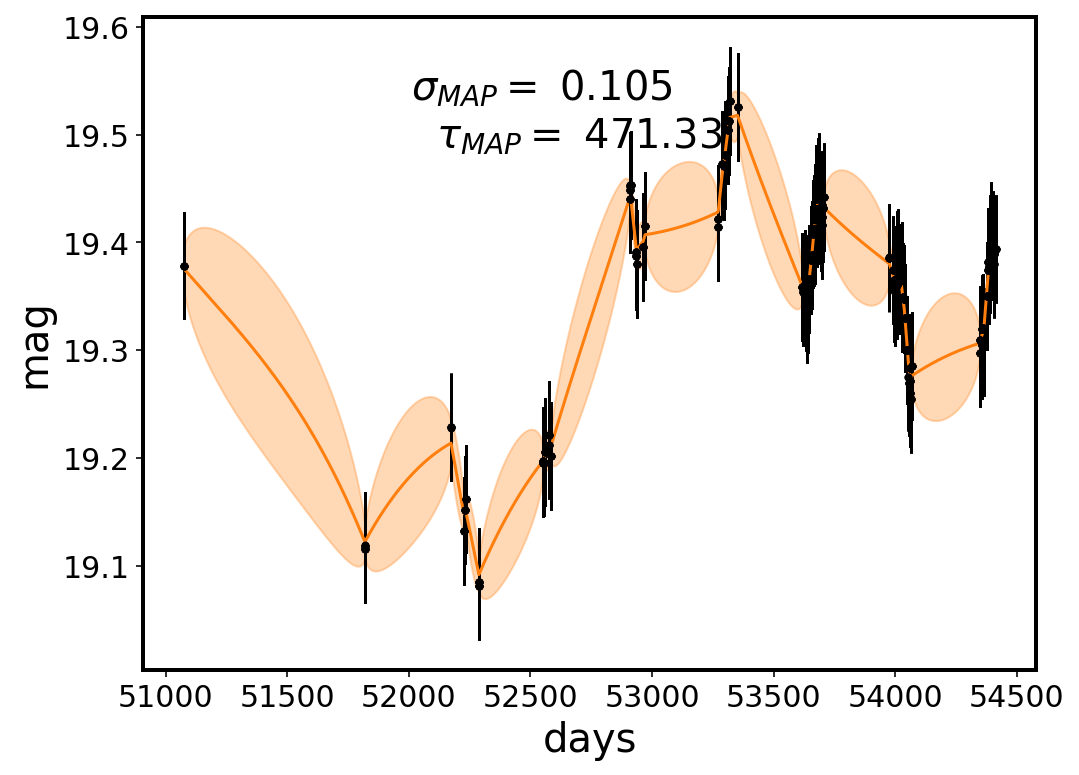

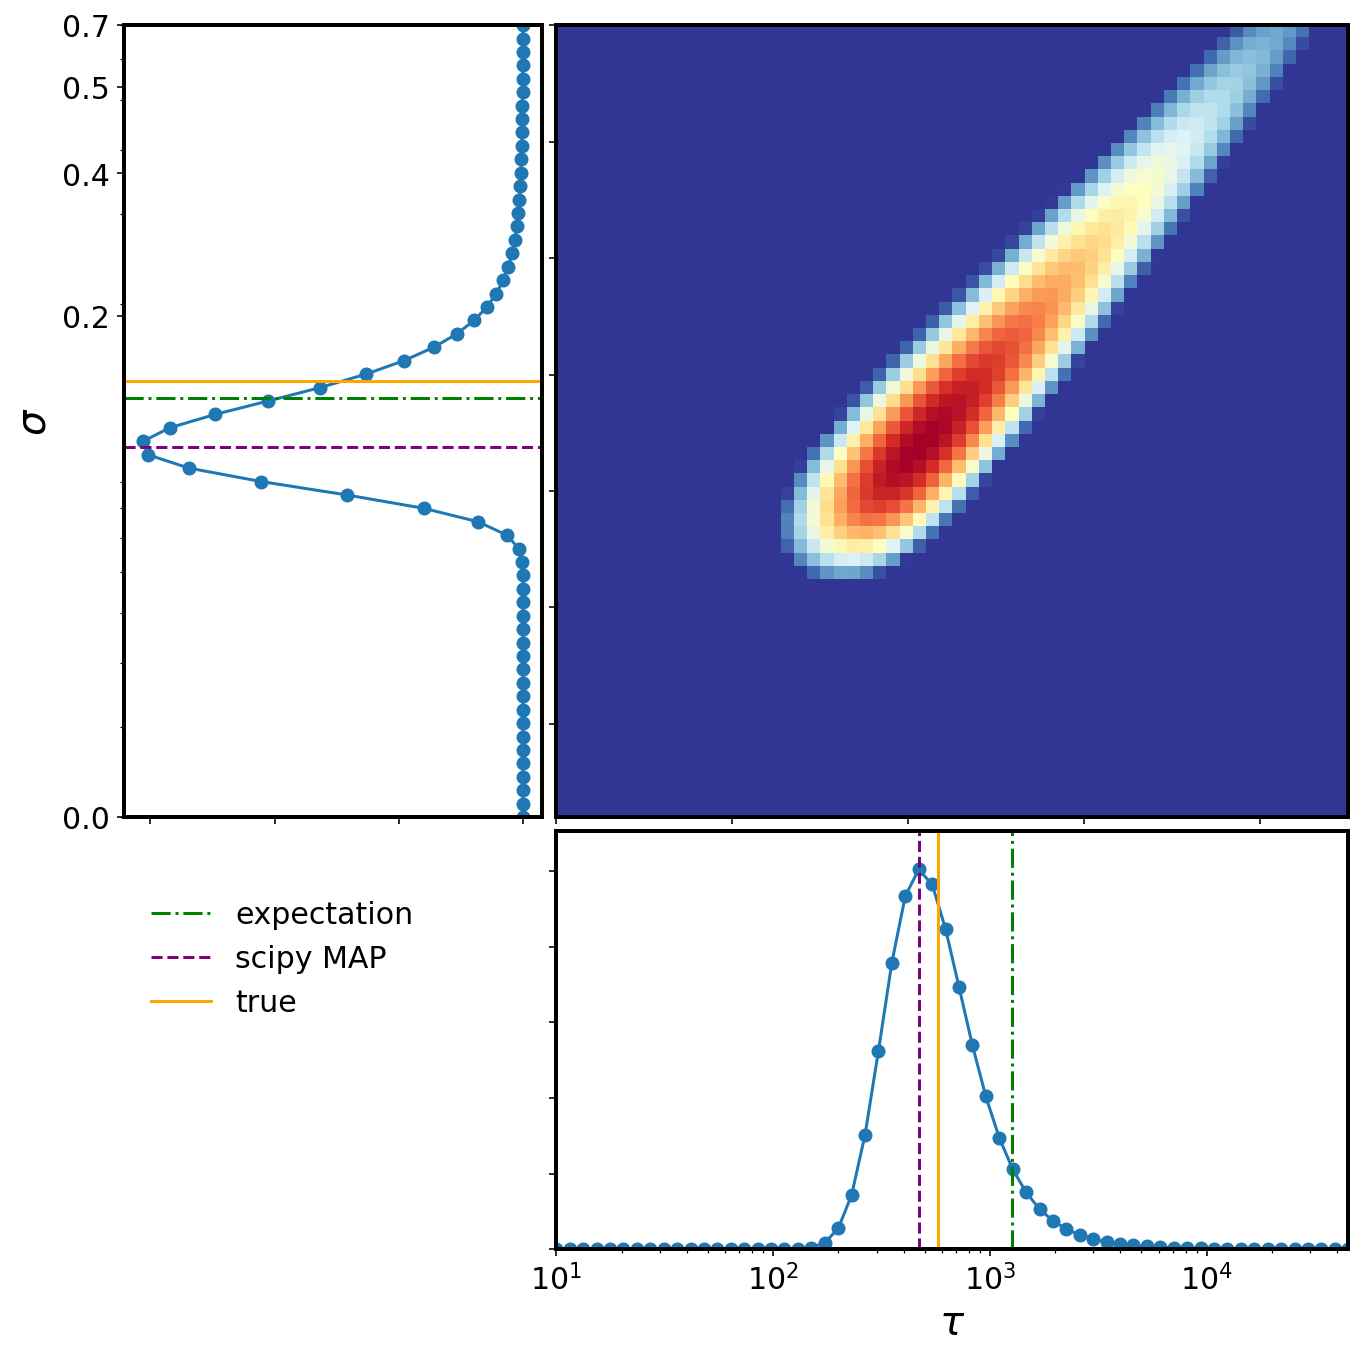

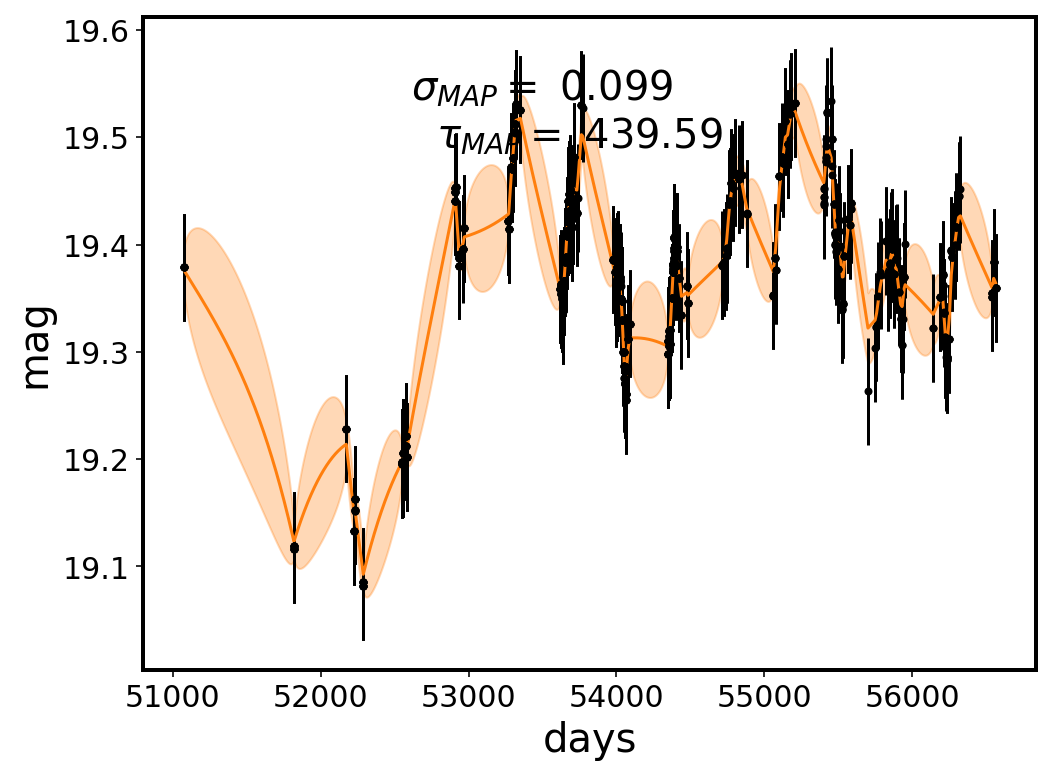

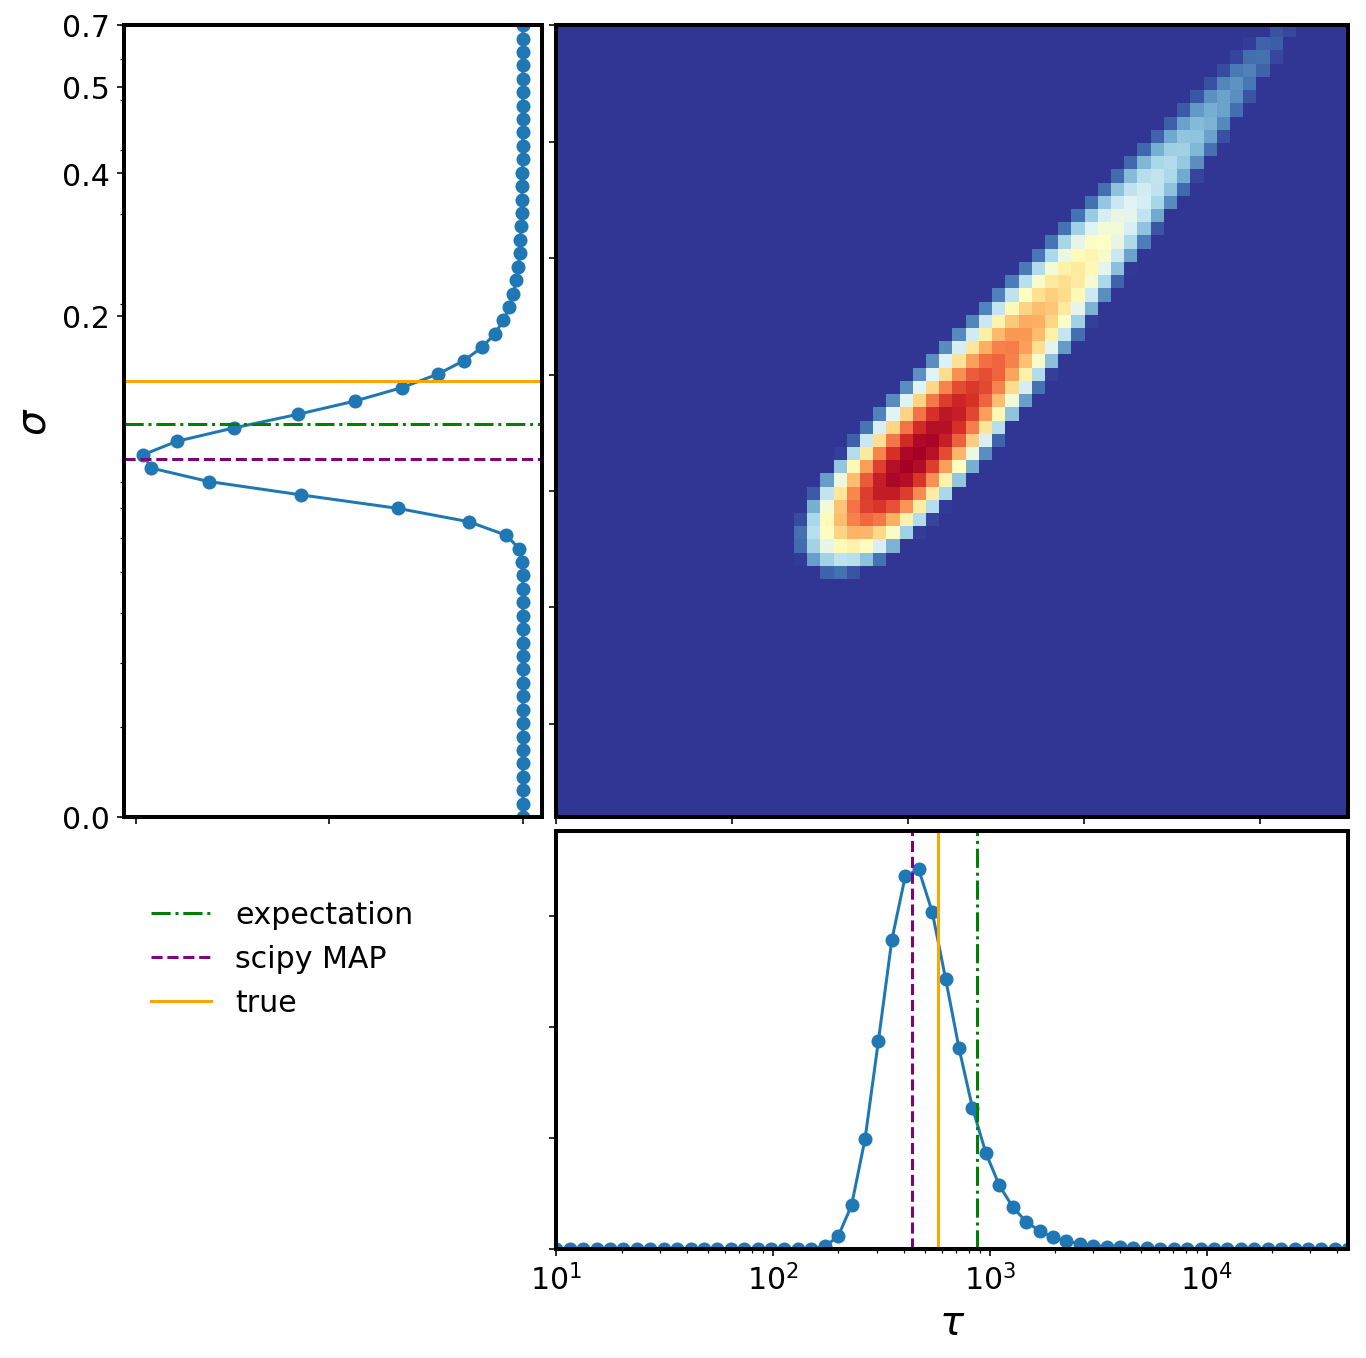

In [187]:
sig_lims , tau_lims = [0.02,0.7], [10,45000]

i = 2000 
fname = outDir+done_lcs[i]
print(i, ' fitting ', fname) 
lcname = done_lcs[i][:-4]
lc = Table.read(fname, format='ascii')
median_err = np.median(lc['magerr'].data)

# Read the simulated LC  to have exactly the same realization of the 
# stochastic process ...
name = '../data_products/Simulated_LC_DRW/'+done_lcs[i]
sim_lc = Table.read(name, format='ascii',)

t,y,yerr = sim_lc['mjd'].data, sim_lc['mag'].data, sim_lc['magerr'].data

# Sample at cadences of SDSS,  SDSS+CRTS, SDSS+CRTS+PTF,  SDSS+CRTS+PTF+PS1
m1 = lc['survey'].data == 'sdss'
m2 = lc['survey'].data == 'crts'
m3 = lc['survey'].data == 'ptf'
m4 = lc['survey'].data == 'ps1'

t1 = np.sort(lc['mjd'].data[m1])
#t12 = np.sort(lc['mjd'].data[m1|m2])
#t123 = np.sort(lc['mjd'].data[m1|m2|m3])
t1234 = np.sort(lc['mjd'])

prior = 'Jeff1'
# Sample at these times , and fit with Celerite ... 
for j,time in enumerate([t1,t1234]) : 
    y_sample = np.interp(time,t,y)

    # find the MAP estimate 
    sigmaMAP, tauMAP,gp = mod.find_celerite_MAP(time,y_sample,median_err, 
                              sigma_in, tau_in, prior=prior,set_bounds=True, 
                              sig_lims=sig_lims, tau_lims=tau_lims ,verbose=False)

    
    # plot the GP preduction... 
    mod.plot_gp_prediction(time,y_sample,median_err,gp,sigmaMAP, tauMAP,
                     savefig=False, figname='')
    
    
    # expectation from grid  
    Ngrid = 60  ; scale = 'log'
    sigma_grid, tau_grid = mod.make_grid(scale,sig_lims, tau_lims,Ngrid) 
    logP = mod.evaluate_logP(sigma_grid, tau_grid,y_sample,gp,prior)

    # find the expectation value 
    sigmaEXP, tauEXP = mod.find_expectation_value(logP, sigma_grid, tau_grid)
    
    # plot the logP
    logP, sigma_exp, tau_exp  = mod.plot_logP(logP, sigma_grid, 
                                              tau_grid, sigmaMAP, tauMAP,  
                     sigma_in, tau_in, scale,verbose=True)
    
    

In [78]:
baseline = []
for i in range(0,len(done_lcs)):
    fname = outDir+done_lcs[i]
    lcname = done_lcs[i][:-4]
    lc = Table.read(fname, format='ascii')
    tmax, tmin = lc['mjd'].max()  , lc['mjd'].min()
    #print((tmax-tmin)/365.)
    baseline.append(tmax-tmin)

(array([  0.00000000e+00,   4.04000000e+02,   2.01000000e+03,
          2.57200000e+03,   9.28000000e+02,   2.42000000e+02,
          2.06000000e+02,   2.00000000e+00,   2.60000000e+01,
          6.00000000e+00]),
 array([-1.06 , -1.034, -1.008, -0.982, -0.956, -0.93 , -0.904, -0.878,
        -0.852, -0.826, -0.8  ]),
 <a list of 10 Patch objects>)

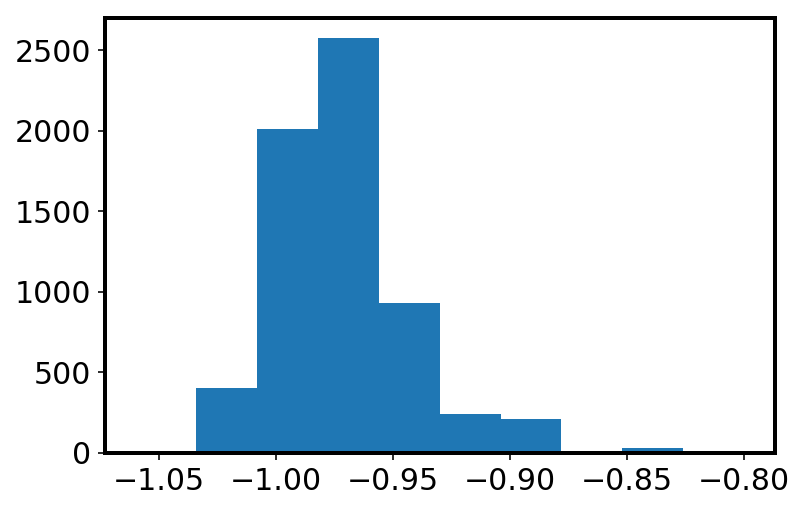

In [178]:
plt.hist(np.log10(575/ np.asarray(baseline)), range=(-1.06,-0.8))

###  Load the results 

In [192]:
t = np.load('combined_taus.npy').item()
s = np.load('combined_sigmas.npy').item()
n = np.load('combined_lcnames.npy')

res = Table([n, t[1], t[2], t[3], t[4], s[1],s[2],s[3],s[4]],
           names=['lcname', 't1', 't2',
                 't3', 't4', 's1','s2','s3','s4'])

t = np.load('combined_taus1.npy').item()
s = np.load('combined_sigmas1.npy').item()
n = np.load('combined_lcnames1.npy')

res1 = Table([n, t[1], t[2], t[3], t[4], s[1],s[2],s[3],s[4]],
           names=['lcname', 't1', 't2',
                 't3', 't4', 's1','s2','s3','s4'])

res_map = vstack([res,res1])

In [8]:
tau_in  = 575
SF_inf = 0.2

In [84]:
# results of EXP fits : Jeff2 

t = np.load('combined_tau_EXP.npy').item()
s = np.load('combined_sigma_EXP.npy').item()
n = np.load('combined_lcname_EXP.npy')

res_exp = Table([n, t[1], t[2], t[3], t[4], s[1],s[2],s[3],s[4]],
           names=['lcname', 't1', 't2',
                 't3', 't4', 's1','s2','s3','s4'])

FileNotFoundError: [Errno 2] No such file or directory: 'combined_tau_EXP.npy'

In [152]:
# results of EXP fits : Jeff1
prior = 'Jeff1'
t = np.load('combined_tau_EXP_'+prior+'.npy').item()
s = np.load('combined_sigma_EXP_'+prior+'.npy').item()
n = np.load('combined_lcname_EXP_'+prior+'.npy')
res_exp = Table([n, t[1][-6444:], t[2][-6444:], s[1][-6444:],s[2][-6444:]],
           names=['lcname', 't1', 't4',
                's1','s4'])

NameError: name 'res_exp' is not defined

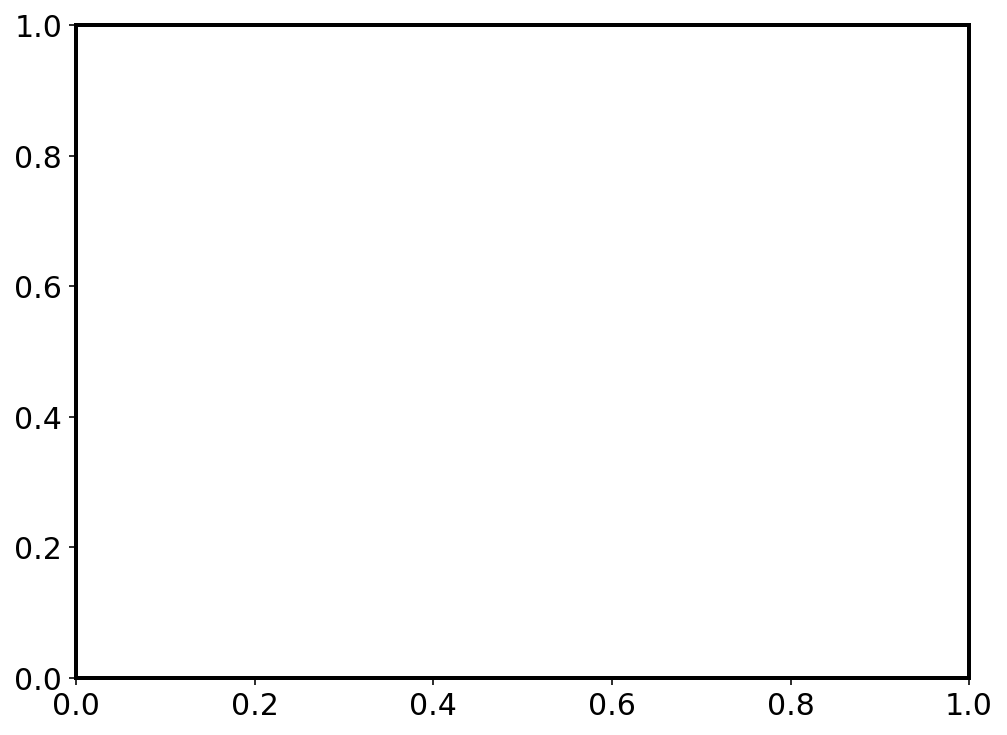

In [83]:
%matplotlib inline
label = ['sdss', 'sdss+crts', 'sdss+crts+ptf', 'sdss+crts+ptf+ps1']
import matplotlib.lines as mlines
#plot tau_MAP}
factor = np.power(10,0.11)
fig,ax = plt.subplots(1,1,figsize=(8,6))
colors= ['blue','green', 'orange',  'red']
ax_legend_handles = []
for i in  [1,2,3,4]:
    istr = str(i)
    #v = res_map['t'+istr] # mode 
    v = res_exp['t'+istr] # expectation
    #median = (mode+ 2*expectation) / 3 
    #avg = (res_exp['t'+istr]  + res_map['t'+istr]) / 2
    x = v  / tau_in
    ax.hist(x , range=[0,4], histtype='step', 
            color=colors[i-1], lw=3,bins=40)
    
    line = mlines.Line2D([], [],  color=colors[i-1], 
                                 label=label[i-1].upper())
    ax_legend_handles.append(line)
legend_ax = fig.add_axes([0.6, 0.5, 0.29, 0.29])     #  (x0 ,y0  , dx,  dy )  
legend_ax.legend(loc='upper right', handles = ax_legend_handles, frameon=False,
                 fontsize=15,)
legend_ax.axis('off')
ax.axvline(1, lw=2, ls='--', c='grey')
ax.set_xlabel(r'$\tau_{fit} / \tau_{in}$')
ax.set_ylabel('count')
plt.savefig('combined_lc_sampled_tau_c_MAP.png', bbox_inches='tight')
            


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


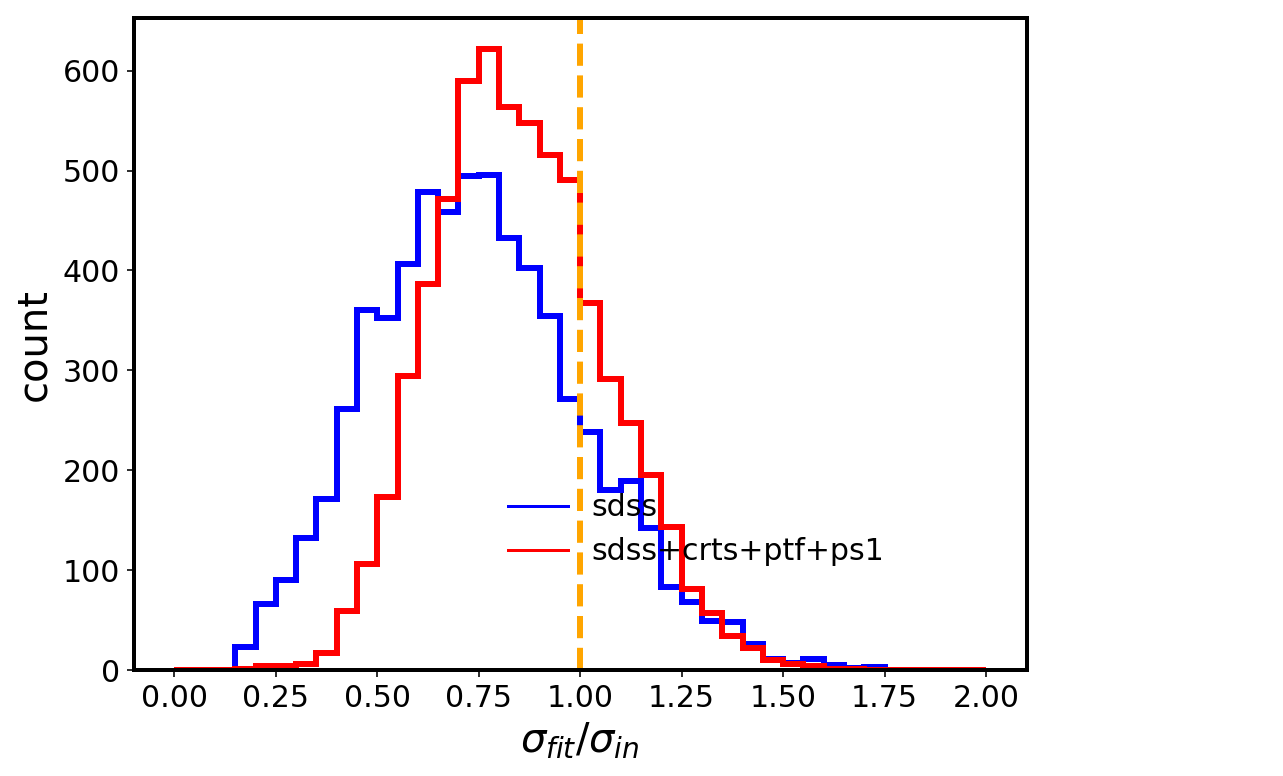

In [155]:
# plot sigma_MAP
sigma_in = SF_inf / np.sqrt(2)
fig,ax = plt.subplots(1,1,figsize=(8,6))
colors= ['blue','green', 'orange',  'red']
ax_legend_handles = []

for i in [1,4]:
    istr = str(i)
    ax.hist(res_exp['s'+istr] /  sigma_in,  histtype='step', lw=3,  color=colors[i-1],
            range=(0,2),bins=40,
           )
    line = mlines.Line2D([], [],  color=colors[i-1], 
                                 label=label[i-1])
    ax_legend_handles.append(line)
legend_ax = fig.add_axes([0.8, 0.1, 0.29, 0.29])     #  (x0 ,y0  , dx,  dy )  
legend_ax.legend(loc='upper right', handles = ax_legend_handles, frameon=False,
                 fontsize=15, bbox_to_anchor=(0, 0.9))
legend_ax.axis('off')
        
#ax.legend()
ax.axvline(1 , lw=3, ls='--', c='orange')
ax.set_xlabel(r'$\sigma_{fit} / \sigma_{in}$')
ax.set_ylabel('count')
plt.savefig('combined_lc_sampled_sigma_c.png', bbox_inches='tight')


# plot sigma_hat = sigma * np.sqrt(2) / np.sqrt(tau)

# fig,ax = plt.subplots(1,1,figsize=(8,6))
# for i in range(1,5):
#     istr = str(i)
#     sig_hat  = res['s'+istr]*np.sqrt(2)  / res['t'+istr]
#     ax.hist(sig_hat,  histtype='step', lw=3, bins=50, 
#              label=label[i-1], range=(0,0.02))
# ax.legend()
# sig_in = SF_inf /np.sqrt(2) 
# sig_hat_in= sig_in * np.sqrt(2)  / np.sqrt(tau_in)
# ax.axvline(sig_hat_in , lw=3, ls='--', c='orange')
# ax.set_xlabel(r'$\hat{\sigma}_{MAP}$')
# ax.set_ylabel('count')
# plt.savefig('combined_lc_sampled_sigma_hat_c.png', bbox_inches='tight')

We can't yet directly use the light curves and fit using all points, because the magnitudes are in different photometric systems. Need to translate them..  

In [170]:
# Use real light curves : 
- can't directly fit with CELERITE finding MAP  - need to make a translation into 
 a c

i=0
fname = outDir+done_lcs[i]
lc = Table.read(fname, format='ascii')
tmax, tmin = lc['mjd'].max()  , lc['mjd'].min()
Npts = int((tmax-tmin))*4 # 4 points per day
t = np.sort(np.random.uniform(tmin, tmax, Npts)) 
y = mod.sim_DRW_lightcurve(t, SF_inf, tau_in , np.mean(lc['mag']))
median_err = np.median(lc['magerr'].data)
print(i, ' original lc ', len(lc), 'pts,  simulated lc ', Npts, ' pts, ',
      'med err is ', median_err)
yerr = np.ones_like(t)*median_err
#plt.errorbar(t,y,yerr_med)
sim_lc = Table([t,y,yerr], names=['mjd', 'mag', 'magerr'])
# store the simulated 'true' LC 

In [ ]:
1/60